In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, Concatenate, Dropout, GaussianNoise, LayerNormalization, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob

In [3]:
def normalize_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [4]:
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
x_train = normalize_tanh(x_train.reshape(-1, 28, 28, 1))

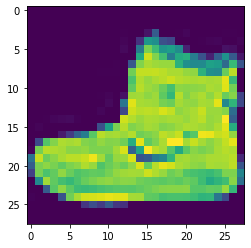

In [6]:
plt.imshow(x_train[0].reshape(28,28))

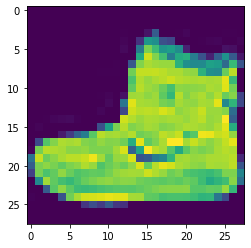

In [7]:
plt.imshow(unnormalize_tanh(normalize_tanh(x_train[0])).reshape(28,28))

In [8]:
# network parameters
width = 28
height = 28
latent_dim = 100



def build_generator():
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_latent')



    x = Dense(7*7*128)(latent_inputs)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Reshape((7,7,128))(x)


    x = UpSampling2D()(x)
    x = Conv2D(64,3, strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(32,3, strides=1, padding='same')(x)    
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)



    img_outputs = Conv2D(1,5, strides=1, activation='tanh', padding='same')(x)


    return Model(latent_inputs, img_outputs, name='generator')

generator = build_generator()
generator.summary()








Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_latent (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        73

In [9]:
def build_discriminator():
    inputs = Input(shape=(width,height,1), name='discriminator_input')
    
    

    
    x = Conv2D(64, 3, strides=2, padding='same')(inputs)
    x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(258, 3, strides=2, padding='same')(x)
    x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)

    valid = Dense(1)(x)



    return Model(inputs, valid, name='discriminator')
build_discriminator().summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
layer_normalization (LayerNo (None, 14, 14, 64)        128       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
layer_normalization_1 (Layer (None, 7, 7, 128)         256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)       

In [10]:
generator = build_generator()
discriminator = build_discriminator()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

In [11]:
@tf.function
def train_step_generator():
    
    batch_size = 64
    latent_dim = 100
    
    with tf.GradientTape() as gen_tape:    
        

        
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=True)       
        

        # gan loss
        fake_output = discriminator(generated_images, training=False)
        gen_loss = -tf.reduce_mean(fake_output)
   
        generator_loss = gen_loss


    
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss



@tf.function
def train_step_discriminator(images):
    
    batch_size = 64
    latent_dim = 100
    gp_lambda = 10
    
    with tf.GradientTape() as disc_tape:
        # generate 
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=False)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated_images = generated_images * alpha + images * (1 - alpha)
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_images)
            interpolated_output = discriminator(interpolated_images, training=True)
        gp_gradients = gp_tape.gradient(interpolated_output, interpolated_images)
        
        # l2 norm on all axis except batch
        gp_gradients_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(gp_gradients), axis=[1,2,3]))
        gp = tf.reduce_mean(tf.square(gp_gradients_l2_norm-1))
        
        
        
        loss_real = tf.reduce_mean(real_output)
        loss_fake = tf.reduce_mean(fake_output)
        disc_loss = (loss_fake - loss_real) + gp_lambda * gp 
        
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return loss_real, loss_fake
    
        
        
        

Iteration [1/10000]......5.648(s) gen: -1.51536 - disc_fake: 1.55427 - disc_real: 1.65973 - disc_real: 0.10547
Iteration [2/10000]......0.134(s) gen: -1.58104 - disc_fake: 1.41551 - disc_real: 1.78962 - disc_real: 0.37411
Iteration [3/10000]......0.127(s) gen: -1.48673 - disc_fake: 1.30013 - disc_real: 1.80117 - disc_real: 0.50103
Iteration [4/10000]......0.119(s) gen: -1.33077 - disc_fake: 1.26865 - disc_real: 1.86407 - disc_real: 0.59542
Iteration [5/10000]......0.116(s) gen: -1.30170 - disc_fake: 1.22968 - disc_real: 1.95720 - disc_real: 0.72752
Iteration [6/10000]......0.112(s) gen: -1.21051 - disc_fake: 1.17932 - disc_real: 2.10877 - disc_real: 0.92945
Iteration [7/10000]......0.116(s) gen: -1.01108 - disc_fake: 1.14433 - disc_real: 2.16212 - disc_real: 1.01778
Iteration [8/10000]......0.112(s) gen: -0.88311 - disc_fake: 0.97332 - disc_real: 2.37609 - disc_real: 1.40277
Iteration [9/10000]......0.113(s) gen: -0.79479 - disc_fake: 0.74879 - disc_real: 2.40586 - disc_real: 1.65707
I

Iteration [73/10000]......0.114(s) gen: 1.68954 - disc_fake: -19.04178 - disc_real: -5.41116 - disc_real: 13.63061
Iteration [74/10000]......0.112(s) gen: 4.51120 - disc_fake: -18.95559 - disc_real: -3.20551 - disc_real: 15.75008
Iteration [75/10000]......0.113(s) gen: 3.45352 - disc_fake: -20.24475 - disc_real: -4.44087 - disc_real: 15.80388
Iteration [76/10000]......0.113(s) gen: 3.63475 - disc_fake: -20.29990 - disc_real: -4.66023 - disc_real: 15.63967
Iteration [77/10000]......0.112(s) gen: 1.88680 - disc_fake: -22.28364 - disc_real: -5.05713 - disc_real: 17.22651
Iteration [78/10000]......0.112(s) gen: 0.29377 - disc_fake: -22.56365 - disc_real: -5.08550 - disc_real: 17.47815
Iteration [79/10000]......0.112(s) gen: -0.23676 - disc_fake: -23.79838 - disc_real: -3.76104 - disc_real: 20.03734
Iteration [80/10000]......0.113(s) gen: -0.27609 - disc_fake: -23.80076 - disc_real: -2.64111 - disc_real: 21.15965
Iteration [81/10000]......0.113(s) gen: -0.56261 - disc_fake: -25.15298 - disc

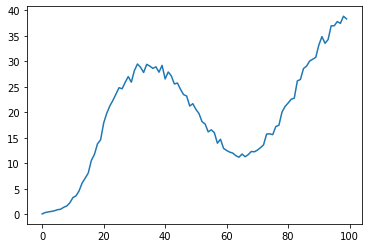

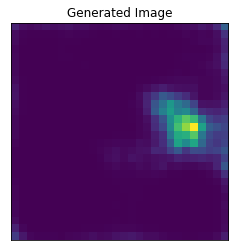

Iteration [101/10000]......0.114(s) gen: -19.15427 - disc_fake: -37.72526 - disc_real: 1.78884 - disc_real: 39.51410
Iteration [102/10000]......0.113(s) gen: -19.83331 - disc_fake: -37.59700 - disc_real: 4.70470 - disc_real: 42.30170
Iteration [103/10000]......0.113(s) gen: -20.38140 - disc_fake: -38.63597 - disc_real: 2.21437 - disc_real: 40.85034
Iteration [104/10000]......0.113(s) gen: -19.39139 - disc_fake: -36.65914 - disc_real: 4.53934 - disc_real: 41.19848
Iteration [105/10000]......0.114(s) gen: -21.81744 - disc_fake: -38.28143 - disc_real: 1.61604 - disc_real: 39.89747
Iteration [106/10000]......0.113(s) gen: -22.13746 - disc_fake: -35.57747 - disc_real: 5.64910 - disc_real: 41.22657
Iteration [107/10000]......0.113(s) gen: -22.25018 - disc_fake: -39.84326 - disc_real: 2.49363 - disc_real: 42.33689
Iteration [108/10000]......0.113(s) gen: -20.79334 - disc_fake: -39.78368 - disc_real: 2.81033 - disc_real: 42.59401
Iteration [109/10000]......0.113(s) gen: -23.48272 - disc_fake: 

Iteration [172/10000]......0.114(s) gen: -30.83700 - disc_fake: -50.47624 - disc_real: -3.29636 - disc_real: 47.17988
Iteration [173/10000]......0.112(s) gen: -36.11185 - disc_fake: -50.21533 - disc_real: -1.46392 - disc_real: 48.75141
Iteration [174/10000]......0.113(s) gen: -33.71094 - disc_fake: -50.50621 - disc_real: -3.11837 - disc_real: 47.38785
Iteration [175/10000]......0.114(s) gen: -32.74420 - disc_fake: -49.00725 - disc_real: -1.09257 - disc_real: 47.91467
Iteration [176/10000]......0.115(s) gen: -31.87280 - disc_fake: -50.63343 - disc_real: -3.49475 - disc_real: 47.13868
Iteration [177/10000]......0.112(s) gen: -34.57754 - disc_fake: -49.86580 - disc_real: -4.16639 - disc_real: 45.69941
Iteration [178/10000]......0.113(s) gen: -31.82289 - disc_fake: -51.06810 - disc_real: -2.74254 - disc_real: 48.32557
Iteration [179/10000]......0.113(s) gen: -34.18747 - disc_fake: -51.20900 - disc_real: -4.14351 - disc_real: 47.06550
Iteration [180/10000]......0.114(s) gen: -35.43121 - dis

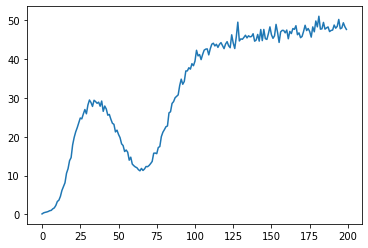

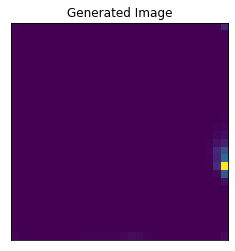

Iteration [201/10000]......0.116(s) gen: -36.63244 - disc_fake: -51.24442 - disc_real: -5.12925 - disc_real: 46.11517
Iteration [202/10000]......0.114(s) gen: -32.80064 - disc_fake: -54.13314 - disc_real: -5.29011 - disc_real: 48.84303
Iteration [203/10000]......0.113(s) gen: -35.58296 - disc_fake: -52.00977 - disc_real: -3.15836 - disc_real: 48.85141
Iteration [204/10000]......0.113(s) gen: -38.28174 - disc_fake: -53.15484 - disc_real: -5.16170 - disc_real: 47.99314
Iteration [205/10000]......0.113(s) gen: -35.01463 - disc_fake: -53.17106 - disc_real: -7.68952 - disc_real: 45.48154
Iteration [206/10000]......0.113(s) gen: -34.85366 - disc_fake: -52.56330 - disc_real: -5.50949 - disc_real: 47.05381
Iteration [207/10000]......0.114(s) gen: -33.79770 - disc_fake: -53.99571 - disc_real: -5.66906 - disc_real: 48.32665
Iteration [208/10000]......0.114(s) gen: -36.49122 - disc_fake: -54.66609 - disc_real: -8.67574 - disc_real: 45.99036
Iteration [209/10000]......0.114(s) gen: -37.45034 - dis

Iteration [271/10000]......0.113(s) gen: -38.70158 - disc_fake: -59.24807 - disc_real: -9.01977 - disc_real: 50.22830
Iteration [272/10000]......0.113(s) gen: -35.58818 - disc_fake: -58.59958 - disc_real: -10.47231 - disc_real: 48.12727
Iteration [273/10000]......0.113(s) gen: -38.00959 - disc_fake: -58.98659 - disc_real: -9.11645 - disc_real: 49.87014
Iteration [274/10000]......0.114(s) gen: -36.28788 - disc_fake: -60.04432 - disc_real: -10.23038 - disc_real: 49.81393
Iteration [275/10000]......0.114(s) gen: -36.57896 - disc_fake: -58.83577 - disc_real: -10.52348 - disc_real: 48.31229
Iteration [276/10000]......0.114(s) gen: -35.67339 - disc_fake: -59.51448 - disc_real: -11.37571 - disc_real: 48.13877
Iteration [277/10000]......0.114(s) gen: -39.23497 - disc_fake: -58.81378 - disc_real: -10.55302 - disc_real: 48.26077
Iteration [278/10000]......0.114(s) gen: -39.25070 - disc_fake: -60.01549 - disc_real: -9.87538 - disc_real: 50.14011
Iteration [279/10000]......0.115(s) gen: -36.62621 

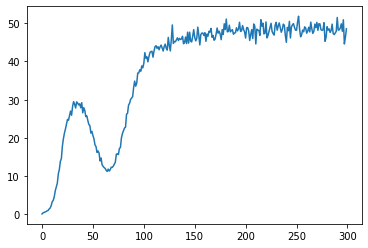

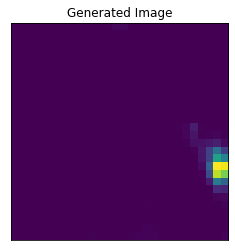

Iteration [301/10000]......0.115(s) gen: -35.84783 - disc_fake: -60.60854 - disc_real: -10.85803 - disc_real: 49.75051
Iteration [302/10000]......0.115(s) gen: -37.93254 - disc_fake: -60.39097 - disc_real: -10.03018 - disc_real: 50.36079
Iteration [303/10000]......0.116(s) gen: -36.18797 - disc_fake: -60.20648 - disc_real: -13.08591 - disc_real: 47.12057
Iteration [304/10000]......0.114(s) gen: -35.51158 - disc_fake: -59.75688 - disc_real: -12.34581 - disc_real: 47.41107
Iteration [305/10000]......0.114(s) gen: -34.87378 - disc_fake: -59.46027 - disc_real: -11.58257 - disc_real: 47.87771
Iteration [306/10000]......0.114(s) gen: -37.11417 - disc_fake: -60.51497 - disc_real: -16.32907 - disc_real: 44.18591
Iteration [307/10000]......0.115(s) gen: -38.00004 - disc_fake: -60.88910 - disc_real: -12.54383 - disc_real: 48.34526
Iteration [308/10000]......0.116(s) gen: -36.71211 - disc_fake: -60.49071 - disc_real: -11.83101 - disc_real: 48.65970
Iteration [309/10000]......0.113(s) gen: -37.645

Iteration [370/10000]......0.114(s) gen: -16.96563 - disc_fake: -57.02441 - disc_real: -25.02950 - disc_real: 31.99490
Iteration [371/10000]......0.114(s) gen: -16.99433 - disc_fake: -55.78592 - disc_real: -25.58985 - disc_real: 30.19607
Iteration [372/10000]......0.114(s) gen: -18.75307 - disc_fake: -57.02417 - disc_real: -27.16566 - disc_real: 29.85851
Iteration [373/10000]......0.113(s) gen: -15.29455 - disc_fake: -56.59158 - disc_real: -25.85124 - disc_real: 30.74034
Iteration [374/10000]......0.117(s) gen: -15.60095 - disc_fake: -55.30937 - disc_real: -26.16510 - disc_real: 29.14426
Iteration [375/10000]......0.114(s) gen: -14.20882 - disc_fake: -56.13413 - disc_real: -26.60656 - disc_real: 29.52757
Iteration [376/10000]......0.115(s) gen: -13.88375 - disc_fake: -54.40155 - disc_real: -27.43032 - disc_real: 26.97123
Iteration [377/10000]......0.114(s) gen: -13.20235 - disc_fake: -54.41446 - disc_real: -28.88741 - disc_real: 25.52705
Iteration [378/10000]......0.114(s) gen: -10.808

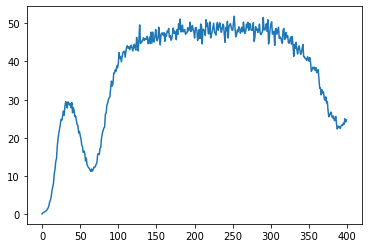

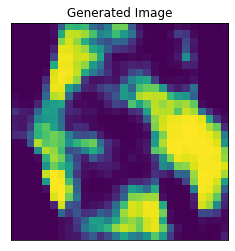

Iteration [401/10000]......0.115(s) gen: 19.69599 - disc_fake: -47.37118 - disc_real: -20.62544 - disc_real: 26.74574
Iteration [402/10000]......0.114(s) gen: 30.09696 - disc_fake: -46.12544 - disc_real: -21.48439 - disc_real: 24.64105
Iteration [403/10000]......0.114(s) gen: 32.85979 - disc_fake: -46.45307 - disc_real: -18.75348 - disc_real: 27.69959
Iteration [404/10000]......0.114(s) gen: 32.46894 - disc_fake: -48.00471 - disc_real: -19.57844 - disc_real: 28.42627
Iteration [405/10000]......0.113(s) gen: 45.10963 - disc_fake: -46.97510 - disc_real: -15.89589 - disc_real: 31.07920
Iteration [406/10000]......0.114(s) gen: 39.04151 - disc_fake: -46.38787 - disc_real: -17.51088 - disc_real: 28.87699
Iteration [407/10000]......0.114(s) gen: 35.12223 - disc_fake: -47.28540 - disc_real: -17.15615 - disc_real: 30.12925
Iteration [408/10000]......0.115(s) gen: 41.11457 - disc_fake: -45.73304 - disc_real: -17.05973 - disc_real: 28.67331
Iteration [409/10000]......0.114(s) gen: 35.18797 - disc

Iteration [471/10000]......0.114(s) gen: 31.67064 - disc_fake: -25.46881 - disc_real: -2.97661 - disc_real: 22.49220
Iteration [472/10000]......0.114(s) gen: 38.15083 - disc_fake: -24.37458 - disc_real: -1.79483 - disc_real: 22.57975
Iteration [473/10000]......0.114(s) gen: 34.81476 - disc_fake: -24.09785 - disc_real: -1.69918 - disc_real: 22.39867
Iteration [474/10000]......0.114(s) gen: 39.16470 - disc_fake: -23.52291 - disc_real: -4.25045 - disc_real: 19.27245
Iteration [475/10000]......0.114(s) gen: 34.77339 - disc_fake: -26.54742 - disc_real: -5.12120 - disc_real: 21.42622
Iteration [476/10000]......0.115(s) gen: 38.67348 - disc_fake: -25.85495 - disc_real: -3.05241 - disc_real: 22.80254
Iteration [477/10000]......0.115(s) gen: 35.00896 - disc_fake: -26.42186 - disc_real: -5.19534 - disc_real: 21.22653
Iteration [478/10000]......0.116(s) gen: 35.59851 - disc_fake: -23.60740 - disc_real: -0.85983 - disc_real: 22.74757
Iteration [479/10000]......0.114(s) gen: 36.83847 - disc_fake: -

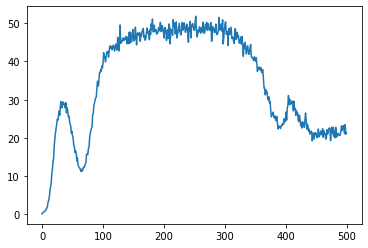

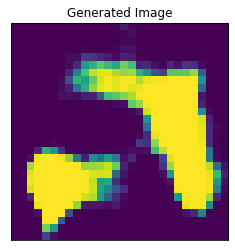

Iteration [501/10000]......0.115(s) gen: 23.61704 - disc_fake: -21.23897 - disc_real: -0.77186 - disc_real: 20.46712
Iteration [502/10000]......0.113(s) gen: 32.41435 - disc_fake: -20.34059 - disc_real: 0.59369 - disc_real: 20.93427
Iteration [503/10000]......0.114(s) gen: 37.00557 - disc_fake: -21.19750 - disc_real: 1.45682 - disc_real: 22.65433
Iteration [504/10000]......0.115(s) gen: 29.62584 - disc_fake: -21.13607 - disc_real: -0.09558 - disc_real: 21.04049
Iteration [505/10000]......0.115(s) gen: 35.08969 - disc_fake: -21.45531 - disc_real: 1.06676 - disc_real: 22.52208
Iteration [506/10000]......0.115(s) gen: 33.56631 - disc_fake: -24.52171 - disc_real: 0.24068 - disc_real: 24.76239
Iteration [507/10000]......0.114(s) gen: 29.74918 - disc_fake: -22.36981 - disc_real: 2.01156 - disc_real: 24.38137
Iteration [508/10000]......0.114(s) gen: 30.85766 - disc_fake: -21.17189 - disc_real: 1.38354 - disc_real: 22.55543
Iteration [509/10000]......0.114(s) gen: 35.77596 - disc_fake: -20.974

Iteration [572/10000]......0.114(s) gen: 6.26514 - disc_fake: -11.74389 - disc_real: 8.28791 - disc_real: 20.03180
Iteration [573/10000]......0.115(s) gen: 9.57044 - disc_fake: -10.41248 - disc_real: 10.12562 - disc_real: 20.53810
Iteration [574/10000]......0.114(s) gen: 11.11149 - disc_fake: -13.82843 - disc_real: 5.85492 - disc_real: 19.68336
Iteration [575/10000]......0.114(s) gen: 10.43508 - disc_fake: -11.56851 - disc_real: 7.97796 - disc_real: 19.54647
Iteration [576/10000]......0.115(s) gen: 8.75370 - disc_fake: -11.92989 - disc_real: 7.57921 - disc_real: 19.50910
Iteration [577/10000]......0.114(s) gen: 10.93200 - disc_fake: -11.87945 - disc_real: 7.46371 - disc_real: 19.34316
Iteration [578/10000]......0.116(s) gen: 11.32222 - disc_fake: -11.45530 - disc_real: 6.40680 - disc_real: 17.86210
Iteration [579/10000]......0.115(s) gen: 7.79540 - disc_fake: -9.85043 - disc_real: 9.59098 - disc_real: 19.44141
Iteration [580/10000]......0.114(s) gen: 1.30980 - disc_fake: -11.08647 - di

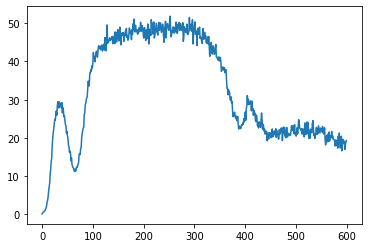

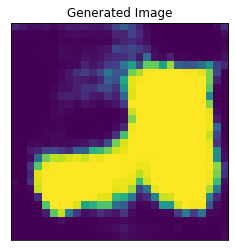

Iteration [601/10000]......0.115(s) gen: 0.52340 - disc_fake: -5.68124 - disc_real: 10.87990 - disc_real: 16.56113
Iteration [602/10000]......0.115(s) gen: -0.38274 - disc_fake: -6.51454 - disc_real: 10.38359 - disc_real: 16.89812
Iteration [603/10000]......0.116(s) gen: -0.11095 - disc_fake: -6.69804 - disc_real: 11.57678 - disc_real: 18.27482
Iteration [604/10000]......0.115(s) gen: 7.19707 - disc_fake: -7.61212 - disc_real: 11.15948 - disc_real: 18.77161
Iteration [605/10000]......0.115(s) gen: 0.72204 - disc_fake: -11.42949 - disc_real: 8.57361 - disc_real: 20.00310
Iteration [606/10000]......0.115(s) gen: 5.11964 - disc_fake: -7.13059 - disc_real: 10.27704 - disc_real: 17.40763
Iteration [607/10000]......0.115(s) gen: 4.32343 - disc_fake: -7.33582 - disc_real: 10.03894 - disc_real: 17.37475
Iteration [608/10000]......0.114(s) gen: 1.28404 - disc_fake: -7.38965 - disc_real: 9.71527 - disc_real: 17.10492
Iteration [609/10000]......0.113(s) gen: 1.47146 - disc_fake: -6.95272 - disc_r

Iteration [673/10000]......0.116(s) gen: 11.07719 - disc_fake: -11.84745 - disc_real: 1.52445 - disc_real: 13.37190
Iteration [674/10000]......0.114(s) gen: 11.55948 - disc_fake: -11.10209 - disc_real: 2.11371 - disc_real: 13.21580
Iteration [675/10000]......0.114(s) gen: 11.29302 - disc_fake: -10.59767 - disc_real: 2.82404 - disc_real: 13.42171
Iteration [676/10000]......0.114(s) gen: 9.53703 - disc_fake: -10.87789 - disc_real: 2.76790 - disc_real: 13.64579
Iteration [677/10000]......0.114(s) gen: 13.91579 - disc_fake: -9.54113 - disc_real: 4.11325 - disc_real: 13.65437
Iteration [678/10000]......0.114(s) gen: 9.89996 - disc_fake: -10.02028 - disc_real: 1.96627 - disc_real: 11.98655
Iteration [679/10000]......0.115(s) gen: 11.62384 - disc_fake: -11.21038 - disc_real: 2.13606 - disc_real: 13.34644
Iteration [680/10000]......0.115(s) gen: 12.32601 - disc_fake: -9.67146 - disc_real: 3.53326 - disc_real: 13.20472
Iteration [681/10000]......0.115(s) gen: 10.28549 - disc_fake: -10.09444 - d

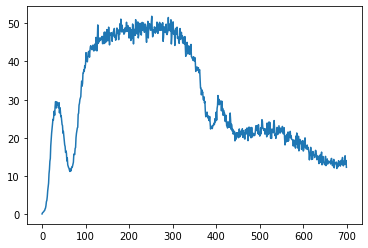

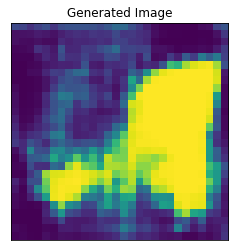

Iteration [701/10000]......0.115(s) gen: 8.96912 - disc_fake: -9.55465 - disc_real: 3.75310 - disc_real: 13.30775
Iteration [702/10000]......0.115(s) gen: 8.06597 - disc_fake: -9.05519 - disc_real: 4.71893 - disc_real: 13.77412
Iteration [703/10000]......0.116(s) gen: 10.31812 - disc_fake: -9.35914 - disc_real: 4.47826 - disc_real: 13.83740
Iteration [704/10000]......0.114(s) gen: 13.12085 - disc_fake: -10.79999 - disc_real: 2.90589 - disc_real: 13.70588
Iteration [705/10000]......0.115(s) gen: 10.03640 - disc_fake: -9.83749 - disc_real: 2.43843 - disc_real: 12.27592
Iteration [706/10000]......0.115(s) gen: 13.44957 - disc_fake: -9.74202 - disc_real: 3.59478 - disc_real: 13.33680
Iteration [707/10000]......0.115(s) gen: 11.76678 - disc_fake: -9.42423 - disc_real: 3.01942 - disc_real: 12.44365
Iteration [708/10000]......0.115(s) gen: 11.27846 - disc_fake: -10.50800 - disc_real: 3.40738 - disc_real: 13.91538
Iteration [709/10000]......0.115(s) gen: 11.98271 - disc_fake: -10.24375 - disc_

Iteration [772/10000]......0.118(s) gen: 9.67016 - disc_fake: -11.22174 - disc_real: 2.00766 - disc_real: 13.22940
Iteration [773/10000]......0.117(s) gen: 7.48033 - disc_fake: -10.01103 - disc_real: 2.97426 - disc_real: 12.98529
Iteration [774/10000]......0.117(s) gen: 11.55440 - disc_fake: -11.53935 - disc_real: 1.73576 - disc_real: 13.27511
Iteration [775/10000]......0.118(s) gen: 10.44531 - disc_fake: -11.72846 - disc_real: 0.84332 - disc_real: 12.57178
Iteration [776/10000]......0.120(s) gen: 10.60815 - disc_fake: -11.37106 - disc_real: 2.27097 - disc_real: 13.64202
Iteration [777/10000]......0.118(s) gen: 12.30011 - disc_fake: -12.47584 - disc_real: 1.74704 - disc_real: 14.22288
Iteration [778/10000]......0.117(s) gen: 9.09205 - disc_fake: -11.33851 - disc_real: 1.16607 - disc_real: 12.50458
Iteration [779/10000]......0.117(s) gen: 11.57045 - disc_fake: -10.46207 - disc_real: 2.83877 - disc_real: 13.30083
Iteration [780/10000]......0.117(s) gen: 12.95836 - disc_fake: -11.02291 - 

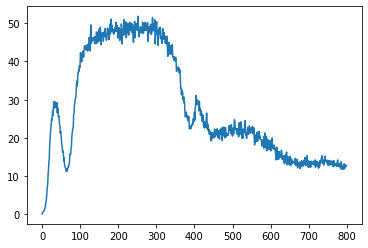

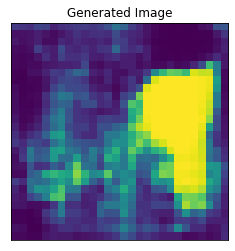

Iteration [801/10000]......0.119(s) gen: 10.63393 - disc_fake: -11.13702 - disc_real: 1.20073 - disc_real: 12.33775
Iteration [802/10000]......0.116(s) gen: 11.12644 - disc_fake: -9.76390 - disc_real: 2.07917 - disc_real: 11.84306
Iteration [803/10000]......0.116(s) gen: 10.80273 - disc_fake: -9.38050 - disc_real: 2.03704 - disc_real: 11.41755
Iteration [804/10000]......0.116(s) gen: 10.72777 - disc_fake: -9.55131 - disc_real: 2.82821 - disc_real: 12.37952
Iteration [805/10000]......0.116(s) gen: 11.38868 - disc_fake: -10.07953 - disc_real: 2.39604 - disc_real: 12.47558
Iteration [806/10000]......0.115(s) gen: 9.75267 - disc_fake: -10.11452 - disc_real: 2.15591 - disc_real: 12.27043
Iteration [807/10000]......0.115(s) gen: 10.61666 - disc_fake: -11.29323 - disc_real: 1.16681 - disc_real: 12.46004
Iteration [808/10000]......0.114(s) gen: 13.38387 - disc_fake: -11.45747 - disc_real: 0.55967 - disc_real: 12.01715
Iteration [809/10000]......0.114(s) gen: 11.29053 - disc_fake: -12.20064 - d

Iteration [872/10000]......0.118(s) gen: 10.49265 - disc_fake: -10.31286 - disc_real: 0.62704 - disc_real: 10.93989
Iteration [873/10000]......0.118(s) gen: 9.16084 - disc_fake: -10.25503 - disc_real: 1.78707 - disc_real: 12.04210
Iteration [874/10000]......0.118(s) gen: 7.40910 - disc_fake: -8.45293 - disc_real: 2.72948 - disc_real: 11.18241
Iteration [875/10000]......0.120(s) gen: 8.15355 - disc_fake: -9.33102 - disc_real: 1.84407 - disc_real: 11.17509
Iteration [876/10000]......0.117(s) gen: 10.18078 - disc_fake: -8.42414 - disc_real: 2.35901 - disc_real: 10.78315
Iteration [877/10000]......0.115(s) gen: 9.61707 - disc_fake: -8.85756 - disc_real: 3.05247 - disc_real: 11.91003
Iteration [878/10000]......0.116(s) gen: 11.34639 - disc_fake: -9.28986 - disc_real: 2.58193 - disc_real: 11.87180
Iteration [879/10000]......0.116(s) gen: 10.99873 - disc_fake: -8.87587 - disc_real: 2.50333 - disc_real: 11.37920
Iteration [880/10000]......0.117(s) gen: 10.13281 - disc_fake: -10.12859 - disc_re

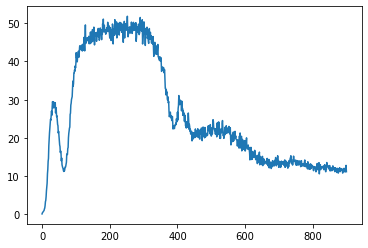

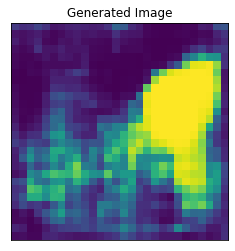

Iteration [901/10000]......0.118(s) gen: 9.75706 - disc_fake: -9.69101 - disc_real: 1.78865 - disc_real: 11.47966
Iteration [902/10000]......0.116(s) gen: 11.88968 - disc_fake: -10.50079 - disc_real: 1.08234 - disc_real: 11.58313
Iteration [903/10000]......0.115(s) gen: 9.29688 - disc_fake: -10.10504 - disc_real: 0.70979 - disc_real: 10.81483
Iteration [904/10000]......0.115(s) gen: 10.35482 - disc_fake: -9.93858 - disc_real: 1.60958 - disc_real: 11.54816
Iteration [905/10000]......0.116(s) gen: 8.58286 - disc_fake: -9.01057 - disc_real: 3.05587 - disc_real: 12.06644
Iteration [906/10000]......0.116(s) gen: 8.55778 - disc_fake: -9.81230 - disc_real: 1.51082 - disc_real: 11.32312
Iteration [907/10000]......0.116(s) gen: 7.45364 - disc_fake: -9.16367 - disc_real: 2.17437 - disc_real: 11.33804
Iteration [908/10000]......0.116(s) gen: 8.87050 - disc_fake: -9.72148 - disc_real: 2.31399 - disc_real: 12.03548
Iteration [909/10000]......0.116(s) gen: 8.69728 - disc_fake: -8.45106 - disc_real: 

Iteration [973/10000]......0.116(s) gen: 9.60867 - disc_fake: -8.61385 - disc_real: 2.70000 - disc_real: 11.31385
Iteration [974/10000]......0.116(s) gen: 11.77446 - disc_fake: -8.94152 - disc_real: 2.81931 - disc_real: 11.76083
Iteration [975/10000]......0.115(s) gen: 9.67777 - disc_fake: -8.69390 - disc_real: 2.66451 - disc_real: 11.35840
Iteration [976/10000]......0.115(s) gen: 8.07806 - disc_fake: -7.80683 - disc_real: 3.73154 - disc_real: 11.53836
Iteration [977/10000]......0.116(s) gen: 7.78903 - disc_fake: -8.14658 - disc_real: 3.27924 - disc_real: 11.42582
Iteration [978/10000]......0.116(s) gen: 7.14872 - disc_fake: -8.62612 - disc_real: 2.53913 - disc_real: 11.16525
Iteration [979/10000]......0.116(s) gen: 8.97236 - disc_fake: -8.03708 - disc_real: 3.65968 - disc_real: 11.69677
Iteration [980/10000]......0.115(s) gen: 9.62193 - disc_fake: -7.93589 - disc_real: 2.80243 - disc_real: 10.73832
Iteration [981/10000]......0.117(s) gen: 10.44537 - disc_fake: -9.22463 - disc_real: 1.

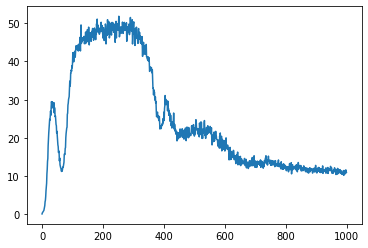

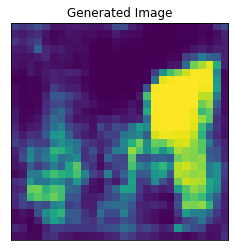

Iteration [1001/10000]......0.117(s) gen: 8.33450 - disc_fake: -8.50924 - disc_real: 1.72095 - disc_real: 10.23019
Iteration [1002/10000]......0.114(s) gen: 6.91235 - disc_fake: -7.81811 - disc_real: 3.12941 - disc_real: 10.94753
Iteration [1003/10000]......0.116(s) gen: 7.29673 - disc_fake: -7.13257 - disc_real: 4.26781 - disc_real: 11.40038
Iteration [1004/10000]......0.117(s) gen: 7.22976 - disc_fake: -7.59727 - disc_real: 3.43303 - disc_real: 11.03031
Iteration [1005/10000]......0.114(s) gen: 7.88464 - disc_fake: -8.15232 - disc_real: 3.46230 - disc_real: 11.61463
Iteration [1006/10000]......0.115(s) gen: 7.54052 - disc_fake: -8.47696 - disc_real: 2.59543 - disc_real: 11.07239
Iteration [1007/10000]......0.115(s) gen: 7.17880 - disc_fake: -8.65218 - disc_real: 2.86812 - disc_real: 11.52029
Iteration [1008/10000]......0.116(s) gen: 8.72074 - disc_fake: -8.88451 - disc_real: 2.73704 - disc_real: 11.62155
Iteration [1009/10000]......0.115(s) gen: 8.34302 - disc_fake: -8.09303 - disc_r

Iteration [1073/10000]......0.118(s) gen: 7.43116 - disc_fake: -6.62446 - disc_real: 4.26009 - disc_real: 10.88455
Iteration [1074/10000]......0.119(s) gen: 6.06402 - disc_fake: -7.79840 - disc_real: 3.45344 - disc_real: 11.25184
Iteration [1075/10000]......0.119(s) gen: 4.94176 - disc_fake: -6.43212 - disc_real: 4.00945 - disc_real: 10.44157
Iteration [1076/10000]......0.119(s) gen: 6.40238 - disc_fake: -6.52240 - disc_real: 4.21950 - disc_real: 10.74190
Iteration [1077/10000]......0.118(s) gen: 6.15689 - disc_fake: -6.39193 - disc_real: 4.34559 - disc_real: 10.73752
Iteration [1078/10000]......0.117(s) gen: 5.75419 - disc_fake: -4.75532 - disc_real: 5.47030 - disc_real: 10.22562
Iteration [1079/10000]......0.117(s) gen: 7.48908 - disc_fake: -6.24682 - disc_real: 5.24501 - disc_real: 11.49183
Iteration [1080/10000]......0.116(s) gen: 6.68709 - disc_fake: -6.91360 - disc_real: 3.85405 - disc_real: 10.76764
Iteration [1081/10000]......0.116(s) gen: 7.45231 - disc_fake: -7.29140 - disc_r

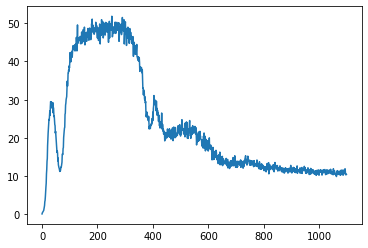

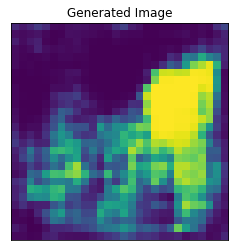

Iteration [1101/10000]......0.119(s) gen: 8.30436 - disc_fake: -6.44650 - disc_real: 3.81301 - disc_real: 10.25952
Iteration [1102/10000]......0.117(s) gen: 7.57678 - disc_fake: -8.10437 - disc_real: 2.57320 - disc_real: 10.67757
Iteration [1103/10000]......0.116(s) gen: 4.24289 - disc_fake: -6.20235 - disc_real: 4.28818 - disc_real: 10.49053
Iteration [1104/10000]......0.114(s) gen: 5.52986 - disc_fake: -6.08654 - disc_real: 4.68566 - disc_real: 10.77220
Iteration [1105/10000]......0.117(s) gen: 7.02574 - disc_fake: -7.00408 - disc_real: 3.34837 - disc_real: 10.35245
Iteration [1106/10000]......0.117(s) gen: 6.15105 - disc_fake: -6.57416 - disc_real: 3.74131 - disc_real: 10.31547
Iteration [1107/10000]......0.116(s) gen: 6.16399 - disc_fake: -7.08857 - disc_real: 3.62628 - disc_real: 10.71484
Iteration [1108/10000]......0.116(s) gen: 6.16376 - disc_fake: -6.60875 - disc_real: 3.78553 - disc_real: 10.39428
Iteration [1109/10000]......0.116(s) gen: 7.23155 - disc_fake: -6.44265 - disc_r

Iteration [1173/10000]......0.121(s) gen: 7.49447 - disc_fake: -6.86060 - disc_real: 3.80468 - disc_real: 10.66528
Iteration [1174/10000]......0.118(s) gen: 5.97313 - disc_fake: -7.42631 - disc_real: 2.90621 - disc_real: 10.33252
Iteration [1175/10000]......0.121(s) gen: 7.74664 - disc_fake: -5.70753 - disc_real: 5.18571 - disc_real: 10.89325
Iteration [1176/10000]......0.122(s) gen: 5.17749 - disc_fake: -8.20371 - disc_real: 2.21667 - disc_real: 10.42038
Iteration [1177/10000]......0.118(s) gen: 6.89487 - disc_fake: -7.45465 - disc_real: 3.86842 - disc_real: 11.32307
Iteration [1178/10000]......0.118(s) gen: 8.22876 - disc_fake: -7.56118 - disc_real: 3.26056 - disc_real: 10.82174
Iteration [1179/10000]......0.118(s) gen: 6.57850 - disc_fake: -6.40757 - disc_real: 3.61459 - disc_real: 10.02216
Iteration [1180/10000]......0.121(s) gen: 8.08821 - disc_fake: -7.98555 - disc_real: 2.79731 - disc_real: 10.78286
Iteration [1181/10000]......0.121(s) gen: 6.28058 - disc_fake: -6.92859 - disc_r

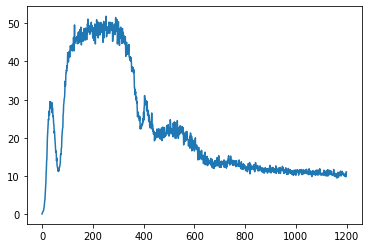

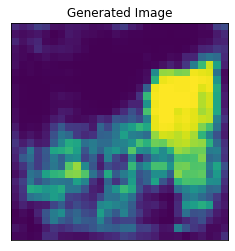

Iteration [1201/10000]......0.123(s) gen: 7.91087 - disc_fake: -5.31281 - disc_real: 5.09911 - disc_real: 10.41192
Iteration [1202/10000]......0.131(s) gen: 7.11016 - disc_fake: -6.17973 - disc_real: 3.72797 - disc_real: 9.90770
Iteration [1203/10000]......0.136(s) gen: 5.66172 - disc_fake: -6.85078 - disc_real: 3.71808 - disc_real: 10.56886
Iteration [1204/10000]......0.134(s) gen: 6.61373 - disc_fake: -6.57630 - disc_real: 3.40282 - disc_real: 9.97912
Iteration [1205/10000]......0.136(s) gen: 6.94120 - disc_fake: -7.97719 - disc_real: 2.88366 - disc_real: 10.86085
Iteration [1206/10000]......0.141(s) gen: 7.90753 - disc_fake: -6.30552 - disc_real: 3.47107 - disc_real: 9.77659
Iteration [1207/10000]......0.135(s) gen: 8.09478 - disc_fake: -7.18551 - disc_real: 4.17181 - disc_real: 11.35732
Iteration [1208/10000]......0.135(s) gen: 7.59560 - disc_fake: -7.69133 - disc_real: 2.77051 - disc_real: 10.46183
Iteration [1209/10000]......0.135(s) gen: 7.08055 - disc_fake: -6.14360 - disc_real

Iteration [1274/10000]......0.119(s) gen: 4.34315 - disc_fake: -6.68707 - disc_real: 4.04030 - disc_real: 10.72737
Iteration [1275/10000]......0.119(s) gen: 6.84922 - disc_fake: -5.18512 - disc_real: 4.50641 - disc_real: 9.69153
Iteration [1276/10000]......0.127(s) gen: 6.97136 - disc_fake: -6.80984 - disc_real: 3.64747 - disc_real: 10.45731
Iteration [1277/10000]......0.119(s) gen: 6.79810 - disc_fake: -6.39035 - disc_real: 4.13324 - disc_real: 10.52359
Iteration [1278/10000]......0.121(s) gen: 6.41238 - disc_fake: -6.66208 - disc_real: 3.39726 - disc_real: 10.05934
Iteration [1279/10000]......0.119(s) gen: 6.40771 - disc_fake: -6.11774 - disc_real: 3.78151 - disc_real: 9.89924
Iteration [1280/10000]......0.119(s) gen: 6.59985 - disc_fake: -5.42211 - disc_real: 4.46337 - disc_real: 9.88548
Iteration [1281/10000]......0.118(s) gen: 5.61718 - disc_fake: -6.18342 - disc_real: 3.63296 - disc_real: 9.81638
Iteration [1282/10000]......0.119(s) gen: 6.83010 - disc_fake: -6.51409 - disc_real:

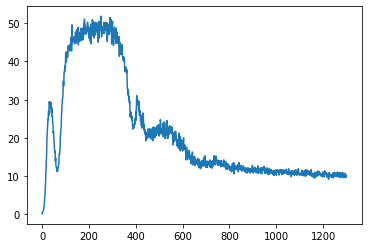

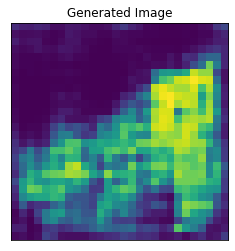

Iteration [1301/10000]......0.121(s) gen: 6.13639 - disc_fake: -6.65553 - disc_real: 3.69702 - disc_real: 10.35255
Iteration [1302/10000]......0.118(s) gen: 5.96518 - disc_fake: -5.58757 - disc_real: 4.56065 - disc_real: 10.14822
Iteration [1303/10000]......0.116(s) gen: 6.99865 - disc_fake: -5.14013 - disc_real: 5.59984 - disc_real: 10.73997
Iteration [1304/10000]......0.117(s) gen: 7.29944 - disc_fake: -6.13287 - disc_real: 3.98501 - disc_real: 10.11788
Iteration [1305/10000]......0.116(s) gen: 4.92222 - disc_fake: -5.35812 - disc_real: 4.15849 - disc_real: 9.51662
Iteration [1306/10000]......0.117(s) gen: 6.49660 - disc_fake: -5.68488 - disc_real: 4.42366 - disc_real: 10.10854
Iteration [1307/10000]......0.117(s) gen: 6.22357 - disc_fake: -6.12945 - disc_real: 4.04842 - disc_real: 10.17788
Iteration [1308/10000]......0.116(s) gen: 5.93657 - disc_fake: -6.38301 - disc_real: 3.62862 - disc_real: 10.01162
Iteration [1309/10000]......0.116(s) gen: 7.39126 - disc_fake: -6.54473 - disc_re

Iteration [1373/10000]......0.115(s) gen: 4.29707 - disc_fake: -5.88428 - disc_real: 4.70248 - disc_real: 10.58675
Iteration [1374/10000]......0.116(s) gen: 5.09726 - disc_fake: -4.74573 - disc_real: 5.06214 - disc_real: 9.80788
Iteration [1375/10000]......0.115(s) gen: 5.63306 - disc_fake: -5.14395 - disc_real: 4.08389 - disc_real: 9.22783
Iteration [1376/10000]......0.116(s) gen: 4.63186 - disc_fake: -5.00197 - disc_real: 4.37527 - disc_real: 9.37725
Iteration [1377/10000]......0.115(s) gen: 5.42281 - disc_fake: -5.02479 - disc_real: 4.97833 - disc_real: 10.00312
Iteration [1378/10000]......0.116(s) gen: 4.74395 - disc_fake: -4.48796 - disc_real: 4.44809 - disc_real: 8.93605
Iteration [1379/10000]......0.121(s) gen: 5.30898 - disc_fake: -5.33322 - disc_real: 4.32017 - disc_real: 9.65339
Iteration [1380/10000]......0.120(s) gen: 4.48701 - disc_fake: -4.73982 - disc_real: 5.23080 - disc_real: 9.97062
Iteration [1381/10000]......0.120(s) gen: 5.17081 - disc_fake: -5.61083 - disc_real: 4

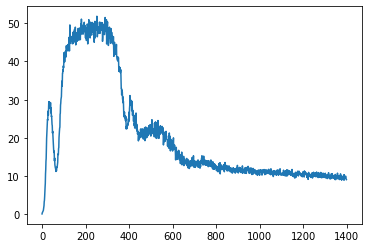

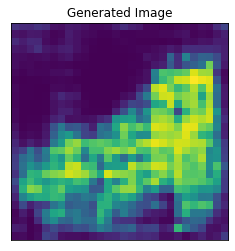

Iteration [1401/10000]......0.116(s) gen: 5.50850 - disc_fake: -5.57589 - disc_real: 4.36238 - disc_real: 9.93826
Iteration [1402/10000]......0.114(s) gen: 6.09901 - disc_fake: -4.77962 - disc_real: 4.47384 - disc_real: 9.25347
Iteration [1403/10000]......0.115(s) gen: 5.69845 - disc_fake: -4.81801 - disc_real: 4.87275 - disc_real: 9.69076
Iteration [1404/10000]......0.116(s) gen: 5.94815 - disc_fake: -5.95038 - disc_real: 3.73969 - disc_real: 9.69007
Iteration [1405/10000]......0.117(s) gen: 4.70410 - disc_fake: -6.52681 - disc_real: 2.98294 - disc_real: 9.50975
Iteration [1406/10000]......0.116(s) gen: 6.46585 - disc_fake: -5.59080 - disc_real: 4.31429 - disc_real: 9.90509
Iteration [1407/10000]......0.116(s) gen: 4.55290 - disc_fake: -5.70416 - disc_real: 3.61554 - disc_real: 9.31971
Iteration [1408/10000]......0.113(s) gen: 5.73749 - disc_fake: -5.25973 - disc_real: 4.13635 - disc_real: 9.39608
Iteration [1409/10000]......0.117(s) gen: 6.61673 - disc_fake: -4.64226 - disc_real: 4.9

Iteration [1474/10000]......0.118(s) gen: 4.48973 - disc_fake: -4.02040 - disc_real: 5.08346 - disc_real: 9.10386
Iteration [1475/10000]......0.119(s) gen: 3.96656 - disc_fake: -4.37148 - disc_real: 4.94780 - disc_real: 9.31928
Iteration [1476/10000]......0.120(s) gen: 4.52932 - disc_fake: -3.81609 - disc_real: 5.54253 - disc_real: 9.35862
Iteration [1477/10000]......0.119(s) gen: 4.24495 - disc_fake: -4.51047 - disc_real: 4.79832 - disc_real: 9.30879
Iteration [1478/10000]......0.122(s) gen: 4.83664 - disc_fake: -4.68996 - disc_real: 3.96153 - disc_real: 8.65149
Iteration [1479/10000]......0.119(s) gen: 4.86125 - disc_fake: -4.36501 - disc_real: 5.54283 - disc_real: 9.90783
Iteration [1480/10000]......0.119(s) gen: 4.63967 - disc_fake: -4.94493 - disc_real: 4.47142 - disc_real: 9.41635
Iteration [1481/10000]......0.119(s) gen: 4.16871 - disc_fake: -5.13166 - disc_real: 3.90377 - disc_real: 9.03544
Iteration [1482/10000]......0.119(s) gen: 4.41385 - disc_fake: -4.52068 - disc_real: 5.0

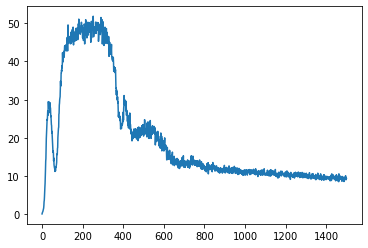

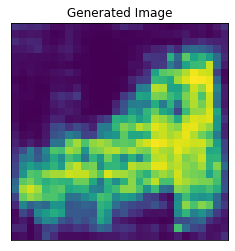

Iteration [1501/10000]......0.117(s) gen: 3.76251 - disc_fake: -4.50901 - disc_real: 4.81811 - disc_real: 9.32712
Iteration [1502/10000]......0.116(s) gen: 5.75328 - disc_fake: -4.15909 - disc_real: 5.31678 - disc_real: 9.47587
Iteration [1503/10000]......0.116(s) gen: 5.52496 - disc_fake: -4.99623 - disc_real: 4.44128 - disc_real: 9.43752
Iteration [1504/10000]......0.115(s) gen: 4.20666 - disc_fake: -4.52836 - disc_real: 4.57291 - disc_real: 9.10127
Iteration [1505/10000]......0.115(s) gen: 4.47590 - disc_fake: -4.62461 - disc_real: 5.01741 - disc_real: 9.64202
Iteration [1506/10000]......0.115(s) gen: 4.78498 - disc_fake: -4.88743 - disc_real: 3.96937 - disc_real: 8.85680
Iteration [1507/10000]......0.116(s) gen: 4.12627 - disc_fake: -4.50849 - disc_real: 4.76381 - disc_real: 9.27230
Iteration [1508/10000]......0.115(s) gen: 4.35761 - disc_fake: -4.33087 - disc_real: 4.28153 - disc_real: 8.61240
Iteration [1509/10000]......0.116(s) gen: 4.91199 - disc_fake: -4.40882 - disc_real: 4.7

Iteration [1573/10000]......0.118(s) gen: 2.36139 - disc_fake: -3.84034 - disc_real: 5.52837 - disc_real: 9.36871
Iteration [1574/10000]......0.118(s) gen: 5.38213 - disc_fake: -3.16611 - disc_real: 5.98774 - disc_real: 9.15385
Iteration [1575/10000]......0.115(s) gen: 3.84006 - disc_fake: -3.29752 - disc_real: 4.67526 - disc_real: 7.97278
Iteration [1576/10000]......0.117(s) gen: 2.68110 - disc_fake: -3.30833 - disc_real: 5.36546 - disc_real: 8.67379
Iteration [1577/10000]......0.119(s) gen: 3.04245 - disc_fake: -2.79368 - disc_real: 6.19011 - disc_real: 8.98380
Iteration [1578/10000]......0.118(s) gen: 2.80853 - disc_fake: -2.86108 - disc_real: 6.45871 - disc_real: 9.31979
Iteration [1579/10000]......0.116(s) gen: 4.25787 - disc_fake: -3.10485 - disc_real: 6.14441 - disc_real: 9.24926
Iteration [1580/10000]......0.117(s) gen: 3.30284 - disc_fake: -3.79404 - disc_real: 5.20575 - disc_real: 8.99978
Iteration [1581/10000]......0.118(s) gen: 2.26274 - disc_fake: -2.04594 - disc_real: 6.1

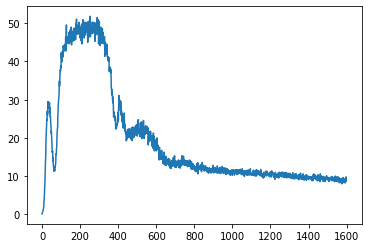

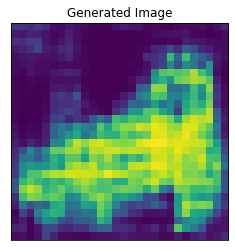

Iteration [1601/10000]......0.120(s) gen: 3.84141 - disc_fake: -3.25962 - disc_real: 5.87244 - disc_real: 9.13206
Iteration [1602/10000]......0.116(s) gen: 3.08223 - disc_fake: -3.19976 - disc_real: 5.80636 - disc_real: 9.00613
Iteration [1603/10000]......0.116(s) gen: 3.65101 - disc_fake: -4.13941 - disc_real: 4.25869 - disc_real: 8.39810
Iteration [1604/10000]......0.115(s) gen: 3.98154 - disc_fake: -3.33909 - disc_real: 5.69450 - disc_real: 9.03358
Iteration [1605/10000]......0.116(s) gen: 5.55822 - disc_fake: -4.35494 - disc_real: 5.36745 - disc_real: 9.72239
Iteration [1606/10000]......0.115(s) gen: 4.22924 - disc_fake: -3.99201 - disc_real: 4.39455 - disc_real: 8.38656
Iteration [1607/10000]......0.115(s) gen: 5.21579 - disc_fake: -3.88841 - disc_real: 4.59202 - disc_real: 8.48043
Iteration [1608/10000]......0.117(s) gen: 4.17506 - disc_fake: -3.96616 - disc_real: 4.91279 - disc_real: 8.87895
Iteration [1609/10000]......0.116(s) gen: 5.12666 - disc_fake: -3.58402 - disc_real: 5.2

Iteration [1674/10000]......0.121(s) gen: 2.78816 - disc_fake: -3.81434 - disc_real: 4.83924 - disc_real: 8.65359
Iteration [1675/10000]......0.120(s) gen: 4.63379 - disc_fake: -4.24974 - disc_real: 4.76783 - disc_real: 9.01757
Iteration [1676/10000]......0.121(s) gen: 2.06166 - disc_fake: -3.33277 - disc_real: 4.80280 - disc_real: 8.13557
Iteration [1677/10000]......0.120(s) gen: 3.17202 - disc_fake: -2.80473 - disc_real: 5.25874 - disc_real: 8.06347
Iteration [1678/10000]......0.119(s) gen: 2.71714 - disc_fake: -3.00790 - disc_real: 5.28189 - disc_real: 8.28980
Iteration [1679/10000]......0.118(s) gen: 2.80955 - disc_fake: -3.03593 - disc_real: 5.65224 - disc_real: 8.68818
Iteration [1680/10000]......0.118(s) gen: 2.49968 - disc_fake: -2.80136 - disc_real: 5.93887 - disc_real: 8.74023
Iteration [1681/10000]......0.118(s) gen: 3.17300 - disc_fake: -3.06173 - disc_real: 5.58717 - disc_real: 8.64891
Iteration [1682/10000]......0.120(s) gen: 2.41933 - disc_fake: -2.90997 - disc_real: 5.4

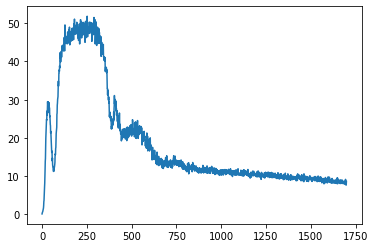

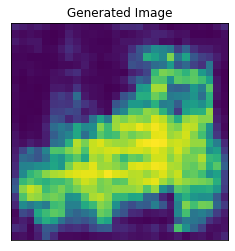

Iteration [1701/10000]......0.117(s) gen: 2.33895 - disc_fake: -1.51827 - disc_real: 6.15953 - disc_real: 7.67780
Iteration [1702/10000]......0.117(s) gen: 2.09262 - disc_fake: -3.48917 - disc_real: 5.10108 - disc_real: 8.59025
Iteration [1703/10000]......0.119(s) gen: 3.68286 - disc_fake: -2.44258 - disc_real: 5.83851 - disc_real: 8.28109
Iteration [1704/10000]......0.116(s) gen: 3.14625 - disc_fake: -3.18857 - disc_real: 4.57756 - disc_real: 7.76614
Iteration [1705/10000]......0.116(s) gen: 2.12498 - disc_fake: -2.92375 - disc_real: 4.99868 - disc_real: 7.92243
Iteration [1706/10000]......0.118(s) gen: 1.30315 - disc_fake: -2.60789 - disc_real: 5.43632 - disc_real: 8.04420
Iteration [1707/10000]......0.113(s) gen: 2.65147 - disc_fake: -2.00231 - disc_real: 6.62237 - disc_real: 8.62468
Iteration [1708/10000]......0.117(s) gen: 3.73274 - disc_fake: -2.64401 - disc_real: 6.14675 - disc_real: 8.79076
Iteration [1709/10000]......0.117(s) gen: 3.92496 - disc_fake: -2.88845 - disc_real: 5.7

Iteration [1774/10000]......0.117(s) gen: 2.00635 - disc_fake: -1.12224 - disc_real: 6.52634 - disc_real: 7.64858
Iteration [1775/10000]......0.118(s) gen: 1.32899 - disc_fake: -1.98902 - disc_real: 6.16874 - disc_real: 8.15776
Iteration [1776/10000]......0.117(s) gen: 3.56836 - disc_fake: -1.50648 - disc_real: 5.74782 - disc_real: 7.25430
Iteration [1777/10000]......0.117(s) gen: 1.63194 - disc_fake: -2.36885 - disc_real: 5.62566 - disc_real: 7.99451
Iteration [1778/10000]......0.118(s) gen: 3.23511 - disc_fake: -2.07530 - disc_real: 6.09419 - disc_real: 8.16949
Iteration [1779/10000]......0.118(s) gen: 2.56458 - disc_fake: -2.04924 - disc_real: 5.93915 - disc_real: 7.98840
Iteration [1780/10000]......0.118(s) gen: 1.00531 - disc_fake: -1.17014 - disc_real: 6.89704 - disc_real: 8.06718
Iteration [1781/10000]......0.117(s) gen: 0.80026 - disc_fake: -1.64721 - disc_real: 6.52119 - disc_real: 8.16839
Iteration [1782/10000]......0.120(s) gen: 1.93391 - disc_fake: -1.60737 - disc_real: 6.1

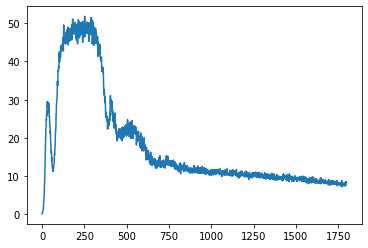

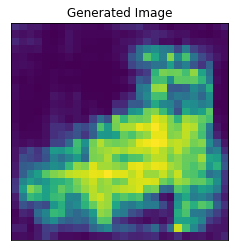

Iteration [1801/10000]......0.123(s) gen: 1.54917 - disc_fake: -1.95522 - disc_real: 6.18548 - disc_real: 8.14070
Iteration [1802/10000]......0.115(s) gen: 1.26312 - disc_fake: -1.57288 - disc_real: 6.49701 - disc_real: 8.06988
Iteration [1803/10000]......0.116(s) gen: 2.08638 - disc_fake: -1.70827 - disc_real: 5.59937 - disc_real: 7.30764
Iteration [1804/10000]......0.117(s) gen: 1.41050 - disc_fake: -1.73811 - disc_real: 5.82504 - disc_real: 7.56315
Iteration [1805/10000]......0.114(s) gen: 2.08085 - disc_fake: -2.07269 - disc_real: 6.41945 - disc_real: 8.49214
Iteration [1806/10000]......0.115(s) gen: 2.58497 - disc_fake: -2.81869 - disc_real: 5.46789 - disc_real: 8.28658
Iteration [1807/10000]......0.114(s) gen: 2.77201 - disc_fake: -1.75169 - disc_real: 6.70356 - disc_real: 8.45525
Iteration [1808/10000]......0.115(s) gen: 1.91798 - disc_fake: -2.48109 - disc_real: 5.63125 - disc_real: 8.11233
Iteration [1809/10000]......0.118(s) gen: 1.73007 - disc_fake: -1.50264 - disc_real: 6.4

Iteration [1873/10000]......0.119(s) gen: 2.10990 - disc_fake: -1.45288 - disc_real: 6.41832 - disc_real: 7.87120
Iteration [1874/10000]......0.119(s) gen: 1.04532 - disc_fake: -1.75095 - disc_real: 6.12114 - disc_real: 7.87209
Iteration [1875/10000]......0.119(s) gen: 2.05599 - disc_fake: -2.38756 - disc_real: 5.70667 - disc_real: 8.09424
Iteration [1876/10000]......0.118(s) gen: 2.32481 - disc_fake: -1.54285 - disc_real: 5.82436 - disc_real: 7.36721
Iteration [1877/10000]......0.119(s) gen: 2.54108 - disc_fake: -2.51265 - disc_real: 6.05199 - disc_real: 8.56464
Iteration [1878/10000]......0.118(s) gen: 2.88105 - disc_fake: -2.27560 - disc_real: 5.86108 - disc_real: 8.13668
Iteration [1879/10000]......0.123(s) gen: 2.74237 - disc_fake: -2.87063 - disc_real: 4.39599 - disc_real: 7.26662
Iteration [1880/10000]......0.117(s) gen: 1.97411 - disc_fake: -2.11295 - disc_real: 5.66196 - disc_real: 7.77490
Iteration [1881/10000]......0.117(s) gen: 1.43212 - disc_fake: -1.16760 - disc_real: 6.0

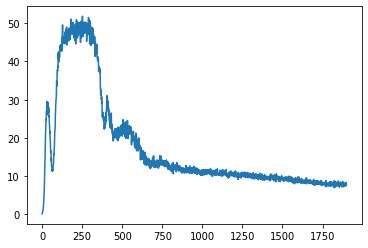

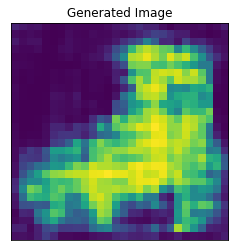

Iteration [1901/10000]......0.117(s) gen: 2.77752 - disc_fake: -2.28362 - disc_real: 5.18168 - disc_real: 7.46530
Iteration [1902/10000]......0.114(s) gen: 3.04677 - disc_fake: -2.73825 - disc_real: 4.70693 - disc_real: 7.44518
Iteration [1903/10000]......0.116(s) gen: 2.82717 - disc_fake: -2.62347 - disc_real: 4.65270 - disc_real: 7.27617
Iteration [1904/10000]......0.117(s) gen: 2.25449 - disc_fake: -2.82685 - disc_real: 4.54240 - disc_real: 7.36925
Iteration [1905/10000]......0.118(s) gen: 3.27951 - disc_fake: -2.21216 - disc_real: 5.80172 - disc_real: 8.01388
Iteration [1906/10000]......0.118(s) gen: 3.12918 - disc_fake: -2.87412 - disc_real: 5.59235 - disc_real: 8.46647
Iteration [1907/10000]......0.118(s) gen: 2.59365 - disc_fake: -2.22304 - disc_real: 4.75784 - disc_real: 6.98089
Iteration [1908/10000]......0.119(s) gen: 0.23814 - disc_fake: -2.03501 - disc_real: 5.15503 - disc_real: 7.19005
Iteration [1909/10000]......0.117(s) gen: 2.42722 - disc_fake: -1.54451 - disc_real: 5.7

Iteration [1974/10000]......0.117(s) gen: 2.23055 - disc_fake: -1.30370 - disc_real: 6.23969 - disc_real: 7.54339
Iteration [1975/10000]......0.117(s) gen: 2.19262 - disc_fake: -1.91160 - disc_real: 5.84613 - disc_real: 7.75773
Iteration [1976/10000]......0.117(s) gen: 1.02203 - disc_fake: -1.29275 - disc_real: 6.33349 - disc_real: 7.62624
Iteration [1977/10000]......0.116(s) gen: 0.78184 - disc_fake: -1.50186 - disc_real: 5.95692 - disc_real: 7.45878
Iteration [1978/10000]......0.116(s) gen: 3.44395 - disc_fake: -2.11429 - disc_real: 5.78817 - disc_real: 7.90246
Iteration [1979/10000]......0.118(s) gen: 1.66812 - disc_fake: -2.27045 - disc_real: 5.14115 - disc_real: 7.41160
Iteration [1980/10000]......0.119(s) gen: 0.61496 - disc_fake: -2.25060 - disc_real: 4.94642 - disc_real: 7.19702
Iteration [1981/10000]......0.119(s) gen: 1.76021 - disc_fake: -1.01346 - disc_real: 5.91398 - disc_real: 6.92744
Iteration [1982/10000]......0.120(s) gen: 3.02127 - disc_fake: -1.55610 - disc_real: 5.7

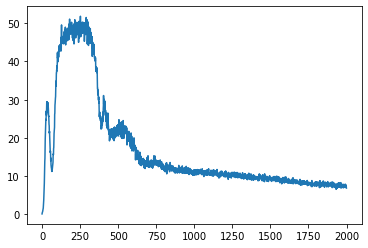

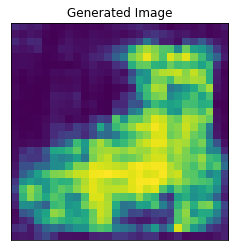

checkpointing at epoch: 2000
Iteration [2001/10000]......0.135(s) gen: 1.47176 - disc_fake: -1.07899 - disc_real: 6.09415 - disc_real: 7.17314
Iteration [2002/10000]......0.130(s) gen: 1.24322 - disc_fake: -0.95727 - disc_real: 6.47060 - disc_real: 7.42787
Iteration [2003/10000]......0.125(s) gen: 2.15154 - disc_fake: -1.55899 - disc_real: 5.57436 - disc_real: 7.13335
Iteration [2004/10000]......0.119(s) gen: 1.83825 - disc_fake: -1.73586 - disc_real: 5.87369 - disc_real: 7.60955
Iteration [2005/10000]......0.117(s) gen: 1.70188 - disc_fake: -1.04934 - disc_real: 5.95527 - disc_real: 7.00461
Iteration [2006/10000]......0.117(s) gen: 1.67044 - disc_fake: -1.46414 - disc_real: 5.56586 - disc_real: 7.03001
Iteration [2007/10000]......0.115(s) gen: 2.52769 - disc_fake: -2.09851 - disc_real: 5.93308 - disc_real: 8.03159
Iteration [2008/10000]......0.114(s) gen: 1.13756 - disc_fake: -1.95494 - disc_real: 5.67350 - disc_real: 7.62844
Iteration [2009/10000]......0.115(s) gen: 1.59961 - disc_fa

Iteration [2073/10000]......0.119(s) gen: -0.11196 - disc_fake: -0.87491 - disc_real: 6.24602 - disc_real: 7.12094
Iteration [2074/10000]......0.120(s) gen: 2.30836 - disc_fake: -0.93326 - disc_real: 5.82105 - disc_real: 6.75431
Iteration [2075/10000]......0.121(s) gen: 1.06221 - disc_fake: -1.08078 - disc_real: 6.25190 - disc_real: 7.33268
Iteration [2076/10000]......0.120(s) gen: 2.60082 - disc_fake: -1.04217 - disc_real: 5.61075 - disc_real: 6.65291
Iteration [2077/10000]......0.121(s) gen: 1.31659 - disc_fake: -1.57114 - disc_real: 5.55992 - disc_real: 7.13106
Iteration [2078/10000]......0.119(s) gen: 1.79784 - disc_fake: -1.53586 - disc_real: 5.67338 - disc_real: 7.20924
Iteration [2079/10000]......0.120(s) gen: 1.41486 - disc_fake: -1.97968 - disc_real: 4.92127 - disc_real: 6.90096
Iteration [2080/10000]......0.119(s) gen: 1.94765 - disc_fake: -1.21829 - disc_real: 5.96740 - disc_real: 7.18569
Iteration [2081/10000]......0.118(s) gen: 0.88009 - disc_fake: -1.47395 - disc_real: 5.

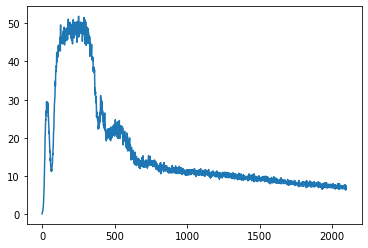

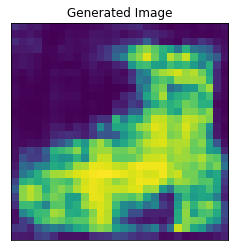

Iteration [2101/10000]......0.115(s) gen: 1.52430 - disc_fake: -1.22791 - disc_real: 5.97351 - disc_real: 7.20142
Iteration [2102/10000]......0.116(s) gen: 1.55957 - disc_fake: -0.82955 - disc_real: 6.50541 - disc_real: 7.33496
Iteration [2103/10000]......0.115(s) gen: 3.06041 - disc_fake: -1.39429 - disc_real: 5.65101 - disc_real: 7.04530
Iteration [2104/10000]......0.115(s) gen: 0.97309 - disc_fake: -1.41024 - disc_real: 5.69682 - disc_real: 7.10706
Iteration [2105/10000]......0.116(s) gen: 1.44283 - disc_fake: -1.27906 - disc_real: 6.12295 - disc_real: 7.40201
Iteration [2106/10000]......0.116(s) gen: 1.71356 - disc_fake: -1.28404 - disc_real: 6.14098 - disc_real: 7.42501
Iteration [2107/10000]......0.116(s) gen: 0.91716 - disc_fake: -0.81231 - disc_real: 6.30385 - disc_real: 7.11616
Iteration [2108/10000]......0.115(s) gen: 1.45856 - disc_fake: -1.39154 - disc_real: 5.41352 - disc_real: 6.80506
Iteration [2109/10000]......0.116(s) gen: 0.38659 - disc_fake: -1.01297 - disc_real: 5.6

Iteration [2174/10000]......0.124(s) gen: 1.31009 - disc_fake: -1.36997 - disc_real: 5.62458 - disc_real: 6.99455
Iteration [2175/10000]......0.121(s) gen: 2.57516 - disc_fake: -0.77370 - disc_real: 6.33052 - disc_real: 7.10422
Iteration [2176/10000]......0.119(s) gen: 1.22807 - disc_fake: -1.45745 - disc_real: 5.48662 - disc_real: 6.94407
Iteration [2177/10000]......0.117(s) gen: 0.71373 - disc_fake: -0.97716 - disc_real: 6.16136 - disc_real: 7.13852
Iteration [2178/10000]......0.118(s) gen: 0.23837 - disc_fake: -0.85582 - disc_real: 5.88779 - disc_real: 6.74362
Iteration [2179/10000]......0.118(s) gen: -1.06660 - disc_fake: 0.50547 - disc_real: 7.16189 - disc_real: 6.65643
Iteration [2180/10000]......0.122(s) gen: 1.46667 - disc_fake: -0.04506 - disc_real: 7.14451 - disc_real: 7.18957
Iteration [2181/10000]......0.122(s) gen: 1.90968 - disc_fake: -0.14877 - disc_real: 6.63237 - disc_real: 6.78114
Iteration [2182/10000]......0.121(s) gen: 0.57772 - disc_fake: -0.52038 - disc_real: 5.7

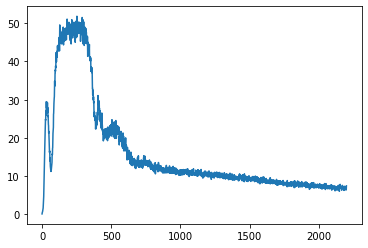

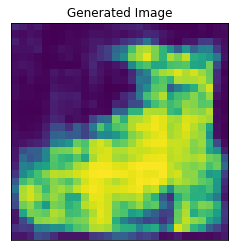

Iteration [2201/10000]......0.123(s) gen: -0.03031 - disc_fake: -1.04330 - disc_real: 5.30573 - disc_real: 6.34903
Iteration [2202/10000]......0.133(s) gen: 0.29147 - disc_fake: -0.17859 - disc_real: 6.70880 - disc_real: 6.88738
Iteration [2203/10000]......0.135(s) gen: 0.73479 - disc_fake: -0.67759 - disc_real: 6.24845 - disc_real: 6.92604
Iteration [2204/10000]......0.137(s) gen: 1.60260 - disc_fake: -1.05063 - disc_real: 6.28685 - disc_real: 7.33748
Iteration [2205/10000]......0.137(s) gen: 2.89130 - disc_fake: -1.21065 - disc_real: 5.91974 - disc_real: 7.13040
Iteration [2206/10000]......0.135(s) gen: 1.36271 - disc_fake: -2.92921 - disc_real: 4.10829 - disc_real: 7.03750
Iteration [2207/10000]......0.134(s) gen: 1.96335 - disc_fake: -1.30038 - disc_real: 5.58230 - disc_real: 6.88268
Iteration [2208/10000]......0.136(s) gen: 2.15394 - disc_fake: -1.56951 - disc_real: 5.29648 - disc_real: 6.86599
Iteration [2209/10000]......0.139(s) gen: 1.93958 - disc_fake: -1.88863 - disc_real: 5.

Iteration [2273/10000]......0.119(s) gen: 1.08688 - disc_fake: -2.27530 - disc_real: 4.66717 - disc_real: 6.94246
Iteration [2274/10000]......0.118(s) gen: 1.18280 - disc_fake: -1.21110 - disc_real: 5.74128 - disc_real: 6.95238
Iteration [2275/10000]......0.120(s) gen: 1.23399 - disc_fake: -0.79914 - disc_real: 6.55427 - disc_real: 7.35340
Iteration [2276/10000]......0.121(s) gen: -0.24664 - disc_fake: -0.83305 - disc_real: 5.75846 - disc_real: 6.59151
Iteration [2277/10000]......0.120(s) gen: 0.24145 - disc_fake: 0.01099 - disc_real: 6.67441 - disc_real: 6.66342
Iteration [2278/10000]......0.122(s) gen: -0.53235 - disc_fake: -0.82085 - disc_real: 6.28574 - disc_real: 7.10659
Iteration [2279/10000]......0.123(s) gen: 1.20168 - disc_fake: 0.42618 - disc_real: 7.07816 - disc_real: 6.65198
Iteration [2280/10000]......0.119(s) gen: 1.77849 - disc_fake: -1.57297 - disc_real: 4.88981 - disc_real: 6.46278
Iteration [2281/10000]......0.120(s) gen: 1.62630 - disc_fake: -1.40859 - disc_real: 5.2

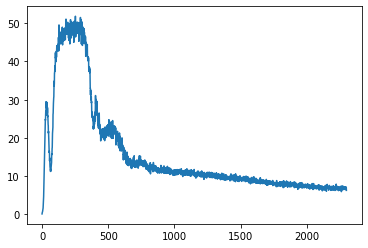

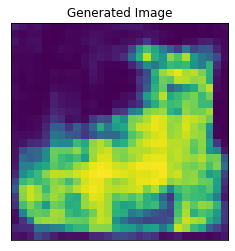

Iteration [2301/10000]......0.120(s) gen: 0.21276 - disc_fake: -1.21523 - disc_real: 5.49538 - disc_real: 6.71061
Iteration [2302/10000]......0.122(s) gen: 0.76779 - disc_fake: 0.14192 - disc_real: 6.76130 - disc_real: 6.61938
Iteration [2303/10000]......0.117(s) gen: -0.45540 - disc_fake: 0.26699 - disc_real: 6.73588 - disc_real: 6.46889
Iteration [2304/10000]......0.116(s) gen: 0.21348 - disc_fake: -0.17430 - disc_real: 6.42310 - disc_real: 6.59740
Iteration [2305/10000]......0.116(s) gen: -0.92930 - disc_fake: 0.13530 - disc_real: 6.86290 - disc_real: 6.72760
Iteration [2306/10000]......0.118(s) gen: 0.78795 - disc_fake: -0.39781 - disc_real: 6.67907 - disc_real: 7.07688
Iteration [2307/10000]......0.116(s) gen: 0.91895 - disc_fake: -0.60639 - disc_real: 6.09478 - disc_real: 6.70117
Iteration [2308/10000]......0.115(s) gen: 1.14798 - disc_fake: -0.45306 - disc_real: 5.97229 - disc_real: 6.42535
Iteration [2309/10000]......0.114(s) gen: 0.10694 - disc_fake: 0.00054 - disc_real: 6.513

Iteration [2374/10000]......0.119(s) gen: 0.10638 - disc_fake: -0.65373 - disc_real: 6.41438 - disc_real: 7.06811
Iteration [2375/10000]......0.119(s) gen: -1.01774 - disc_fake: 0.49203 - disc_real: 6.63389 - disc_real: 6.14186
Iteration [2376/10000]......0.119(s) gen: -1.41239 - disc_fake: 0.64647 - disc_real: 6.94340 - disc_real: 6.29693
Iteration [2377/10000]......0.119(s) gen: -0.54662 - disc_fake: 0.53799 - disc_real: 6.76791 - disc_real: 6.22992
Iteration [2378/10000]......0.122(s) gen: -1.43017 - disc_fake: 0.51501 - disc_real: 7.28182 - disc_real: 6.76681
Iteration [2379/10000]......0.119(s) gen: 0.33897 - disc_fake: 0.91511 - disc_real: 7.50822 - disc_real: 6.59311
Iteration [2380/10000]......0.121(s) gen: 0.64430 - disc_fake: -0.18042 - disc_real: 6.35944 - disc_real: 6.53986
Iteration [2381/10000]......0.122(s) gen: 1.01546 - disc_fake: -0.79192 - disc_real: 5.59014 - disc_real: 6.38206
Iteration [2382/10000]......0.124(s) gen: 0.03715 - disc_fake: -0.19668 - disc_real: 6.55

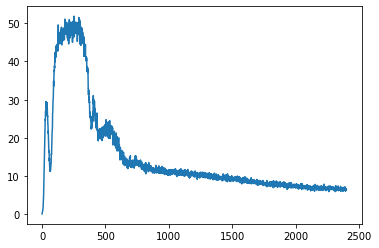

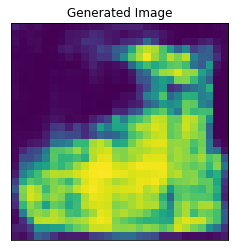

Iteration [2401/10000]......0.116(s) gen: 0.25254 - disc_fake: 0.26014 - disc_real: 6.10334 - disc_real: 5.84320
Iteration [2402/10000]......0.115(s) gen: 0.35789 - disc_fake: 0.38101 - disc_real: 7.21453 - disc_real: 6.83352
Iteration [2403/10000]......0.116(s) gen: 0.23268 - disc_fake: -0.40246 - disc_real: 6.51814 - disc_real: 6.92060
Iteration [2404/10000]......0.116(s) gen: -0.39166 - disc_fake: -0.31383 - disc_real: 6.63198 - disc_real: 6.94581
Iteration [2405/10000]......0.119(s) gen: 0.30665 - disc_fake: 0.11855 - disc_real: 6.42264 - disc_real: 6.30409
Iteration [2406/10000]......0.118(s) gen: -0.75667 - disc_fake: 0.21547 - disc_real: 6.65323 - disc_real: 6.43777
Iteration [2407/10000]......0.118(s) gen: -0.55499 - disc_fake: 0.73846 - disc_real: 7.66248 - disc_real: 6.92402
Iteration [2408/10000]......0.119(s) gen: -0.39399 - disc_fake: -0.00130 - disc_real: 7.09886 - disc_real: 7.10015
Iteration [2409/10000]......0.118(s) gen: -0.17495 - disc_fake: -0.34942 - disc_real: 6.0

Iteration [2474/10000]......0.117(s) gen: -0.69102 - disc_fake: 1.02114 - disc_real: 6.96610 - disc_real: 5.94496
Iteration [2475/10000]......0.118(s) gen: -1.07921 - disc_fake: 0.73676 - disc_real: 6.70199 - disc_real: 5.96522
Iteration [2476/10000]......0.120(s) gen: -0.78595 - disc_fake: 1.19927 - disc_real: 8.10063 - disc_real: 6.90136
Iteration [2477/10000]......0.119(s) gen: -1.64281 - disc_fake: 1.14687 - disc_real: 7.21264 - disc_real: 6.06577
Iteration [2478/10000]......0.120(s) gen: -0.54041 - disc_fake: 0.96436 - disc_real: 7.25267 - disc_real: 6.28832
Iteration [2479/10000]......0.119(s) gen: -1.67406 - disc_fake: 1.14990 - disc_real: 7.17036 - disc_real: 6.02046
Iteration [2480/10000]......0.119(s) gen: -0.61632 - disc_fake: 1.31019 - disc_real: 8.18051 - disc_real: 6.87032
Iteration [2481/10000]......0.130(s) gen: 0.21240 - disc_fake: 1.23363 - disc_real: 8.01515 - disc_real: 6.78152
Iteration [2482/10000]......0.117(s) gen: -0.76534 - disc_fake: 0.52198 - disc_real: 6.95

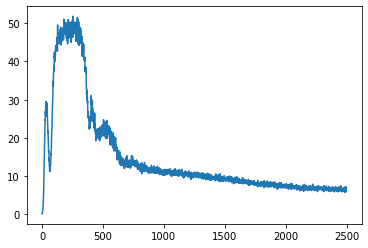

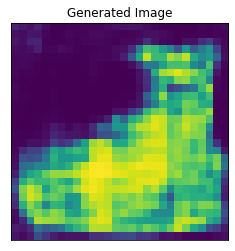

Iteration [2501/10000]......0.126(s) gen: -0.72601 - disc_fake: 1.19143 - disc_real: 7.37770 - disc_real: 6.18627
Iteration [2502/10000]......0.128(s) gen: -1.10704 - disc_fake: 0.14865 - disc_real: 6.73289 - disc_real: 6.58424
Iteration [2503/10000]......0.135(s) gen: -1.49243 - disc_fake: 1.24231 - disc_real: 7.49501 - disc_real: 6.25270
Iteration [2504/10000]......0.134(s) gen: -1.61381 - disc_fake: 0.94408 - disc_real: 7.29176 - disc_real: 6.34768
Iteration [2505/10000]......0.136(s) gen: -0.64260 - disc_fake: 0.26064 - disc_real: 6.67988 - disc_real: 6.41924
Iteration [2506/10000]......0.134(s) gen: -0.61220 - disc_fake: 0.75205 - disc_real: 7.42811 - disc_real: 6.67605
Iteration [2507/10000]......0.135(s) gen: -2.20258 - disc_fake: 1.58431 - disc_real: 8.25123 - disc_real: 6.66691
Iteration [2508/10000]......0.135(s) gen: -0.69833 - disc_fake: 0.60254 - disc_real: 7.48024 - disc_real: 6.87770
Iteration [2509/10000]......0.135(s) gen: -0.63904 - disc_fake: 0.18184 - disc_real: 7.3

Iteration [2573/10000]......0.119(s) gen: -1.79385 - disc_fake: 1.61090 - disc_real: 7.59533 - disc_real: 5.98442
Iteration [2574/10000]......0.120(s) gen: -2.23520 - disc_fake: 1.89357 - disc_real: 8.74653 - disc_real: 6.85296
Iteration [2575/10000]......0.119(s) gen: -0.97976 - disc_fake: 1.64842 - disc_real: 7.73798 - disc_real: 6.08956
Iteration [2576/10000]......0.119(s) gen: -1.27475 - disc_fake: 1.43921 - disc_real: 7.61829 - disc_real: 6.17909
Iteration [2577/10000]......0.120(s) gen: -0.46329 - disc_fake: 1.95469 - disc_real: 8.04705 - disc_real: 6.09236
Iteration [2578/10000]......0.120(s) gen: -1.85065 - disc_fake: 1.80714 - disc_real: 7.88538 - disc_real: 6.07824
Iteration [2579/10000]......0.121(s) gen: -1.85546 - disc_fake: 2.03797 - disc_real: 8.64670 - disc_real: 6.60873
Iteration [2580/10000]......0.121(s) gen: -1.39104 - disc_fake: 2.15119 - disc_real: 8.72289 - disc_real: 6.57170
Iteration [2581/10000]......0.120(s) gen: -1.39386 - disc_fake: 1.50187 - disc_real: 7.9

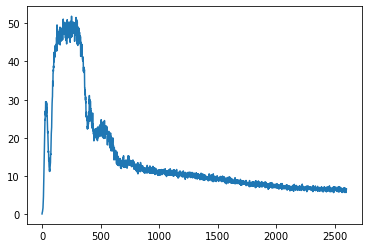

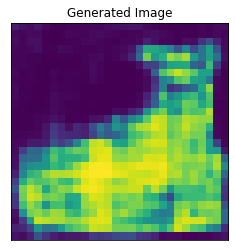

Iteration [2601/10000]......0.121(s) gen: -1.76773 - disc_fake: 1.04587 - disc_real: 7.54592 - disc_real: 6.50005
Iteration [2602/10000]......0.117(s) gen: -0.01454 - disc_fake: 1.10331 - disc_real: 7.63700 - disc_real: 6.53369
Iteration [2603/10000]......0.116(s) gen: -2.08306 - disc_fake: 1.49616 - disc_real: 7.46975 - disc_real: 5.97359
Iteration [2604/10000]......0.117(s) gen: -3.33824 - disc_fake: 2.15966 - disc_real: 8.82784 - disc_real: 6.66818
Iteration [2605/10000]......0.115(s) gen: -2.33683 - disc_fake: 2.80601 - disc_real: 9.05686 - disc_real: 6.25085
Iteration [2606/10000]......0.117(s) gen: -2.03248 - disc_fake: 2.03434 - disc_real: 8.22165 - disc_real: 6.18731
Iteration [2607/10000]......0.116(s) gen: -2.03313 - disc_fake: 1.83808 - disc_real: 8.51788 - disc_real: 6.67980
Iteration [2608/10000]......0.118(s) gen: -2.31281 - disc_fake: 2.69090 - disc_real: 9.10843 - disc_real: 6.41753
Iteration [2609/10000]......0.117(s) gen: -1.32482 - disc_fake: 1.62946 - disc_real: 7.9

Iteration [2673/10000]......0.121(s) gen: -1.00565 - disc_fake: 1.51159 - disc_real: 8.29483 - disc_real: 6.78324
Iteration [2674/10000]......0.116(s) gen: -1.77459 - disc_fake: 1.20968 - disc_real: 7.64178 - disc_real: 6.43210
Iteration [2675/10000]......0.118(s) gen: -2.27730 - disc_fake: 2.15099 - disc_real: 8.21900 - disc_real: 6.06802
Iteration [2676/10000]......0.117(s) gen: -1.82324 - disc_fake: 2.29364 - disc_real: 8.50797 - disc_real: 6.21433
Iteration [2677/10000]......0.117(s) gen: -1.91644 - disc_fake: 1.80112 - disc_real: 8.04664 - disc_real: 6.24552
Iteration [2678/10000]......0.118(s) gen: -1.88859 - disc_fake: 1.58459 - disc_real: 7.90732 - disc_real: 6.32273
Iteration [2679/10000]......0.117(s) gen: -2.36341 - disc_fake: 1.38373 - disc_real: 7.67379 - disc_real: 6.29006
Iteration [2680/10000]......0.117(s) gen: -2.45043 - disc_fake: 1.65543 - disc_real: 8.21660 - disc_real: 6.56117
Iteration [2681/10000]......0.119(s) gen: -1.27228 - disc_fake: 2.04138 - disc_real: 7.5

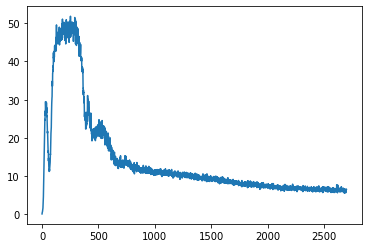

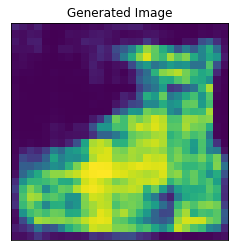

Iteration [2701/10000]......0.115(s) gen: -1.96554 - disc_fake: 2.10266 - disc_real: 9.08999 - disc_real: 6.98733
Iteration [2702/10000]......0.115(s) gen: -0.59535 - disc_fake: 1.54658 - disc_real: 6.94581 - disc_real: 5.39922
Iteration [2703/10000]......0.115(s) gen: -1.86590 - disc_fake: 0.62684 - disc_real: 6.95717 - disc_real: 6.33033
Iteration [2704/10000]......0.116(s) gen: -1.50892 - disc_fake: 1.90074 - disc_real: 7.81283 - disc_real: 5.91209
Iteration [2705/10000]......0.115(s) gen: -2.10756 - disc_fake: 1.08904 - disc_real: 7.28844 - disc_real: 6.19940
Iteration [2706/10000]......0.116(s) gen: -2.24486 - disc_fake: 2.22196 - disc_real: 9.05100 - disc_real: 6.82904
Iteration [2707/10000]......0.116(s) gen: -2.01165 - disc_fake: 2.55416 - disc_real: 8.38429 - disc_real: 5.83013
Iteration [2708/10000]......0.116(s) gen: -2.26866 - disc_fake: 2.72465 - disc_real: 9.16699 - disc_real: 6.44234
Iteration [2709/10000]......0.117(s) gen: -1.85436 - disc_fake: 1.58540 - disc_real: 7.7

Iteration [2773/10000]......0.121(s) gen: -3.15531 - disc_fake: 1.59207 - disc_real: 8.11858 - disc_real: 6.52651
Iteration [2774/10000]......0.120(s) gen: -1.23658 - disc_fake: 2.03770 - disc_real: 8.18710 - disc_real: 6.14939
Iteration [2775/10000]......0.121(s) gen: -0.92224 - disc_fake: 1.78278 - disc_real: 7.73674 - disc_real: 5.95396
Iteration [2776/10000]......0.122(s) gen: -1.83012 - disc_fake: 1.33198 - disc_real: 7.40892 - disc_real: 6.07694
Iteration [2777/10000]......0.120(s) gen: -0.89428 - disc_fake: 0.61091 - disc_real: 7.35441 - disc_real: 6.74350
Iteration [2778/10000]......0.119(s) gen: -0.90808 - disc_fake: 0.80632 - disc_real: 6.69947 - disc_real: 5.89315
Iteration [2779/10000]......0.120(s) gen: -3.30286 - disc_fake: 1.75819 - disc_real: 7.93128 - disc_real: 6.17309
Iteration [2780/10000]......0.120(s) gen: -1.22511 - disc_fake: 2.83878 - disc_real: 8.29485 - disc_real: 5.45607
Iteration [2781/10000]......0.121(s) gen: -1.47338 - disc_fake: 1.39047 - disc_real: 7.5

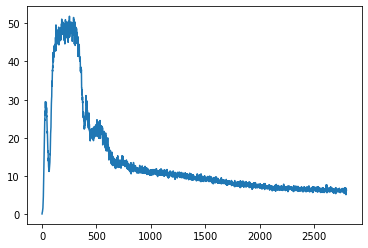

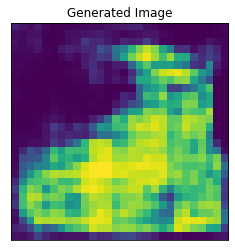

Iteration [2801/10000]......0.121(s) gen: -1.91279 - disc_fake: 2.13159 - disc_real: 8.75030 - disc_real: 6.61871
Iteration [2802/10000]......0.117(s) gen: -1.30159 - disc_fake: 1.66841 - disc_real: 8.11075 - disc_real: 6.44233
Iteration [2803/10000]......0.117(s) gen: -1.21350 - disc_fake: 1.39673 - disc_real: 8.06381 - disc_real: 6.66708
Iteration [2804/10000]......0.117(s) gen: -0.21045 - disc_fake: 1.02485 - disc_real: 7.33381 - disc_real: 6.30896
Iteration [2805/10000]......0.118(s) gen: -0.29604 - disc_fake: 0.65870 - disc_real: 6.37074 - disc_real: 5.71204
Iteration [2806/10000]......0.117(s) gen: -1.74866 - disc_fake: 0.87291 - disc_real: 6.60343 - disc_real: 5.73052
Iteration [2807/10000]......0.115(s) gen: -0.82209 - disc_fake: 0.94290 - disc_real: 7.62211 - disc_real: 6.67921
Iteration [2808/10000]......0.115(s) gen: -1.18977 - disc_fake: 1.41613 - disc_real: 8.04785 - disc_real: 6.63172
Iteration [2809/10000]......0.117(s) gen: -1.52646 - disc_fake: 1.44368 - disc_real: 7.6

Iteration [2873/10000]......0.119(s) gen: -1.37736 - disc_fake: 1.58836 - disc_real: 8.61943 - disc_real: 7.03107
Iteration [2874/10000]......0.119(s) gen: -1.77829 - disc_fake: 2.22907 - disc_real: 8.15973 - disc_real: 5.93066
Iteration [2875/10000]......0.119(s) gen: -1.17563 - disc_fake: 1.47767 - disc_real: 7.30420 - disc_real: 5.82653
Iteration [2876/10000]......0.119(s) gen: -1.42793 - disc_fake: 1.77031 - disc_real: 8.18140 - disc_real: 6.41109
Iteration [2877/10000]......0.118(s) gen: -1.75141 - disc_fake: 2.38139 - disc_real: 8.29817 - disc_real: 5.91678
Iteration [2878/10000]......0.120(s) gen: -1.66160 - disc_fake: 1.67442 - disc_real: 7.53679 - disc_real: 5.86237
Iteration [2879/10000]......0.119(s) gen: -2.16230 - disc_fake: 2.12141 - disc_real: 8.33700 - disc_real: 6.21559
Iteration [2880/10000]......0.119(s) gen: -3.00339 - disc_fake: 2.14752 - disc_real: 8.69357 - disc_real: 6.54605
Iteration [2881/10000]......0.119(s) gen: -0.64413 - disc_fake: 2.76632 - disc_real: 9.2

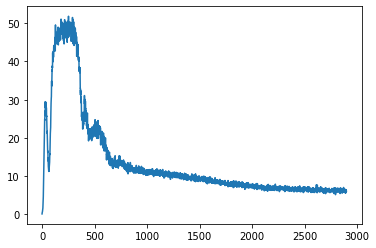

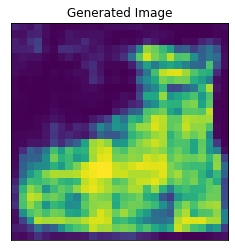

Iteration [2901/10000]......0.115(s) gen: -1.73327 - disc_fake: 1.92268 - disc_real: 7.85971 - disc_real: 5.93703
Iteration [2902/10000]......0.114(s) gen: -1.64585 - disc_fake: 1.76683 - disc_real: 8.77735 - disc_real: 7.01052
Iteration [2903/10000]......0.114(s) gen: -2.25002 - disc_fake: 2.11661 - disc_real: 8.56753 - disc_real: 6.45092
Iteration [2904/10000]......0.115(s) gen: -0.92247 - disc_fake: 1.87336 - disc_real: 7.78798 - disc_real: 5.91463
Iteration [2905/10000]......0.114(s) gen: -1.71482 - disc_fake: 1.70304 - disc_real: 7.66189 - disc_real: 5.95885
Iteration [2906/10000]......0.114(s) gen: -2.48566 - disc_fake: 2.62373 - disc_real: 9.01739 - disc_real: 6.39366
Iteration [2907/10000]......0.116(s) gen: -2.31647 - disc_fake: 3.36487 - disc_real: 9.19180 - disc_real: 5.82693
Iteration [2908/10000]......0.115(s) gen: -1.71461 - disc_fake: 2.09921 - disc_real: 8.29612 - disc_real: 6.19690
Iteration [2909/10000]......0.116(s) gen: -2.15166 - disc_fake: 1.62736 - disc_real: 7.8

Iteration [2973/10000]......0.119(s) gen: -2.73223 - disc_fake: 3.30122 - disc_real: 9.42034 - disc_real: 6.11912
Iteration [2974/10000]......0.118(s) gen: -2.87945 - disc_fake: 3.23018 - disc_real: 9.05261 - disc_real: 5.82242
Iteration [2975/10000]......0.119(s) gen: -2.20130 - disc_fake: 2.55967 - disc_real: 8.54063 - disc_real: 5.98096
Iteration [2976/10000]......0.118(s) gen: -2.52686 - disc_fake: 1.92543 - disc_real: 7.89033 - disc_real: 5.96491
Iteration [2977/10000]......0.121(s) gen: -3.43367 - disc_fake: 3.11578 - disc_real: 9.04877 - disc_real: 5.93299
Iteration [2978/10000]......0.120(s) gen: -1.99576 - disc_fake: 2.79845 - disc_real: 8.65389 - disc_real: 5.85545
Iteration [2979/10000]......0.122(s) gen: -2.83246 - disc_fake: 2.75776 - disc_real: 8.33810 - disc_real: 5.58035
Iteration [2980/10000]......0.123(s) gen: -3.53771 - disc_fake: 3.18542 - disc_real: 9.63269 - disc_real: 6.44727
Iteration [2981/10000]......0.120(s) gen: -2.72651 - disc_fake: 2.43820 - disc_real: 8.1

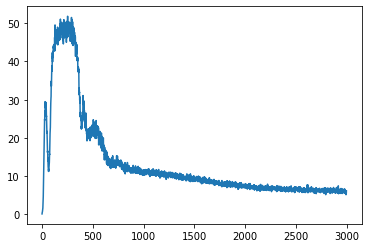

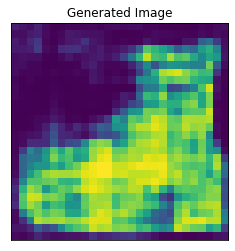

Iteration [3001/10000]......0.121(s) gen: -2.07200 - disc_fake: 3.06152 - disc_real: 9.52484 - disc_real: 6.46332
Iteration [3002/10000]......0.134(s) gen: -2.77084 - disc_fake: 2.47637 - disc_real: 8.32270 - disc_real: 5.84633
Iteration [3003/10000]......0.135(s) gen: -1.97608 - disc_fake: 2.42588 - disc_real: 8.14133 - disc_real: 5.71545
Iteration [3004/10000]......0.134(s) gen: -2.29229 - disc_fake: 2.11546 - disc_real: 8.15320 - disc_real: 6.03774
Iteration [3005/10000]......0.133(s) gen: -1.22566 - disc_fake: 1.58303 - disc_real: 8.22417 - disc_real: 6.64114
Iteration [3006/10000]......0.135(s) gen: -2.71160 - disc_fake: 2.28663 - disc_real: 8.09094 - disc_real: 5.80432
Iteration [3007/10000]......0.136(s) gen: -2.72017 - disc_fake: 2.95103 - disc_real: 8.53582 - disc_real: 5.58479
Iteration [3008/10000]......0.134(s) gen: -1.78549 - disc_fake: 2.38776 - disc_real: 8.73387 - disc_real: 6.34611
Iteration [3009/10000]......0.135(s) gen: -3.68948 - disc_fake: 2.46900 - disc_real: 9.4

Iteration [3074/10000]......0.120(s) gen: -3.39673 - disc_fake: 2.43084 - disc_real: 8.24967 - disc_real: 5.81883
Iteration [3075/10000]......0.120(s) gen: -3.77178 - disc_fake: 3.44190 - disc_real: 9.02292 - disc_real: 5.58101
Iteration [3076/10000]......0.118(s) gen: -3.94288 - disc_fake: 3.86922 - disc_real: 9.99141 - disc_real: 6.12219
Iteration [3077/10000]......0.119(s) gen: -3.80977 - disc_fake: 3.18637 - disc_real: 9.57817 - disc_real: 6.39180
Iteration [3078/10000]......0.118(s) gen: -3.40811 - disc_fake: 3.12814 - disc_real: 9.27800 - disc_real: 6.14986
Iteration [3079/10000]......0.120(s) gen: -3.37811 - disc_fake: 3.06196 - disc_real: 9.38876 - disc_real: 6.32681
Iteration [3080/10000]......0.119(s) gen: -2.92412 - disc_fake: 3.51794 - disc_real: 9.31246 - disc_real: 5.79452
Iteration [3081/10000]......0.119(s) gen: -2.66837 - disc_fake: 3.05044 - disc_real: 8.36739 - disc_real: 5.31695
Iteration [3082/10000]......0.119(s) gen: -3.81212 - disc_fake: 4.37162 - disc_real: 10.

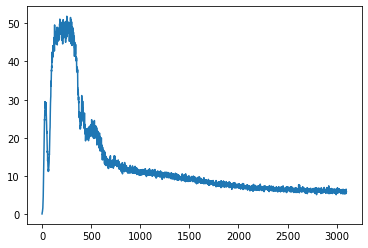

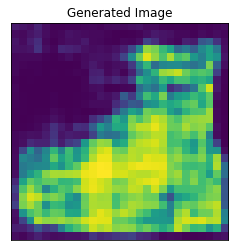

Iteration [3101/10000]......0.120(s) gen: -2.11218 - disc_fake: 2.64722 - disc_real: 8.95722 - disc_real: 6.31000
Iteration [3102/10000]......0.131(s) gen: -2.23321 - disc_fake: 3.38512 - disc_real: 8.80416 - disc_real: 5.41904
Iteration [3103/10000]......0.135(s) gen: -1.65129 - disc_fake: 2.72709 - disc_real: 8.19072 - disc_real: 5.46363
Iteration [3104/10000]......0.134(s) gen: -4.05135 - disc_fake: 2.51800 - disc_real: 8.60698 - disc_real: 6.08898
Iteration [3105/10000]......0.135(s) gen: -2.89312 - disc_fake: 3.72690 - disc_real: 9.88946 - disc_real: 6.16257
Iteration [3106/10000]......0.134(s) gen: -4.20028 - disc_fake: 3.53792 - disc_real: 9.42132 - disc_real: 5.88339
Iteration [3107/10000]......0.135(s) gen: -3.39761 - disc_fake: 3.76026 - disc_real: 9.62058 - disc_real: 5.86032
Iteration [3108/10000]......0.134(s) gen: -2.75559 - disc_fake: 3.47274 - disc_real: 8.77285 - disc_real: 5.30011
Iteration [3109/10000]......0.134(s) gen: -2.74283 - disc_fake: 3.32180 - disc_real: 9.4

Iteration [3173/10000]......0.118(s) gen: -3.48884 - disc_fake: 2.94298 - disc_real: 8.95432 - disc_real: 6.01134
Iteration [3174/10000]......0.117(s) gen: -2.93143 - disc_fake: 3.80974 - disc_real: 9.81302 - disc_real: 6.00328
Iteration [3175/10000]......0.117(s) gen: -2.55504 - disc_fake: 2.63107 - disc_real: 9.12935 - disc_real: 6.49828
Iteration [3176/10000]......0.118(s) gen: -4.21381 - disc_fake: 3.60887 - disc_real: 9.54351 - disc_real: 5.93464
Iteration [3177/10000]......0.117(s) gen: -3.92468 - disc_fake: 3.24778 - disc_real: 8.89240 - disc_real: 5.64462
Iteration [3178/10000]......0.118(s) gen: -2.01667 - disc_fake: 3.26866 - disc_real: 9.45862 - disc_real: 6.18996
Iteration [3179/10000]......0.118(s) gen: -1.92826 - disc_fake: 2.66618 - disc_real: 8.36294 - disc_real: 5.69676
Iteration [3180/10000]......0.119(s) gen: -2.73997 - disc_fake: 2.13781 - disc_real: 8.28649 - disc_real: 6.14868
Iteration [3181/10000]......0.120(s) gen: -3.20067 - disc_fake: 3.29035 - disc_real: 8.9

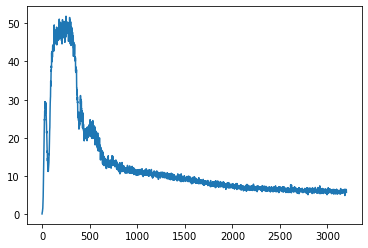

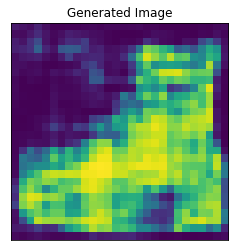

Iteration [3201/10000]......0.114(s) gen: -3.48974 - disc_fake: 3.24047 - disc_real: 8.83243 - disc_real: 5.59196
Iteration [3202/10000]......0.115(s) gen: -2.80485 - disc_fake: 3.72620 - disc_real: 9.65019 - disc_real: 5.92399
Iteration [3203/10000]......0.117(s) gen: -3.39810 - disc_fake: 3.54457 - disc_real: 8.98578 - disc_real: 5.44121
Iteration [3204/10000]......0.118(s) gen: -3.93514 - disc_fake: 3.00718 - disc_real: 9.14649 - disc_real: 6.13931
Iteration [3205/10000]......0.117(s) gen: -2.38061 - disc_fake: 3.25997 - disc_real: 8.97605 - disc_real: 5.71608
Iteration [3206/10000]......0.118(s) gen: -4.34196 - disc_fake: 3.76564 - disc_real: 9.54684 - disc_real: 5.78120
Iteration [3207/10000]......0.116(s) gen: -3.84240 - disc_fake: 3.58941 - disc_real: 9.47007 - disc_real: 5.88066
Iteration [3208/10000]......0.120(s) gen: -3.62593 - disc_fake: 4.42512 - disc_real: 9.59139 - disc_real: 5.16627
Iteration [3209/10000]......0.120(s) gen: -3.60884 - disc_fake: 4.24547 - disc_real: 10.

Iteration [3273/10000]......0.120(s) gen: -3.09351 - disc_fake: 3.27326 - disc_real: 9.17337 - disc_real: 5.90011
Iteration [3274/10000]......0.119(s) gen: -3.54486 - disc_fake: 2.95317 - disc_real: 8.97812 - disc_real: 6.02495
Iteration [3275/10000]......0.120(s) gen: -3.42977 - disc_fake: 2.79142 - disc_real: 8.60771 - disc_real: 5.81628
Iteration [3276/10000]......0.118(s) gen: -3.05859 - disc_fake: 3.64348 - disc_real: 9.39409 - disc_real: 5.75061
Iteration [3277/10000]......0.118(s) gen: -2.27324 - disc_fake: 3.06340 - disc_real: 9.47603 - disc_real: 6.41263
Iteration [3278/10000]......0.118(s) gen: -3.04480 - disc_fake: 2.85958 - disc_real: 8.51525 - disc_real: 5.65567
Iteration [3279/10000]......0.119(s) gen: -3.50976 - disc_fake: 3.83538 - disc_real: 9.21401 - disc_real: 5.37863
Iteration [3280/10000]......0.119(s) gen: -2.38510 - disc_fake: 3.18909 - disc_real: 8.93357 - disc_real: 5.74448
Iteration [3281/10000]......0.119(s) gen: -3.00120 - disc_fake: 3.07031 - disc_real: 8.7

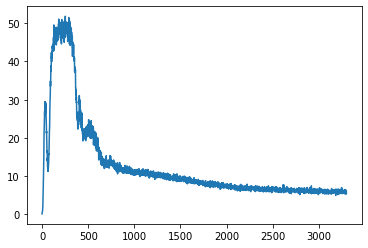

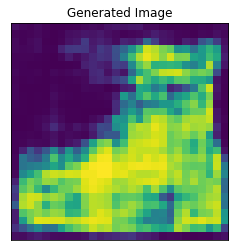

Iteration [3301/10000]......0.115(s) gen: -3.44967 - disc_fake: 3.43820 - disc_real: 9.00103 - disc_real: 5.56283
Iteration [3302/10000]......0.116(s) gen: -4.27891 - disc_fake: 3.79760 - disc_real: 9.97232 - disc_real: 6.17472
Iteration [3303/10000]......0.115(s) gen: -2.07599 - disc_fake: 3.81105 - disc_real: 9.45289 - disc_real: 5.64184
Iteration [3304/10000]......0.116(s) gen: -3.71520 - disc_fake: 3.10405 - disc_real: 9.34295 - disc_real: 6.23890
Iteration [3305/10000]......0.117(s) gen: -3.09470 - disc_fake: 3.59750 - disc_real: 8.90624 - disc_real: 5.30874
Iteration [3306/10000]......0.118(s) gen: -3.49697 - disc_fake: 3.41239 - disc_real: 9.67788 - disc_real: 6.26548
Iteration [3307/10000]......0.120(s) gen: -3.41999 - disc_fake: 2.91783 - disc_real: 8.94342 - disc_real: 6.02559
Iteration [3308/10000]......0.119(s) gen: -4.35559 - disc_fake: 4.29361 - disc_real: 10.20354 - disc_real: 5.90993
Iteration [3309/10000]......0.120(s) gen: -4.15194 - disc_fake: 4.68148 - disc_real: 10

Iteration [3373/10000]......0.119(s) gen: -3.34734 - disc_fake: 3.47095 - disc_real: 9.54025 - disc_real: 6.06930
Iteration [3374/10000]......0.119(s) gen: -3.88738 - disc_fake: 3.31104 - disc_real: 9.43893 - disc_real: 6.12789
Iteration [3375/10000]......0.118(s) gen: -4.12731 - disc_fake: 3.75002 - disc_real: 10.29626 - disc_real: 6.54624
Iteration [3376/10000]......0.119(s) gen: -4.15832 - disc_fake: 4.05717 - disc_real: 9.93144 - disc_real: 5.87427
Iteration [3377/10000]......0.121(s) gen: -4.08754 - disc_fake: 3.82817 - disc_real: 8.88278 - disc_real: 5.05461
Iteration [3378/10000]......0.120(s) gen: -2.68626 - disc_fake: 3.49254 - disc_real: 8.94155 - disc_real: 5.44901
Iteration [3379/10000]......0.120(s) gen: -3.81929 - disc_fake: 3.33249 - disc_real: 9.30546 - disc_real: 5.97297
Iteration [3380/10000]......0.121(s) gen: -5.05490 - disc_fake: 4.50549 - disc_real: 10.59602 - disc_real: 6.09054
Iteration [3381/10000]......0.122(s) gen: -4.34679 - disc_fake: 5.13354 - disc_real: 1

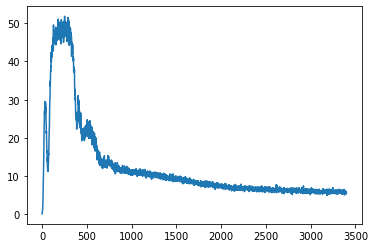

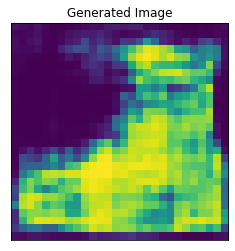

Iteration [3401/10000]......0.121(s) gen: -5.31476 - disc_fake: 4.77189 - disc_real: 10.74735 - disc_real: 5.97546
Iteration [3402/10000]......0.115(s) gen: -4.38332 - disc_fake: 4.61111 - disc_real: 10.67802 - disc_real: 6.06692
Iteration [3403/10000]......0.118(s) gen: -4.62484 - disc_fake: 4.24927 - disc_real: 9.94358 - disc_real: 5.69431
Iteration [3404/10000]......0.117(s) gen: -4.99075 - disc_fake: 4.72933 - disc_real: 10.32052 - disc_real: 5.59119
Iteration [3405/10000]......0.119(s) gen: -2.95425 - disc_fake: 4.47082 - disc_real: 10.41312 - disc_real: 5.94231
Iteration [3406/10000]......0.120(s) gen: -3.84231 - disc_fake: 2.93515 - disc_real: 8.62435 - disc_real: 5.68920
Iteration [3407/10000]......0.118(s) gen: -4.06691 - disc_fake: 3.49182 - disc_real: 9.80343 - disc_real: 6.31161
Iteration [3408/10000]......0.120(s) gen: -4.97811 - disc_fake: 4.92232 - disc_real: 10.27265 - disc_real: 5.35034
Iteration [3409/10000]......0.119(s) gen: -5.67804 - disc_fake: 5.33054 - disc_real

Iteration [3473/10000]......0.120(s) gen: -4.60705 - disc_fake: 3.98549 - disc_real: 9.64307 - disc_real: 5.65757
Iteration [3474/10000]......0.118(s) gen: -1.93902 - disc_fake: 3.85978 - disc_real: 9.83890 - disc_real: 5.97912
Iteration [3475/10000]......0.118(s) gen: -5.02544 - disc_fake: 3.86700 - disc_real: 9.74956 - disc_real: 5.88256
Iteration [3476/10000]......0.119(s) gen: -4.51206 - disc_fake: 5.16242 - disc_real: 10.96541 - disc_real: 5.80300
Iteration [3477/10000]......0.120(s) gen: -4.26930 - disc_fake: 4.61046 - disc_real: 10.28232 - disc_real: 5.67186
Iteration [3478/10000]......0.120(s) gen: -3.15823 - disc_fake: 4.46479 - disc_real: 10.57539 - disc_real: 6.11060
Iteration [3479/10000]......0.120(s) gen: -3.32715 - disc_fake: 3.58992 - disc_real: 9.27819 - disc_real: 5.68827
Iteration [3480/10000]......0.120(s) gen: -5.43727 - disc_fake: 4.07757 - disc_real: 9.60054 - disc_real: 5.52296
Iteration [3481/10000]......0.121(s) gen: -5.58097 - disc_fake: 5.14909 - disc_real: 

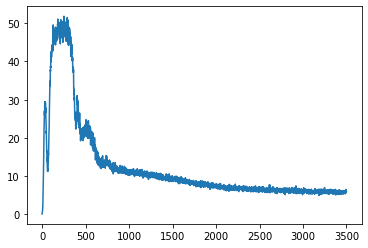

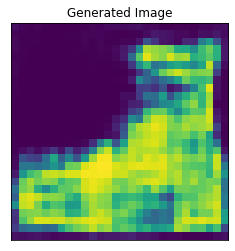

Iteration [3501/10000]......0.117(s) gen: -3.20627 - disc_fake: 3.38746 - disc_real: 8.83590 - disc_real: 5.44844
Iteration [3502/10000]......0.115(s) gen: -2.87598 - disc_fake: 3.12395 - disc_real: 9.00430 - disc_real: 5.88035
Iteration [3503/10000]......0.116(s) gen: -2.85919 - disc_fake: 3.30662 - disc_real: 9.37076 - disc_real: 6.06414
Iteration [3504/10000]......0.116(s) gen: -4.58324 - disc_fake: 2.18538 - disc_real: 8.28623 - disc_real: 6.10085
Iteration [3505/10000]......0.117(s) gen: -5.04835 - disc_fake: 4.83019 - disc_real: 10.53275 - disc_real: 5.70256
Iteration [3506/10000]......0.115(s) gen: -3.46782 - disc_fake: 4.27065 - disc_real: 9.82874 - disc_real: 5.55809
Iteration [3507/10000]......0.117(s) gen: -3.92339 - disc_fake: 4.06847 - disc_real: 10.35796 - disc_real: 6.28949
Iteration [3508/10000]......0.117(s) gen: -4.20512 - disc_fake: 4.34221 - disc_real: 9.80917 - disc_real: 5.46696
Iteration [3509/10000]......0.117(s) gen: -5.01653 - disc_fake: 4.33458 - disc_real: 9

Iteration [3573/10000]......0.120(s) gen: -5.05743 - disc_fake: 4.40493 - disc_real: 9.99408 - disc_real: 5.58915
Iteration [3574/10000]......0.119(s) gen: -3.97661 - disc_fake: 4.93619 - disc_real: 9.92345 - disc_real: 4.98726
Iteration [3575/10000]......0.120(s) gen: -4.66354 - disc_fake: 3.88000 - disc_real: 10.05062 - disc_real: 6.17062
Iteration [3576/10000]......0.119(s) gen: -3.72217 - disc_fake: 3.79728 - disc_real: 9.46021 - disc_real: 5.66293
Iteration [3577/10000]......0.118(s) gen: -5.02071 - disc_fake: 4.61552 - disc_real: 10.21685 - disc_real: 5.60134
Iteration [3578/10000]......0.118(s) gen: -5.20227 - disc_fake: 5.41691 - disc_real: 11.04923 - disc_real: 5.63232
Iteration [3579/10000]......0.119(s) gen: -5.33694 - disc_fake: 5.32882 - disc_real: 10.80337 - disc_real: 5.47455
Iteration [3580/10000]......0.120(s) gen: -4.30121 - disc_fake: 4.87031 - disc_real: 10.44292 - disc_real: 5.57261
Iteration [3581/10000]......0.119(s) gen: -3.55727 - disc_fake: 4.87965 - disc_real

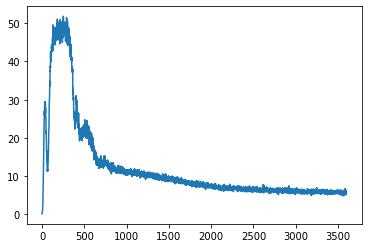

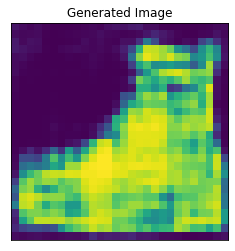

Iteration [3601/10000]......0.115(s) gen: -4.40996 - disc_fake: 5.61369 - disc_real: 10.87121 - disc_real: 5.25752
Iteration [3602/10000]......0.115(s) gen: -4.65916 - disc_fake: 4.51650 - disc_real: 9.71067 - disc_real: 5.19417
Iteration [3603/10000]......0.116(s) gen: -4.70178 - disc_fake: 4.44860 - disc_real: 9.96151 - disc_real: 5.51290
Iteration [3604/10000]......0.117(s) gen: -4.18657 - disc_fake: 4.74569 - disc_real: 10.29871 - disc_real: 5.55302
Iteration [3605/10000]......0.116(s) gen: -5.26957 - disc_fake: 4.83853 - disc_real: 10.42350 - disc_real: 5.58497
Iteration [3606/10000]......0.116(s) gen: -4.08824 - disc_fake: 5.01088 - disc_real: 11.07156 - disc_real: 6.06068
Iteration [3607/10000]......0.117(s) gen: -3.93486 - disc_fake: 4.58691 - disc_real: 10.89206 - disc_real: 6.30514
Iteration [3608/10000]......0.118(s) gen: -4.71538 - disc_fake: 4.57516 - disc_real: 10.31395 - disc_real: 5.73879
Iteration [3609/10000]......0.120(s) gen: -3.73532 - disc_fake: 4.12832 - disc_rea

Iteration [3674/10000]......0.119(s) gen: -4.12129 - disc_fake: 5.81081 - disc_real: 11.37845 - disc_real: 5.56764
Iteration [3675/10000]......0.118(s) gen: -6.41462 - disc_fake: 5.04437 - disc_real: 10.60000 - disc_real: 5.55562
Iteration [3676/10000]......0.118(s) gen: -4.70725 - disc_fake: 5.51580 - disc_real: 11.25566 - disc_real: 5.73986
Iteration [3677/10000]......0.118(s) gen: -4.70528 - disc_fake: 4.81150 - disc_real: 10.44735 - disc_real: 5.63585
Iteration [3678/10000]......0.118(s) gen: -3.87321 - disc_fake: 4.06615 - disc_real: 10.22306 - disc_real: 6.15691
Iteration [3679/10000]......0.118(s) gen: -5.25051 - disc_fake: 5.02465 - disc_real: 10.48188 - disc_real: 5.45723
Iteration [3680/10000]......0.117(s) gen: -5.52518 - disc_fake: 4.48474 - disc_real: 10.18908 - disc_real: 5.70434
Iteration [3681/10000]......0.119(s) gen: -5.19726 - disc_fake: 5.25921 - disc_real: 10.78752 - disc_real: 5.52831
Iteration [3682/10000]......0.118(s) gen: -4.96691 - disc_fake: 5.25527 - disc_r

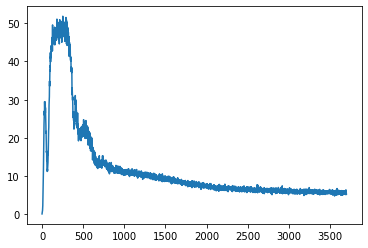

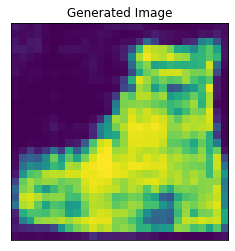

Iteration [3701/10000]......0.118(s) gen: -6.05140 - disc_fake: 5.42749 - disc_real: 11.10771 - disc_real: 5.68022
Iteration [3702/10000]......0.115(s) gen: -4.78916 - disc_fake: 4.90830 - disc_real: 10.38980 - disc_real: 5.48150
Iteration [3703/10000]......0.117(s) gen: -4.84097 - disc_fake: 4.86624 - disc_real: 10.45954 - disc_real: 5.59330
Iteration [3704/10000]......0.118(s) gen: -4.54849 - disc_fake: 4.98763 - disc_real: 10.68831 - disc_real: 5.70068
Iteration [3705/10000]......0.117(s) gen: -6.42196 - disc_fake: 5.16368 - disc_real: 10.95826 - disc_real: 5.79459
Iteration [3706/10000]......0.118(s) gen: -5.24354 - disc_fake: 5.63450 - disc_real: 11.60693 - disc_real: 5.97243
Iteration [3707/10000]......0.118(s) gen: -5.07536 - disc_fake: 4.92182 - disc_real: 10.44308 - disc_real: 5.52127
Iteration [3708/10000]......0.118(s) gen: -4.50173 - disc_fake: 5.23548 - disc_real: 10.78495 - disc_real: 5.54947
Iteration [3709/10000]......0.119(s) gen: -4.42601 - disc_fake: 5.24011 - disc_r

Iteration [3773/10000]......0.119(s) gen: -4.22118 - disc_fake: 5.02360 - disc_real: 10.54142 - disc_real: 5.51782
Iteration [3774/10000]......0.120(s) gen: -5.34641 - disc_fake: 5.54829 - disc_real: 10.90177 - disc_real: 5.35348
Iteration [3775/10000]......0.120(s) gen: -5.89968 - disc_fake: 5.92699 - disc_real: 11.68172 - disc_real: 5.75473
Iteration [3776/10000]......0.119(s) gen: -4.92577 - disc_fake: 5.56202 - disc_real: 10.99450 - disc_real: 5.43248
Iteration [3777/10000]......0.120(s) gen: -5.11039 - disc_fake: 5.33728 - disc_real: 10.78405 - disc_real: 5.44677
Iteration [3778/10000]......0.119(s) gen: -4.72848 - disc_fake: 4.97874 - disc_real: 10.31723 - disc_real: 5.33848
Iteration [3779/10000]......0.120(s) gen: -5.26198 - disc_fake: 5.47970 - disc_real: 11.35856 - disc_real: 5.87886
Iteration [3780/10000]......0.120(s) gen: -4.68006 - disc_fake: 5.17800 - disc_real: 10.88376 - disc_real: 5.70576
Iteration [3781/10000]......0.122(s) gen: -6.19946 - disc_fake: 5.58098 - disc_r

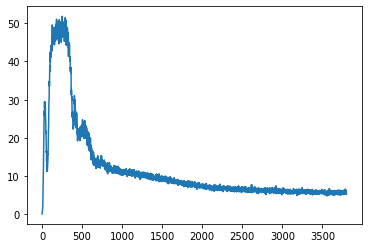

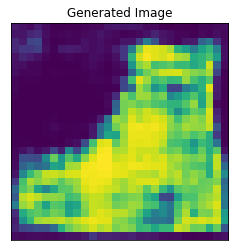

Iteration [3801/10000]......0.116(s) gen: -5.26051 - disc_fake: 6.09063 - disc_real: 12.10343 - disc_real: 6.01281
Iteration [3802/10000]......0.114(s) gen: -5.33960 - disc_fake: 5.87929 - disc_real: 11.09678 - disc_real: 5.21749
Iteration [3803/10000]......0.115(s) gen: -4.90079 - disc_fake: 5.46694 - disc_real: 10.58281 - disc_real: 5.11587
Iteration [3804/10000]......0.117(s) gen: -4.68326 - disc_fake: 4.98102 - disc_real: 10.44213 - disc_real: 5.46111
Iteration [3805/10000]......0.115(s) gen: -4.48866 - disc_fake: 5.02045 - disc_real: 10.52336 - disc_real: 5.50291
Iteration [3806/10000]......0.115(s) gen: -5.46050 - disc_fake: 4.69692 - disc_real: 10.26533 - disc_real: 5.56841
Iteration [3807/10000]......0.114(s) gen: -5.64762 - disc_fake: 5.56276 - disc_real: 10.35034 - disc_real: 4.78759
Iteration [3808/10000]......0.115(s) gen: -5.77587 - disc_fake: 6.10705 - disc_real: 12.00375 - disc_real: 5.89669
Iteration [3809/10000]......0.117(s) gen: -6.02495 - disc_fake: 5.72791 - disc_r

Iteration [3873/10000]......0.121(s) gen: -6.78732 - disc_fake: 5.66015 - disc_real: 11.09060 - disc_real: 5.43045
Iteration [3874/10000]......0.122(s) gen: -6.79457 - disc_fake: 6.34570 - disc_real: 11.48250 - disc_real: 5.13680
Iteration [3875/10000]......0.119(s) gen: -5.31619 - disc_fake: 6.16686 - disc_real: 11.61563 - disc_real: 5.44876
Iteration [3876/10000]......0.119(s) gen: -5.50303 - disc_fake: 5.17249 - disc_real: 10.92329 - disc_real: 5.75080
Iteration [3877/10000]......0.120(s) gen: -6.89614 - disc_fake: 6.86609 - disc_real: 12.19105 - disc_real: 5.32496
Iteration [3878/10000]......0.118(s) gen: -5.45590 - disc_fake: 6.69147 - disc_real: 12.46446 - disc_real: 5.77298
Iteration [3879/10000]......0.118(s) gen: -7.07871 - disc_fake: 6.34572 - disc_real: 12.11486 - disc_real: 5.76914
Iteration [3880/10000]......0.118(s) gen: -5.57639 - disc_fake: 6.02700 - disc_real: 11.63488 - disc_real: 5.60788
Iteration [3881/10000]......0.119(s) gen: -5.80363 - disc_fake: 5.64453 - disc_r

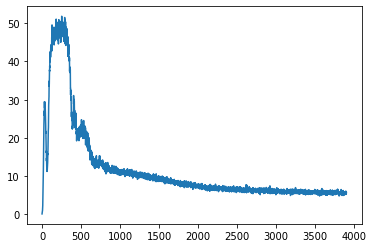

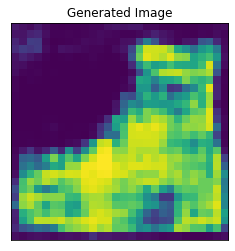

Iteration [3901/10000]......0.120(s) gen: -5.56877 - disc_fake: 5.85260 - disc_real: 11.71861 - disc_real: 5.86600
Iteration [3902/10000]......0.115(s) gen: -5.80308 - disc_fake: 5.37869 - disc_real: 11.27485 - disc_real: 5.89616
Iteration [3903/10000]......0.116(s) gen: -5.35413 - disc_fake: 5.35011 - disc_real: 11.01474 - disc_real: 5.66463
Iteration [3904/10000]......0.115(s) gen: -6.13027 - disc_fake: 5.49012 - disc_real: 11.29933 - disc_real: 5.80922
Iteration [3905/10000]......0.115(s) gen: -5.40042 - disc_fake: 5.59045 - disc_real: 11.12247 - disc_real: 5.53202
Iteration [3906/10000]......0.113(s) gen: -5.02678 - disc_fake: 6.31866 - disc_real: 11.93109 - disc_real: 5.61243
Iteration [3907/10000]......0.114(s) gen: -5.33570 - disc_fake: 5.69216 - disc_real: 11.10310 - disc_real: 5.41094
Iteration [3908/10000]......0.114(s) gen: -4.85736 - disc_fake: 5.56241 - disc_real: 11.59158 - disc_real: 6.02917
Iteration [3909/10000]......0.115(s) gen: -5.94745 - disc_fake: 6.05124 - disc_r

Iteration [3974/10000]......0.123(s) gen: -6.25670 - disc_fake: 5.56584 - disc_real: 10.99259 - disc_real: 5.42675
Iteration [3975/10000]......0.123(s) gen: -6.39709 - disc_fake: 6.79554 - disc_real: 12.08908 - disc_real: 5.29355
Iteration [3976/10000]......0.121(s) gen: -5.71122 - disc_fake: 6.47966 - disc_real: 12.03915 - disc_real: 5.55950
Iteration [3977/10000]......0.121(s) gen: -5.94074 - disc_fake: 6.12918 - disc_real: 12.05492 - disc_real: 5.92574
Iteration [3978/10000]......0.120(s) gen: -6.51297 - disc_fake: 6.49853 - disc_real: 11.94718 - disc_real: 5.44865
Iteration [3979/10000]......0.119(s) gen: -5.37123 - disc_fake: 6.44087 - disc_real: 11.45088 - disc_real: 5.01001
Iteration [3980/10000]......0.119(s) gen: -5.29549 - disc_fake: 5.96969 - disc_real: 11.22177 - disc_real: 5.25207
Iteration [3981/10000]......0.118(s) gen: -5.12566 - disc_fake: 6.30074 - disc_real: 11.56379 - disc_real: 5.26305
Iteration [3982/10000]......0.118(s) gen: -6.02874 - disc_fake: 5.37137 - disc_r

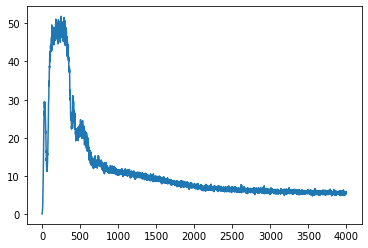

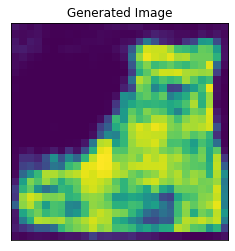

checkpointing at epoch: 4000
Iteration [4001/10000]......0.114(s) gen: -4.81625 - disc_fake: 5.04591 - disc_real: 10.69308 - disc_real: 5.64717
Iteration [4002/10000]......0.115(s) gen: -5.66780 - disc_fake: 5.04593 - disc_real: 10.91869 - disc_real: 5.87276
Iteration [4003/10000]......0.114(s) gen: -5.70712 - disc_fake: 6.08856 - disc_real: 11.98680 - disc_real: 5.89824
Iteration [4004/10000]......0.116(s) gen: -5.93404 - disc_fake: 5.46991 - disc_real: 11.09729 - disc_real: 5.62739
Iteration [4005/10000]......0.114(s) gen: -4.75044 - disc_fake: 5.63692 - disc_real: 11.78167 - disc_real: 6.14474
Iteration [4006/10000]......0.115(s) gen: -4.31635 - disc_fake: 5.20151 - disc_real: 10.62613 - disc_real: 5.42462
Iteration [4007/10000]......0.114(s) gen: -6.25953 - disc_fake: 4.57110 - disc_real: 10.74068 - disc_real: 6.16957
Iteration [4008/10000]......0.115(s) gen: -7.15372 - disc_fake: 6.86966 - disc_real: 12.50856 - disc_real: 5.63889
Iteration [4009/10000]......0.114(s) gen: -6.19182 

Iteration [4072/10000]......0.119(s) gen: -6.39334 - disc_fake: 6.56622 - disc_real: 12.43576 - disc_real: 5.86954
Iteration [4073/10000]......0.120(s) gen: -6.46824 - disc_fake: 6.10591 - disc_real: 11.31994 - disc_real: 5.21403
Iteration [4074/10000]......0.119(s) gen: -6.20234 - disc_fake: 6.33340 - disc_real: 12.12596 - disc_real: 5.79255
Iteration [4075/10000]......0.120(s) gen: -6.53689 - disc_fake: 6.53339 - disc_real: 11.99598 - disc_real: 5.46259
Iteration [4076/10000]......0.122(s) gen: -7.11036 - disc_fake: 6.53045 - disc_real: 12.10586 - disc_real: 5.57540
Iteration [4077/10000]......0.122(s) gen: -6.82118 - disc_fake: 6.90739 - disc_real: 12.06365 - disc_real: 5.15626
Iteration [4078/10000]......0.122(s) gen: -5.97588 - disc_fake: 6.57566 - disc_real: 11.61743 - disc_real: 5.04178
Iteration [4079/10000]......0.124(s) gen: -7.50173 - disc_fake: 6.65750 - disc_real: 12.43315 - disc_real: 5.77565
Iteration [4080/10000]......0.122(s) gen: -6.51662 - disc_fake: 6.99048 - disc_r

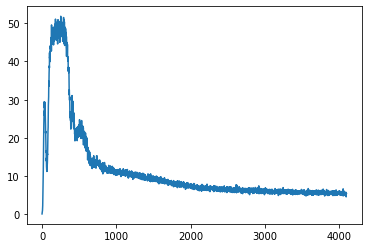

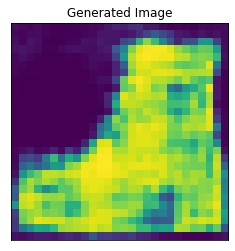

Iteration [4101/10000]......0.123(s) gen: -7.34917 - disc_fake: 6.63461 - disc_real: 12.07571 - disc_real: 5.44110
Iteration [4102/10000]......0.126(s) gen: -6.64576 - disc_fake: 6.47198 - disc_real: 11.47707 - disc_real: 5.00510
Iteration [4103/10000]......0.120(s) gen: -7.11828 - disc_fake: 7.15711 - disc_real: 12.38546 - disc_real: 5.22835
Iteration [4104/10000]......0.117(s) gen: -7.30358 - disc_fake: 7.15287 - disc_real: 12.54770 - disc_real: 5.39483
Iteration [4105/10000]......0.119(s) gen: -6.86973 - disc_fake: 6.86931 - disc_real: 13.02184 - disc_real: 6.15254
Iteration [4106/10000]......0.121(s) gen: -6.50239 - disc_fake: 6.52201 - disc_real: 11.70410 - disc_real: 5.18208
Iteration [4107/10000]......0.121(s) gen: -5.78663 - disc_fake: 5.59644 - disc_real: 11.17980 - disc_real: 5.58336
Iteration [4108/10000]......0.121(s) gen: -4.63819 - disc_fake: 5.50719 - disc_real: 11.04989 - disc_real: 5.54270
Iteration [4109/10000]......0.120(s) gen: -6.27808 - disc_fake: 5.77795 - disc_r

Iteration [4173/10000]......0.123(s) gen: -7.46929 - disc_fake: 6.69059 - disc_real: 12.55450 - disc_real: 5.86391
Iteration [4174/10000]......0.122(s) gen: -7.02830 - disc_fake: 7.56169 - disc_real: 12.12775 - disc_real: 4.56606
Iteration [4175/10000]......0.121(s) gen: -7.56368 - disc_fake: 8.20173 - disc_real: 13.51241 - disc_real: 5.31068
Iteration [4176/10000]......0.120(s) gen: -6.49236 - disc_fake: 6.96447 - disc_real: 13.09963 - disc_real: 6.13515
Iteration [4177/10000]......0.118(s) gen: -6.14272 - disc_fake: 6.84175 - disc_real: 12.24290 - disc_real: 5.40115
Iteration [4178/10000]......0.119(s) gen: -6.36144 - disc_fake: 6.50523 - disc_real: 12.13010 - disc_real: 5.62487
Iteration [4179/10000]......0.119(s) gen: -6.78067 - disc_fake: 6.15585 - disc_real: 11.75425 - disc_real: 5.59840
Iteration [4180/10000]......0.118(s) gen: -7.08068 - disc_fake: 6.39426 - disc_real: 11.97664 - disc_real: 5.58238
Iteration [4181/10000]......0.121(s) gen: -5.70725 - disc_fake: 7.11581 - disc_r

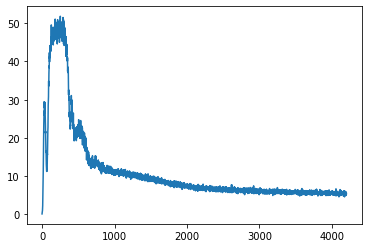

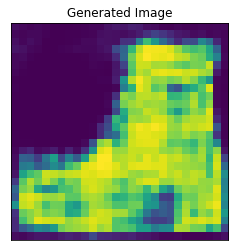

Iteration [4201/10000]......0.117(s) gen: -5.39867 - disc_fake: 5.22459 - disc_real: 11.42305 - disc_real: 6.19846
Iteration [4202/10000]......0.115(s) gen: -6.26592 - disc_fake: 6.68423 - disc_real: 11.78991 - disc_real: 5.10568
Iteration [4203/10000]......0.114(s) gen: -6.80960 - disc_fake: 6.20747 - disc_real: 12.00752 - disc_real: 5.80005
Iteration [4204/10000]......0.115(s) gen: -7.05537 - disc_fake: 7.05721 - disc_real: 12.37863 - disc_real: 5.32142
Iteration [4205/10000]......0.115(s) gen: -6.76695 - disc_fake: 7.19041 - disc_real: 12.77171 - disc_real: 5.58130
Iteration [4206/10000]......0.115(s) gen: -7.00086 - disc_fake: 6.68213 - disc_real: 12.06990 - disc_real: 5.38777
Iteration [4207/10000]......0.116(s) gen: -6.67157 - disc_fake: 6.34994 - disc_real: 12.36247 - disc_real: 6.01254
Iteration [4208/10000]......0.115(s) gen: -6.47824 - disc_fake: 6.56296 - disc_real: 11.73804 - disc_real: 5.17508
Iteration [4209/10000]......0.114(s) gen: -6.64775 - disc_fake: 7.09570 - disc_r

Iteration [4274/10000]......0.121(s) gen: -6.58222 - disc_fake: 7.04035 - disc_real: 12.51060 - disc_real: 5.47025
Iteration [4275/10000]......0.124(s) gen: -6.53881 - disc_fake: 6.69226 - disc_real: 12.01221 - disc_real: 5.31995
Iteration [4276/10000]......0.122(s) gen: -5.95149 - disc_fake: 7.03046 - disc_real: 12.20829 - disc_real: 5.17784
Iteration [4277/10000]......0.122(s) gen: -6.63599 - disc_fake: 6.37242 - disc_real: 11.87023 - disc_real: 5.49781
Iteration [4278/10000]......0.121(s) gen: -7.21845 - disc_fake: 7.55174 - disc_real: 12.80385 - disc_real: 5.25212
Iteration [4279/10000]......0.121(s) gen: -6.28467 - disc_fake: 6.84401 - disc_real: 12.04534 - disc_real: 5.20133
Iteration [4280/10000]......0.131(s) gen: -5.51794 - disc_fake: 6.65766 - disc_real: 11.58718 - disc_real: 4.92952
Iteration [4281/10000]......0.120(s) gen: -7.52934 - disc_fake: 7.03976 - disc_real: 12.35964 - disc_real: 5.31988
Iteration [4282/10000]......0.125(s) gen: -6.58640 - disc_fake: 7.47808 - disc_r

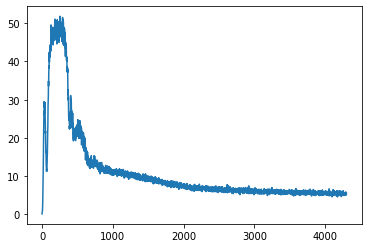

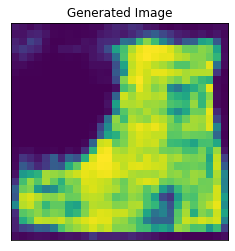

Iteration [4301/10000]......0.118(s) gen: -7.02568 - disc_fake: 7.49265 - disc_real: 12.71584 - disc_real: 5.22319
Iteration [4302/10000]......0.118(s) gen: -6.37314 - disc_fake: 7.02793 - disc_real: 12.36696 - disc_real: 5.33903
Iteration [4303/10000]......0.119(s) gen: -6.32612 - disc_fake: 5.76035 - disc_real: 11.31400 - disc_real: 5.55365
Iteration [4304/10000]......0.119(s) gen: -6.34664 - disc_fake: 6.86843 - disc_real: 11.76747 - disc_real: 4.89903
Iteration [4305/10000]......0.121(s) gen: -6.26916 - disc_fake: 7.06839 - disc_real: 12.21440 - disc_real: 5.14602
Iteration [4306/10000]......0.123(s) gen: -5.64793 - disc_fake: 6.28911 - disc_real: 11.52071 - disc_real: 5.23160
Iteration [4307/10000]......0.123(s) gen: -7.12464 - disc_fake: 6.81459 - disc_real: 12.27108 - disc_real: 5.45649
Iteration [4308/10000]......0.122(s) gen: -6.75715 - disc_fake: 7.29785 - disc_real: 12.90350 - disc_real: 5.60565
Iteration [4309/10000]......0.122(s) gen: -6.44272 - disc_fake: 6.75241 - disc_r

Iteration [4373/10000]......0.126(s) gen: -6.24211 - disc_fake: 6.21880 - disc_real: 12.48136 - disc_real: 6.26256
Iteration [4374/10000]......0.123(s) gen: -6.64021 - disc_fake: 6.56225 - disc_real: 11.78817 - disc_real: 5.22592
Iteration [4375/10000]......0.123(s) gen: -5.89196 - disc_fake: 6.45550 - disc_real: 11.99076 - disc_real: 5.53525
Iteration [4376/10000]......0.118(s) gen: -6.76900 - disc_fake: 6.53729 - disc_real: 11.86740 - disc_real: 5.33011
Iteration [4377/10000]......0.119(s) gen: -6.90008 - disc_fake: 7.12343 - disc_real: 12.38105 - disc_real: 5.25762
Iteration [4378/10000]......0.119(s) gen: -5.33532 - disc_fake: 7.50721 - disc_real: 12.34876 - disc_real: 4.84155
Iteration [4379/10000]......0.119(s) gen: -6.49180 - disc_fake: 5.83267 - disc_real: 11.18066 - disc_real: 5.34800
Iteration [4380/10000]......0.119(s) gen: -6.60305 - disc_fake: 6.77327 - disc_real: 12.22553 - disc_real: 5.45226
Iteration [4381/10000]......0.119(s) gen: -6.33410 - disc_fake: 5.99873 - disc_r

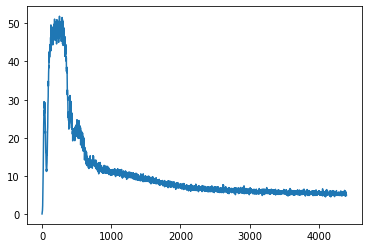

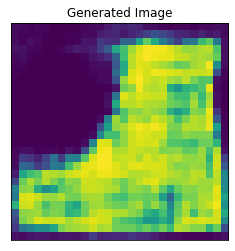

Iteration [4401/10000]......0.115(s) gen: -6.60650 - disc_fake: 7.41392 - disc_real: 12.87212 - disc_real: 5.45820
Iteration [4402/10000]......0.119(s) gen: -6.84452 - disc_fake: 6.48771 - disc_real: 11.38318 - disc_real: 4.89546
Iteration [4403/10000]......0.119(s) gen: -6.16504 - disc_fake: 6.71751 - disc_real: 12.50712 - disc_real: 5.78961
Iteration [4404/10000]......0.120(s) gen: -7.33419 - disc_fake: 6.58916 - disc_real: 11.93262 - disc_real: 5.34346
Iteration [4405/10000]......0.118(s) gen: -8.10084 - disc_fake: 7.35018 - disc_real: 12.40269 - disc_real: 5.05252
Iteration [4406/10000]......0.120(s) gen: -7.98122 - disc_fake: 8.66123 - disc_real: 13.66900 - disc_real: 5.00777
Iteration [4407/10000]......0.117(s) gen: -7.60609 - disc_fake: 7.75516 - disc_real: 13.09813 - disc_real: 5.34297
Iteration [4408/10000]......0.118(s) gen: -6.98459 - disc_fake: 7.05831 - disc_real: 12.66940 - disc_real: 5.61109
Iteration [4409/10000]......0.121(s) gen: -7.21544 - disc_fake: 7.48328 - disc_r

Iteration [4473/10000]......0.118(s) gen: -6.96102 - disc_fake: 6.76902 - disc_real: 12.27580 - disc_real: 5.50678
Iteration [4474/10000]......0.118(s) gen: -7.23557 - disc_fake: 6.50231 - disc_real: 11.75899 - disc_real: 5.25668
Iteration [4475/10000]......0.119(s) gen: -8.43445 - disc_fake: 8.18794 - disc_real: 13.03142 - disc_real: 4.84348
Iteration [4476/10000]......0.119(s) gen: -7.07438 - disc_fake: 7.87838 - disc_real: 12.71057 - disc_real: 4.83219
Iteration [4477/10000]......0.121(s) gen: -7.32977 - disc_fake: 7.56636 - disc_real: 12.89072 - disc_real: 5.32435
Iteration [4478/10000]......0.120(s) gen: -8.54043 - disc_fake: 8.01081 - disc_real: 12.92184 - disc_real: 4.91103
Iteration [4479/10000]......0.120(s) gen: -7.92743 - disc_fake: 8.53128 - disc_real: 13.55915 - disc_real: 5.02787
Iteration [4480/10000]......0.120(s) gen: -7.22614 - disc_fake: 7.38431 - disc_real: 12.77531 - disc_real: 5.39100
Iteration [4481/10000]......0.120(s) gen: -6.89252 - disc_fake: 7.49516 - disc_r

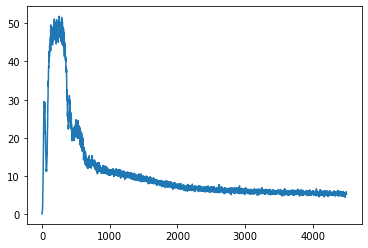

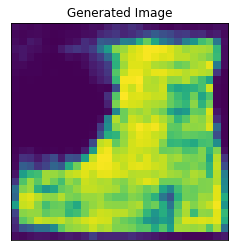

Iteration [4501/10000]......0.116(s) gen: -8.99487 - disc_fake: 8.85673 - disc_real: 14.36243 - disc_real: 5.50569
Iteration [4502/10000]......0.120(s) gen: -6.90822 - disc_fake: 8.67062 - disc_real: 13.47656 - disc_real: 4.80594
Iteration [4503/10000]......0.124(s) gen: -7.77944 - disc_fake: 7.78760 - disc_real: 13.09336 - disc_real: 5.30577
Iteration [4504/10000]......0.127(s) gen: -7.96562 - disc_fake: 7.89050 - disc_real: 13.14307 - disc_real: 5.25257
Iteration [4505/10000]......0.130(s) gen: -7.64901 - disc_fake: 8.35880 - disc_real: 13.27159 - disc_real: 4.91278
Iteration [4506/10000]......0.131(s) gen: -8.52243 - disc_fake: 7.99788 - disc_real: 13.39311 - disc_real: 5.39523
Iteration [4507/10000]......0.132(s) gen: -7.21297 - disc_fake: 8.01975 - disc_real: 13.68973 - disc_real: 5.66998
Iteration [4508/10000]......0.128(s) gen: -7.97018 - disc_fake: 7.48439 - disc_real: 13.06481 - disc_real: 5.58042
Iteration [4509/10000]......0.127(s) gen: -8.05566 - disc_fake: 7.71561 - disc_r

Iteration [4573/10000]......0.117(s) gen: -7.95110 - disc_fake: 7.96621 - disc_real: 13.16759 - disc_real: 5.20138
Iteration [4574/10000]......0.118(s) gen: -7.13500 - disc_fake: 7.81514 - disc_real: 13.40104 - disc_real: 5.58590
Iteration [4575/10000]......0.117(s) gen: -9.31501 - disc_fake: 8.15501 - disc_real: 13.43721 - disc_real: 5.28219
Iteration [4576/10000]......0.117(s) gen: -8.09779 - disc_fake: 8.76012 - disc_real: 13.63807 - disc_real: 4.87795
Iteration [4577/10000]......0.118(s) gen: -7.31062 - disc_fake: 7.79585 - disc_real: 13.32749 - disc_real: 5.53164
Iteration [4578/10000]......0.117(s) gen: -7.13704 - disc_fake: 7.55527 - disc_real: 12.80475 - disc_real: 5.24948
Iteration [4579/10000]......0.117(s) gen: -9.54581 - disc_fake: 7.91641 - disc_real: 13.15875 - disc_real: 5.24234
Iteration [4580/10000]......0.117(s) gen: -6.40797 - disc_fake: 8.59951 - disc_real: 13.75246 - disc_real: 5.15295
Iteration [4581/10000]......0.119(s) gen: -7.44941 - disc_fake: 7.28788 - disc_r

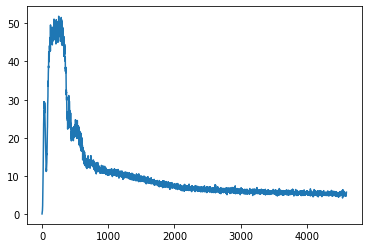

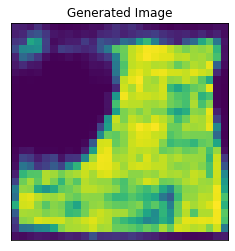

Iteration [4601/10000]......0.121(s) gen: -8.16621 - disc_fake: 8.31341 - disc_real: 14.07828 - disc_real: 5.76487
Iteration [4602/10000]......0.127(s) gen: -7.11927 - disc_fake: 7.69493 - disc_real: 12.83579 - disc_real: 5.14087
Iteration [4603/10000]......0.117(s) gen: -7.67363 - disc_fake: 8.03055 - disc_real: 12.88056 - disc_real: 4.85001
Iteration [4604/10000]......0.120(s) gen: -6.62660 - disc_fake: 7.09441 - disc_real: 12.75177 - disc_real: 5.65736
Iteration [4605/10000]......0.116(s) gen: -8.56674 - disc_fake: 7.46644 - disc_real: 13.11343 - disc_real: 5.64699
Iteration [4606/10000]......0.121(s) gen: -8.37592 - disc_fake: 8.44256 - disc_real: 13.56138 - disc_real: 5.11882
Iteration [4607/10000]......0.119(s) gen: -8.71812 - disc_fake: 8.20746 - disc_real: 13.70546 - disc_real: 5.49800
Iteration [4608/10000]......0.116(s) gen: -8.93656 - disc_fake: 9.07019 - disc_real: 14.21996 - disc_real: 5.14978
Iteration [4609/10000]......0.117(s) gen: -7.76905 - disc_fake: 8.44851 - disc_r

Iteration [4674/10000]......0.121(s) gen: -8.14225 - disc_fake: 8.87354 - disc_real: 14.85891 - disc_real: 5.98537
Iteration [4675/10000]......0.119(s) gen: -8.02041 - disc_fake: 8.06465 - disc_real: 13.75162 - disc_real: 5.68697
Iteration [4676/10000]......0.119(s) gen: -8.10625 - disc_fake: 8.31921 - disc_real: 12.79208 - disc_real: 4.47288
Iteration [4677/10000]......0.119(s) gen: -7.22666 - disc_fake: 7.05151 - disc_real: 12.45651 - disc_real: 5.40501
Iteration [4678/10000]......0.120(s) gen: -7.62467 - disc_fake: 8.08060 - disc_real: 13.25861 - disc_real: 5.17801
Iteration [4679/10000]......0.121(s) gen: -7.84981 - disc_fake: 8.06153 - disc_real: 13.41448 - disc_real: 5.35295
Iteration [4680/10000]......0.122(s) gen: -7.29183 - disc_fake: 7.95548 - disc_real: 13.34311 - disc_real: 5.38763
Iteration [4681/10000]......0.120(s) gen: -8.99182 - disc_fake: 7.78651 - disc_real: 13.16738 - disc_real: 5.38087
Iteration [4682/10000]......0.120(s) gen: -8.11926 - disc_fake: 9.43472 - disc_r

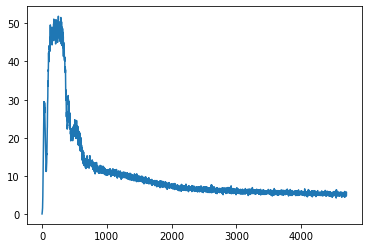

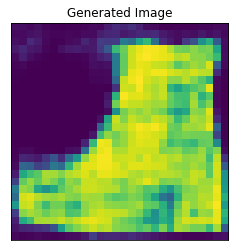

Iteration [4701/10000]......0.117(s) gen: -8.08442 - disc_fake: 9.00655 - disc_real: 13.91953 - disc_real: 4.91298
Iteration [4702/10000]......0.116(s) gen: -8.96153 - disc_fake: 8.56851 - disc_real: 13.66684 - disc_real: 5.09833
Iteration [4703/10000]......0.118(s) gen: -9.25627 - disc_fake: 9.04626 - disc_real: 14.59165 - disc_real: 5.54539
Iteration [4704/10000]......0.117(s) gen: -8.43661 - disc_fake: 9.05611 - disc_real: 15.03245 - disc_real: 5.97634
Iteration [4705/10000]......0.124(s) gen: -8.39955 - disc_fake: 8.07704 - disc_real: 13.28567 - disc_real: 5.20863
Iteration [4706/10000]......0.118(s) gen: -7.52447 - disc_fake: 8.74687 - disc_real: 13.22506 - disc_real: 4.47818
Iteration [4707/10000]......0.121(s) gen: -8.74910 - disc_fake: 8.04347 - disc_real: 13.69720 - disc_real: 5.65373
Iteration [4708/10000]......0.131(s) gen: -8.76400 - disc_fake: 8.44448 - disc_real: 13.78148 - disc_real: 5.33700
Iteration [4709/10000]......0.117(s) gen: -7.82956 - disc_fake: 8.51634 - disc_r

Iteration [4773/10000]......0.123(s) gen: -8.77394 - disc_fake: 8.75953 - disc_real: 14.09320 - disc_real: 5.33367
Iteration [4774/10000]......0.122(s) gen: -10.19355 - disc_fake: 9.12762 - disc_real: 14.49143 - disc_real: 5.36381
Iteration [4775/10000]......0.122(s) gen: -9.47580 - disc_fake: 9.18892 - disc_real: 14.49867 - disc_real: 5.30975
Iteration [4776/10000]......0.124(s) gen: -8.62617 - disc_fake: 9.52105 - disc_real: 14.55305 - disc_real: 5.03200
Iteration [4777/10000]......0.123(s) gen: -8.28526 - disc_fake: 8.65949 - disc_real: 13.69886 - disc_real: 5.03937
Iteration [4778/10000]......0.123(s) gen: -9.85529 - disc_fake: 9.22374 - disc_real: 14.08072 - disc_real: 4.85697
Iteration [4779/10000]......0.124(s) gen: -9.12162 - disc_fake: 9.33669 - disc_real: 15.09449 - disc_real: 5.75780
Iteration [4780/10000]......0.123(s) gen: -8.26215 - disc_fake: 8.75982 - disc_real: 13.93629 - disc_real: 5.17648
Iteration [4781/10000]......0.124(s) gen: -8.32888 - disc_fake: 8.24849 - disc_

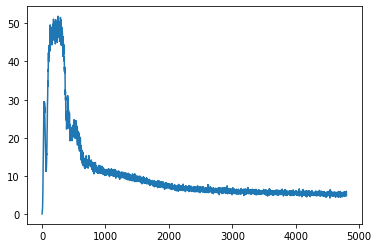

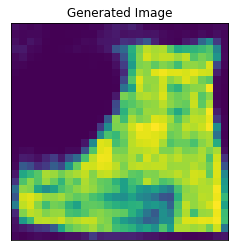

Iteration [4801/10000]......0.115(s) gen: -8.65045 - disc_fake: 8.15717 - disc_real: 13.39905 - disc_real: 5.24188
Iteration [4802/10000]......0.128(s) gen: -8.02735 - disc_fake: 8.06485 - disc_real: 13.08588 - disc_real: 5.02103
Iteration [4803/10000]......0.126(s) gen: -8.85215 - disc_fake: 8.46870 - disc_real: 14.34114 - disc_real: 5.87244
Iteration [4804/10000]......0.125(s) gen: -9.27140 - disc_fake: 9.32429 - disc_real: 14.04263 - disc_real: 4.71833
Iteration [4805/10000]......0.122(s) gen: -7.69831 - disc_fake: 8.90976 - disc_real: 13.99944 - disc_real: 5.08968
Iteration [4806/10000]......0.116(s) gen: -7.11049 - disc_fake: 8.21859 - disc_real: 13.88248 - disc_real: 5.66389
Iteration [4807/10000]......0.117(s) gen: -7.46425 - disc_fake: 8.20066 - disc_real: 13.54807 - disc_real: 5.34741
Iteration [4808/10000]......0.140(s) gen: -7.71291 - disc_fake: 7.44686 - disc_real: 12.24164 - disc_real: 4.79477
Iteration [4809/10000]......0.128(s) gen: -7.21930 - disc_fake: 7.48551 - disc_r

Iteration [4874/10000]......0.119(s) gen: -9.70712 - disc_fake: 9.28701 - disc_real: 14.64846 - disc_real: 5.36145
Iteration [4875/10000]......0.118(s) gen: -7.56292 - disc_fake: 8.91833 - disc_real: 13.96091 - disc_real: 5.04258
Iteration [4876/10000]......0.122(s) gen: -7.93073 - disc_fake: 8.63351 - disc_real: 14.15289 - disc_real: 5.51939
Iteration [4877/10000]......0.119(s) gen: -8.65885 - disc_fake: 8.83384 - disc_real: 14.12684 - disc_real: 5.29300
Iteration [4878/10000]......0.118(s) gen: -9.27554 - disc_fake: 8.65206 - disc_real: 13.89698 - disc_real: 5.24492
Iteration [4879/10000]......0.118(s) gen: -8.00561 - disc_fake: 9.00084 - disc_real: 14.77138 - disc_real: 5.77054
Iteration [4880/10000]......0.117(s) gen: -7.71884 - disc_fake: 8.10571 - disc_real: 13.17227 - disc_real: 5.06656
Iteration [4881/10000]......0.117(s) gen: -9.49795 - disc_fake: 8.72799 - disc_real: 13.57050 - disc_real: 4.84251
Iteration [4882/10000]......0.119(s) gen: -9.49934 - disc_fake: 9.26993 - disc_r

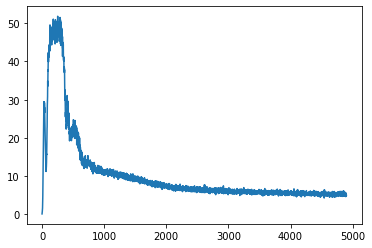

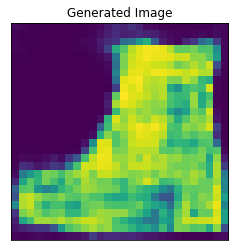

Iteration [4901/10000]......0.116(s) gen: -8.86815 - disc_fake: 8.91613 - disc_real: 14.80014 - disc_real: 5.88401
Iteration [4902/10000]......0.116(s) gen: -8.95499 - disc_fake: 8.65076 - disc_real: 13.92591 - disc_real: 5.27515
Iteration [4903/10000]......0.118(s) gen: -8.87193 - disc_fake: 9.63989 - disc_real: 14.61041 - disc_real: 4.97052
Iteration [4904/10000]......0.129(s) gen: -8.30309 - disc_fake: 8.41364 - disc_real: 13.43551 - disc_real: 5.02187
Iteration [4905/10000]......0.126(s) gen: -8.77266 - disc_fake: 8.33528 - disc_real: 13.56624 - disc_real: 5.23096
Iteration [4906/10000]......0.118(s) gen: -8.90520 - disc_fake: 8.77227 - disc_real: 13.42006 - disc_real: 4.64779
Iteration [4907/10000]......0.119(s) gen: -8.71803 - disc_fake: 8.60755 - disc_real: 13.61485 - disc_real: 5.00730
Iteration [4908/10000]......0.118(s) gen: -9.36369 - disc_fake: 9.24868 - disc_real: 14.04542 - disc_real: 4.79674
Iteration [4909/10000]......0.118(s) gen: -9.00083 - disc_fake: 9.52563 - disc_r

Iteration [4972/10000]......0.120(s) gen: -8.70707 - disc_fake: 8.36342 - disc_real: 13.67389 - disc_real: 5.31047
Iteration [4973/10000]......0.121(s) gen: -7.83937 - disc_fake: 9.01302 - disc_real: 13.71394 - disc_real: 4.70092
Iteration [4974/10000]......0.118(s) gen: -8.36095 - disc_fake: 8.18497 - disc_real: 13.93240 - disc_real: 5.74743
Iteration [4975/10000]......0.120(s) gen: -9.58940 - disc_fake: 9.06037 - disc_real: 13.68404 - disc_real: 4.62367
Iteration [4976/10000]......0.121(s) gen: -8.68388 - disc_fake: 8.78525 - disc_real: 14.13363 - disc_real: 5.34838
Iteration [4977/10000]......0.122(s) gen: -9.24014 - disc_fake: 8.62541 - disc_real: 13.67310 - disc_real: 5.04769
Iteration [4978/10000]......0.121(s) gen: -8.45582 - disc_fake: 9.22883 - disc_real: 14.41457 - disc_real: 5.18574
Iteration [4979/10000]......0.120(s) gen: -9.40984 - disc_fake: 9.54144 - disc_real: 14.45900 - disc_real: 4.91756
Iteration [4980/10000]......0.120(s) gen: -9.04321 - disc_fake: 8.71610 - disc_r

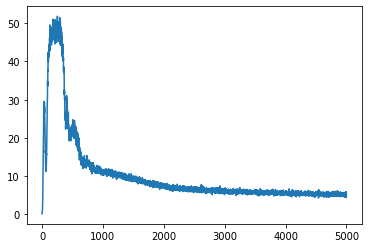

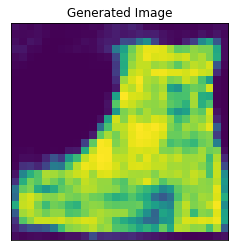

Iteration [5001/10000]......0.116(s) gen: -7.45576 - disc_fake: 9.03086 - disc_real: 14.64238 - disc_real: 5.61152
Iteration [5002/10000]......0.116(s) gen: -9.92916 - disc_fake: 8.98165 - disc_real: 13.99125 - disc_real: 5.00960
Iteration [5003/10000]......0.114(s) gen: -9.47019 - disc_fake: 9.42966 - disc_real: 14.16616 - disc_real: 4.73650
Iteration [5004/10000]......0.115(s) gen: -9.41095 - disc_fake: 9.73458 - disc_real: 14.90304 - disc_real: 5.16846
Iteration [5005/10000]......0.117(s) gen: -9.93495 - disc_fake: 9.34460 - disc_real: 14.86140 - disc_real: 5.51681
Iteration [5006/10000]......0.117(s) gen: -8.92089 - disc_fake: 9.94405 - disc_real: 14.38552 - disc_real: 4.44148
Iteration [5007/10000]......0.116(s) gen: -8.95632 - disc_fake: 9.37891 - disc_real: 14.83702 - disc_real: 5.45811
Iteration [5008/10000]......0.117(s) gen: -8.89071 - disc_fake: 9.28611 - disc_real: 14.37342 - disc_real: 5.08731
Iteration [5009/10000]......0.117(s) gen: -9.82445 - disc_fake: 9.42499 - disc_r

Iteration [5072/10000]......0.120(s) gen: -9.57556 - disc_fake: 9.91825 - disc_real: 14.77294 - disc_real: 4.85469
Iteration [5073/10000]......0.119(s) gen: -9.10328 - disc_fake: 9.40303 - disc_real: 14.29128 - disc_real: 4.88825
Iteration [5074/10000]......0.118(s) gen: -8.73832 - disc_fake: 8.77206 - disc_real: 14.47888 - disc_real: 5.70682
Iteration [5075/10000]......0.118(s) gen: -9.70927 - disc_fake: 9.18482 - disc_real: 14.22626 - disc_real: 5.04144
Iteration [5076/10000]......0.119(s) gen: -10.42903 - disc_fake: 9.70391 - disc_real: 14.74670 - disc_real: 5.04279
Iteration [5077/10000]......0.118(s) gen: -9.91941 - disc_fake: 10.09164 - disc_real: 15.40973 - disc_real: 5.31809
Iteration [5078/10000]......0.120(s) gen: -9.60165 - disc_fake: 10.43446 - disc_real: 15.35542 - disc_real: 4.92096
Iteration [5079/10000]......0.118(s) gen: -10.50098 - disc_fake: 9.62882 - disc_real: 15.43863 - disc_real: 5.80981
Iteration [5080/10000]......0.119(s) gen: -9.13242 - disc_fake: 9.90815 - di

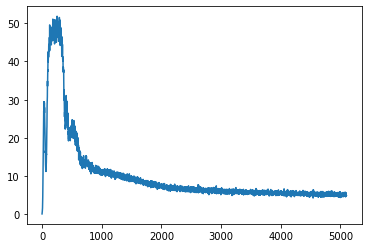

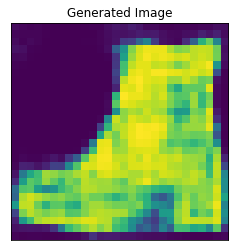

Iteration [5101/10000]......0.119(s) gen: -9.15281 - disc_fake: 8.74762 - disc_real: 14.08143 - disc_real: 5.33382
Iteration [5102/10000]......0.128(s) gen: -9.57598 - disc_fake: 9.63632 - disc_real: 14.66876 - disc_real: 5.03244
Iteration [5103/10000]......0.126(s) gen: -9.70839 - disc_fake: 9.86517 - disc_real: 15.09591 - disc_real: 5.23074
Iteration [5104/10000]......0.126(s) gen: -9.03329 - disc_fake: 9.25783 - disc_real: 14.46779 - disc_real: 5.20996
Iteration [5105/10000]......0.129(s) gen: -9.07023 - disc_fake: 8.78306 - disc_real: 13.98056 - disc_real: 5.19750
Iteration [5106/10000]......0.129(s) gen: -9.77159 - disc_fake: 9.76108 - disc_real: 14.46336 - disc_real: 4.70228
Iteration [5107/10000]......0.128(s) gen: -9.52828 - disc_fake: 10.06479 - disc_real: 15.19607 - disc_real: 5.13128
Iteration [5108/10000]......0.126(s) gen: -9.41768 - disc_fake: 10.03125 - disc_real: 14.84712 - disc_real: 4.81586
Iteration [5109/10000]......0.127(s) gen: -10.29494 - disc_fake: 9.68156 - dis

Iteration [5172/10000]......0.121(s) gen: -9.83149 - disc_fake: 9.83976 - disc_real: 14.63701 - disc_real: 4.79725
Iteration [5173/10000]......0.121(s) gen: -9.88062 - disc_fake: 10.04373 - disc_real: 15.68369 - disc_real: 5.63996
Iteration [5174/10000]......0.120(s) gen: -10.35040 - disc_fake: 10.10138 - disc_real: 15.37944 - disc_real: 5.27807
Iteration [5175/10000]......0.122(s) gen: -9.81841 - disc_fake: 9.67968 - disc_real: 14.95792 - disc_real: 5.27824
Iteration [5176/10000]......0.121(s) gen: -9.15651 - disc_fake: 9.79641 - disc_real: 14.96150 - disc_real: 5.16509
Iteration [5177/10000]......0.120(s) gen: -10.06494 - disc_fake: 8.91505 - disc_real: 14.09913 - disc_real: 5.18408
Iteration [5178/10000]......0.121(s) gen: -9.30354 - disc_fake: 9.24187 - disc_real: 14.45279 - disc_real: 5.21092
Iteration [5179/10000]......0.120(s) gen: -9.41476 - disc_fake: 8.72118 - disc_real: 13.94935 - disc_real: 5.22818
Iteration [5180/10000]......0.121(s) gen: -10.19812 - disc_fake: 9.33359 - d

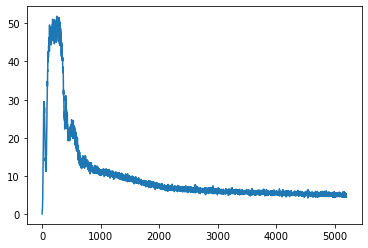

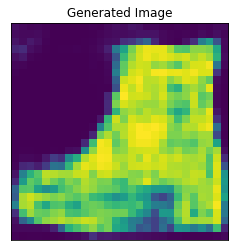

Iteration [5201/10000]......0.117(s) gen: -7.86366 - disc_fake: 8.45179 - disc_real: 13.92278 - disc_real: 5.47099
Iteration [5202/10000]......0.115(s) gen: -9.72310 - disc_fake: 9.41966 - disc_real: 14.81914 - disc_real: 5.39948
Iteration [5203/10000]......0.118(s) gen: -10.77040 - disc_fake: 10.57563 - disc_real: 15.00724 - disc_real: 4.43161
Iteration [5204/10000]......0.120(s) gen: -10.38289 - disc_fake: 10.55075 - disc_real: 15.58221 - disc_real: 5.03146
Iteration [5205/10000]......0.121(s) gen: -9.06195 - disc_fake: 9.71938 - disc_real: 14.57323 - disc_real: 4.85385
Iteration [5206/10000]......0.118(s) gen: -9.98873 - disc_fake: 8.83591 - disc_real: 13.45201 - disc_real: 4.61609
Iteration [5207/10000]......0.119(s) gen: -9.80749 - disc_fake: 9.39934 - disc_real: 14.32306 - disc_real: 4.92372
Iteration [5208/10000]......0.118(s) gen: -10.49247 - disc_fake: 9.81153 - disc_real: 14.94084 - disc_real: 5.12931
Iteration [5209/10000]......0.119(s) gen: -11.07192 - disc_fake: 9.85616 - 

Iteration [5272/10000]......0.122(s) gen: -10.42912 - disc_fake: 10.56938 - disc_real: 15.68602 - disc_real: 5.11664
Iteration [5273/10000]......0.122(s) gen: -10.08628 - disc_fake: 10.11533 - disc_real: 15.17380 - disc_real: 5.05846
Iteration [5274/10000]......0.121(s) gen: -10.60262 - disc_fake: 10.56289 - disc_real: 16.08682 - disc_real: 5.52394
Iteration [5275/10000]......0.120(s) gen: -8.96586 - disc_fake: 10.14224 - disc_real: 14.80195 - disc_real: 4.65971
Iteration [5276/10000]......0.120(s) gen: -9.90528 - disc_fake: 9.45575 - disc_real: 14.37994 - disc_real: 4.92419
Iteration [5277/10000]......0.120(s) gen: -10.39499 - disc_fake: 9.73374 - disc_real: 15.08197 - disc_real: 5.34823
Iteration [5278/10000]......0.120(s) gen: -8.89380 - disc_fake: 9.42332 - disc_real: 14.34996 - disc_real: 4.92664
Iteration [5279/10000]......0.118(s) gen: -9.33130 - disc_fake: 9.18162 - disc_real: 14.81909 - disc_real: 5.63747
Iteration [5280/10000]......0.119(s) gen: -11.67435 - disc_fake: 9.67267

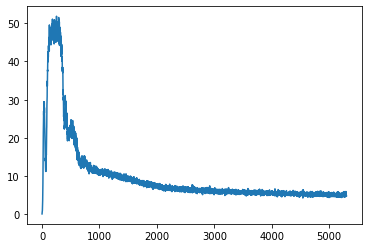

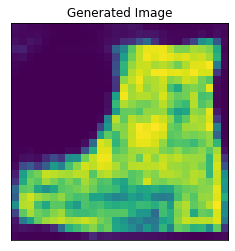

Iteration [5301/10000]......0.120(s) gen: -10.51618 - disc_fake: 10.32184 - disc_real: 15.49012 - disc_real: 5.16828
Iteration [5302/10000]......0.117(s) gen: -10.57897 - disc_fake: 9.67021 - disc_real: 15.29998 - disc_real: 5.62977
Iteration [5303/10000]......0.117(s) gen: -9.67096 - disc_fake: 10.01064 - disc_real: 14.69602 - disc_real: 4.68538
Iteration [5304/10000]......0.118(s) gen: -10.70080 - disc_fake: 10.63711 - disc_real: 15.31496 - disc_real: 4.67785
Iteration [5305/10000]......0.119(s) gen: -10.75192 - disc_fake: 10.27304 - disc_real: 15.31529 - disc_real: 5.04225
Iteration [5306/10000]......0.118(s) gen: -9.86499 - disc_fake: 10.54822 - disc_real: 15.75395 - disc_real: 5.20574
Iteration [5307/10000]......0.120(s) gen: -9.59345 - disc_fake: 10.38383 - disc_real: 15.29003 - disc_real: 4.90620
Iteration [5308/10000]......0.121(s) gen: -9.48671 - disc_fake: 10.30038 - disc_real: 15.08968 - disc_real: 4.78930
Iteration [5309/10000]......0.121(s) gen: -9.61338 - disc_fake: 9.692

Iteration [5372/10000]......0.120(s) gen: -11.55953 - disc_fake: 10.87001 - disc_real: 15.50947 - disc_real: 4.63946
Iteration [5373/10000]......0.119(s) gen: -11.51201 - disc_fake: 11.45311 - disc_real: 16.09594 - disc_real: 4.64283
Iteration [5374/10000]......0.119(s) gen: -11.03079 - disc_fake: 11.55364 - disc_real: 16.59787 - disc_real: 5.04422
Iteration [5375/10000]......0.119(s) gen: -11.05460 - disc_fake: 10.96061 - disc_real: 16.28837 - disc_real: 5.32777
Iteration [5376/10000]......0.119(s) gen: -11.24374 - disc_fake: 10.49620 - disc_real: 15.13688 - disc_real: 4.64068
Iteration [5377/10000]......0.119(s) gen: -10.70652 - disc_fake: 11.43818 - disc_real: 17.02885 - disc_real: 5.59066
Iteration [5378/10000]......0.120(s) gen: -10.27740 - disc_fake: 11.30650 - disc_real: 15.94514 - disc_real: 4.63865
Iteration [5379/10000]......0.120(s) gen: -10.81467 - disc_fake: 10.42014 - disc_real: 15.23452 - disc_real: 4.81439
Iteration [5380/10000]......0.119(s) gen: -11.34496 - disc_fake:

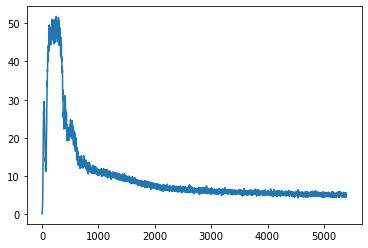

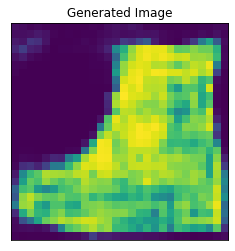

Iteration [5401/10000]......0.135(s) gen: -10.37735 - disc_fake: 10.64891 - disc_real: 15.99493 - disc_real: 5.34603
Iteration [5402/10000]......0.126(s) gen: -10.39808 - disc_fake: 10.74937 - disc_real: 15.97707 - disc_real: 5.22770
Iteration [5403/10000]......0.129(s) gen: -9.91749 - disc_fake: 9.92217 - disc_real: 14.86154 - disc_real: 4.93937
Iteration [5404/10000]......0.134(s) gen: -11.24878 - disc_fake: 10.30272 - disc_real: 15.75956 - disc_real: 5.45684
Iteration [5405/10000]......0.135(s) gen: -10.05361 - disc_fake: 10.82921 - disc_real: 15.35572 - disc_real: 4.52651
Iteration [5406/10000]......0.135(s) gen: -10.62791 - disc_fake: 10.50461 - disc_real: 15.52857 - disc_real: 5.02396
Iteration [5407/10000]......0.133(s) gen: -9.93034 - disc_fake: 10.69729 - disc_real: 15.68331 - disc_real: 4.98602
Iteration [5408/10000]......0.131(s) gen: -11.01266 - disc_fake: 10.29866 - disc_real: 15.44693 - disc_real: 5.14826
Iteration [5409/10000]......0.130(s) gen: -11.11655 - disc_fake: 10

Iteration [5472/10000]......0.120(s) gen: -10.62235 - disc_fake: 10.29426 - disc_real: 16.09535 - disc_real: 5.80109
Iteration [5473/10000]......0.121(s) gen: -10.46408 - disc_fake: 10.72828 - disc_real: 15.23019 - disc_real: 4.50191
Iteration [5474/10000]......0.124(s) gen: -11.30330 - disc_fake: 10.44396 - disc_real: 15.46974 - disc_real: 5.02577
Iteration [5475/10000]......0.121(s) gen: -9.91419 - disc_fake: 11.24085 - disc_real: 16.06605 - disc_real: 4.82520
Iteration [5476/10000]......0.121(s) gen: -10.79596 - disc_fake: 10.02515 - disc_real: 15.57929 - disc_real: 5.55413
Iteration [5477/10000]......0.121(s) gen: -10.47042 - disc_fake: 11.36371 - disc_real: 16.58738 - disc_real: 5.22367
Iteration [5478/10000]......0.124(s) gen: -11.46565 - disc_fake: 11.41155 - disc_real: 16.31235 - disc_real: 4.90080
Iteration [5479/10000]......0.122(s) gen: -10.23867 - disc_fake: 11.19330 - disc_real: 16.09627 - disc_real: 4.90297
Iteration [5480/10000]......0.122(s) gen: -11.56663 - disc_fake: 

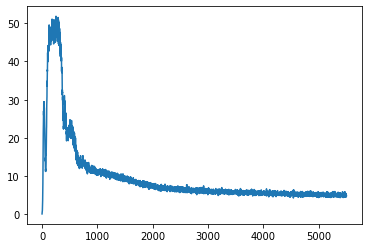

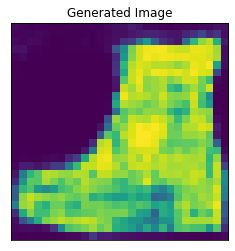

Iteration [5501/10000]......0.118(s) gen: -9.67144 - disc_fake: 10.35090 - disc_real: 15.17702 - disc_real: 4.82612
Iteration [5502/10000]......0.117(s) gen: -10.34332 - disc_fake: 10.02814 - disc_real: 15.23597 - disc_real: 5.20783
Iteration [5503/10000]......0.118(s) gen: -10.18182 - disc_fake: 10.21802 - disc_real: 15.72956 - disc_real: 5.51154
Iteration [5504/10000]......0.121(s) gen: -10.12861 - disc_fake: 10.53248 - disc_real: 15.57348 - disc_real: 5.04100
Iteration [5505/10000]......0.122(s) gen: -10.72747 - disc_fake: 10.91535 - disc_real: 16.20593 - disc_real: 5.29058
Iteration [5506/10000]......0.121(s) gen: -10.14444 - disc_fake: 10.71340 - disc_real: 16.00086 - disc_real: 5.28746
Iteration [5507/10000]......0.124(s) gen: -11.40559 - disc_fake: 10.63832 - disc_real: 15.45311 - disc_real: 4.81479
Iteration [5508/10000]......0.124(s) gen: -10.35815 - disc_fake: 11.63625 - disc_real: 16.23642 - disc_real: 4.60018
Iteration [5509/10000]......0.122(s) gen: -11.00699 - disc_fake: 

Iteration [5572/10000]......0.122(s) gen: -10.27173 - disc_fake: 10.56934 - disc_real: 15.07763 - disc_real: 4.50829
Iteration [5573/10000]......0.119(s) gen: -10.56696 - disc_fake: 10.34122 - disc_real: 15.59194 - disc_real: 5.25072
Iteration [5574/10000]......0.118(s) gen: -10.66482 - disc_fake: 10.37582 - disc_real: 15.64081 - disc_real: 5.26498
Iteration [5575/10000]......0.118(s) gen: -10.41689 - disc_fake: 10.78390 - disc_real: 15.47646 - disc_real: 4.69256
Iteration [5576/10000]......0.120(s) gen: -10.20593 - disc_fake: 10.16318 - disc_real: 14.74049 - disc_real: 4.57731
Iteration [5577/10000]......0.120(s) gen: -10.68584 - disc_fake: 10.49065 - disc_real: 15.44462 - disc_real: 4.95397
Iteration [5578/10000]......0.120(s) gen: -11.29342 - disc_fake: 10.97403 - disc_real: 15.68680 - disc_real: 4.71277
Iteration [5579/10000]......0.119(s) gen: -10.26774 - disc_fake: 10.61917 - disc_real: 15.92893 - disc_real: 5.30976
Iteration [5580/10000]......0.125(s) gen: -9.95448 - disc_fake: 

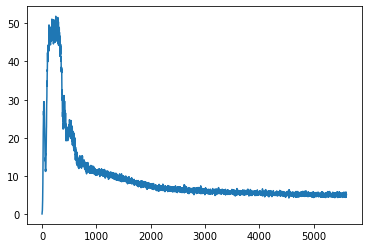

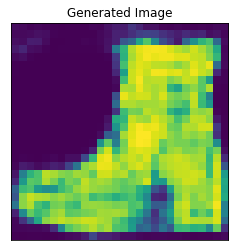

Iteration [5601/10000]......0.121(s) gen: -10.96675 - disc_fake: 11.35020 - disc_real: 16.06198 - disc_real: 4.71178
Iteration [5602/10000]......0.116(s) gen: -11.14217 - disc_fake: 11.04452 - disc_real: 15.79030 - disc_real: 4.74578
Iteration [5603/10000]......0.116(s) gen: -11.53117 - disc_fake: 11.73736 - disc_real: 16.33878 - disc_real: 4.60142
Iteration [5604/10000]......0.116(s) gen: -10.75003 - disc_fake: 11.53552 - disc_real: 16.21437 - disc_real: 4.67885
Iteration [5605/10000]......0.120(s) gen: -10.82609 - disc_fake: 10.60405 - disc_real: 15.70091 - disc_real: 5.09685
Iteration [5606/10000]......0.120(s) gen: -11.93090 - disc_fake: 11.31254 - disc_real: 16.28321 - disc_real: 4.97067
Iteration [5607/10000]......0.116(s) gen: -10.60792 - disc_fake: 11.62141 - disc_real: 16.31235 - disc_real: 4.69095
Iteration [5608/10000]......0.117(s) gen: -11.24808 - disc_fake: 10.71501 - disc_real: 15.33220 - disc_real: 4.61719
Iteration [5609/10000]......0.117(s) gen: -11.70414 - disc_fake:

Iteration [5671/10000]......0.120(s) gen: -11.57824 - disc_fake: 10.98126 - disc_real: 16.37396 - disc_real: 5.39271
Iteration [5672/10000]......0.118(s) gen: -11.46974 - disc_fake: 11.72551 - disc_real: 16.77444 - disc_real: 5.04894
Iteration [5673/10000]......0.121(s) gen: -11.20303 - disc_fake: 11.22681 - disc_real: 15.85866 - disc_real: 4.63186
Iteration [5674/10000]......0.122(s) gen: -11.19057 - disc_fake: 11.57089 - disc_real: 16.44329 - disc_real: 4.87240
Iteration [5675/10000]......0.122(s) gen: -11.23256 - disc_fake: 11.59726 - disc_real: 16.39595 - disc_real: 4.79870
Iteration [5676/10000]......0.121(s) gen: -11.09153 - disc_fake: 11.35633 - disc_real: 16.10095 - disc_real: 4.74463
Iteration [5677/10000]......0.122(s) gen: -10.69339 - disc_fake: 11.71772 - disc_real: 16.28939 - disc_real: 4.57168
Iteration [5678/10000]......0.122(s) gen: -11.74261 - disc_fake: 11.25683 - disc_real: 16.48243 - disc_real: 5.22560
Iteration [5679/10000]......0.121(s) gen: -10.80805 - disc_fake:

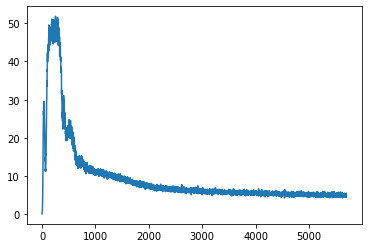

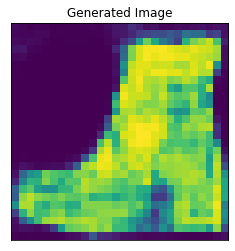

Iteration [5701/10000]......0.120(s) gen: -11.78292 - disc_fake: 11.24857 - disc_real: 15.96650 - disc_real: 4.71793
Iteration [5702/10000]......0.115(s) gen: -10.67943 - disc_fake: 11.80437 - disc_real: 16.75867 - disc_real: 4.95430
Iteration [5703/10000]......0.117(s) gen: -11.56949 - disc_fake: 11.37586 - disc_real: 16.75607 - disc_real: 5.38020
Iteration [5704/10000]......0.117(s) gen: -10.67702 - disc_fake: 11.58286 - disc_real: 16.74826 - disc_real: 5.16540
Iteration [5705/10000]......0.117(s) gen: -11.39487 - disc_fake: 11.27301 - disc_real: 16.35842 - disc_real: 5.08542
Iteration [5706/10000]......0.117(s) gen: -10.60120 - disc_fake: 12.00894 - disc_real: 16.41777 - disc_real: 4.40883
Iteration [5707/10000]......0.117(s) gen: -9.07138 - disc_fake: 10.93801 - disc_real: 15.92929 - disc_real: 4.99127
Iteration [5708/10000]......0.118(s) gen: -11.49363 - disc_fake: 10.05837 - disc_real: 15.59305 - disc_real: 5.53468
Iteration [5709/10000]......0.118(s) gen: -11.30677 - disc_fake: 

Iteration [5771/10000]......0.119(s) gen: -11.81044 - disc_fake: 10.52820 - disc_real: 15.78794 - disc_real: 5.25974
Iteration [5772/10000]......0.120(s) gen: -10.61546 - disc_fake: 11.76494 - disc_real: 16.23700 - disc_real: 4.47206
Iteration [5773/10000]......0.122(s) gen: -12.04025 - disc_fake: 10.76664 - disc_real: 15.61693 - disc_real: 4.85030
Iteration [5774/10000]......0.122(s) gen: -12.16474 - disc_fake: 12.00744 - disc_real: 17.52144 - disc_real: 5.51401
Iteration [5775/10000]......0.120(s) gen: -11.30790 - disc_fake: 11.64376 - disc_real: 16.93975 - disc_real: 5.29600
Iteration [5776/10000]......0.119(s) gen: -11.16410 - disc_fake: 11.48893 - disc_real: 16.59039 - disc_real: 5.10145
Iteration [5777/10000]......0.119(s) gen: -11.76899 - disc_fake: 11.66349 - disc_real: 16.81610 - disc_real: 5.15261
Iteration [5778/10000]......0.119(s) gen: -10.93947 - disc_fake: 11.97215 - disc_real: 16.37562 - disc_real: 4.40347
Iteration [5779/10000]......0.118(s) gen: -11.49076 - disc_fake:

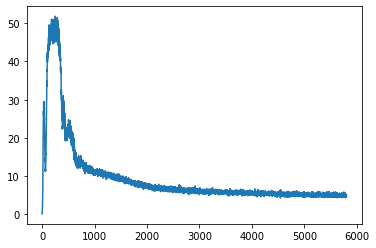

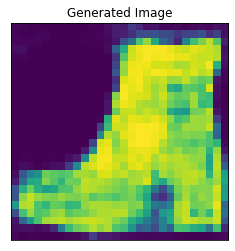

Iteration [5801/10000]......0.121(s) gen: -12.04024 - disc_fake: 12.19267 - disc_real: 17.15077 - disc_real: 4.95810
Iteration [5802/10000]......0.115(s) gen: -12.87508 - disc_fake: 12.32478 - disc_real: 17.76398 - disc_real: 5.43920
Iteration [5803/10000]......0.115(s) gen: -11.06428 - disc_fake: 12.14065 - disc_real: 17.01580 - disc_real: 4.87515
Iteration [5804/10000]......0.115(s) gen: -12.62864 - disc_fake: 12.21002 - disc_real: 17.13540 - disc_real: 4.92538
Iteration [5805/10000]......0.115(s) gen: -12.48395 - disc_fake: 12.29115 - disc_real: 16.85116 - disc_real: 4.56001
Iteration [5806/10000]......0.114(s) gen: -11.59794 - disc_fake: 12.25263 - disc_real: 17.24294 - disc_real: 4.99031
Iteration [5807/10000]......0.114(s) gen: -11.71461 - disc_fake: 11.49966 - disc_real: 17.10474 - disc_real: 5.60508
Iteration [5808/10000]......0.115(s) gen: -12.49114 - disc_fake: 11.37575 - disc_real: 16.80463 - disc_real: 5.42888
Iteration [5809/10000]......0.116(s) gen: -11.98110 - disc_fake:

Iteration [5871/10000]......0.118(s) gen: -12.14748 - disc_fake: 12.33562 - disc_real: 17.23417 - disc_real: 4.89855
Iteration [5872/10000]......0.120(s) gen: -12.09930 - disc_fake: 11.79023 - disc_real: 16.85226 - disc_real: 5.06203
Iteration [5873/10000]......0.119(s) gen: -11.31538 - disc_fake: 11.81324 - disc_real: 16.50702 - disc_real: 4.69378
Iteration [5874/10000]......0.119(s) gen: -11.51281 - disc_fake: 11.30436 - disc_real: 16.07037 - disc_real: 4.76601
Iteration [5875/10000]......0.122(s) gen: -12.30123 - disc_fake: 12.07749 - disc_real: 16.80358 - disc_real: 4.72609
Iteration [5876/10000]......0.123(s) gen: -11.40273 - disc_fake: 12.16189 - disc_real: 17.15630 - disc_real: 4.99441
Iteration [5877/10000]......0.121(s) gen: -11.40851 - disc_fake: 11.57187 - disc_real: 16.63493 - disc_real: 5.06306
Iteration [5878/10000]......0.119(s) gen: -11.54337 - disc_fake: 11.57524 - disc_real: 16.24176 - disc_real: 4.66652
Iteration [5879/10000]......0.121(s) gen: -12.53592 - disc_fake:

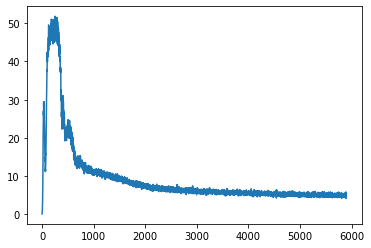

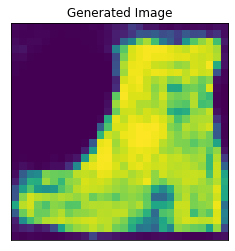

Iteration [5901/10000]......0.116(s) gen: -11.87316 - disc_fake: 11.68581 - disc_real: 16.55156 - disc_real: 4.86575
Iteration [5902/10000]......0.116(s) gen: -12.26151 - disc_fake: 12.31464 - disc_real: 17.15144 - disc_real: 4.83680
Iteration [5903/10000]......0.117(s) gen: -12.11069 - disc_fake: 12.85586 - disc_real: 17.03780 - disc_real: 4.18194
Iteration [5904/10000]......0.116(s) gen: -13.22648 - disc_fake: 12.68550 - disc_real: 17.67040 - disc_real: 4.98491
Iteration [5905/10000]......0.117(s) gen: -13.13619 - disc_fake: 12.68244 - disc_real: 17.93453 - disc_real: 5.25209
Iteration [5906/10000]......0.118(s) gen: -11.14723 - disc_fake: 12.58681 - disc_real: 17.58403 - disc_real: 4.99722
Iteration [5907/10000]......0.118(s) gen: -11.37881 - disc_fake: 11.36453 - disc_real: 17.42368 - disc_real: 6.05915
Iteration [5908/10000]......0.119(s) gen: -11.95750 - disc_fake: 11.80274 - disc_real: 15.90715 - disc_real: 4.10440
Iteration [5909/10000]......0.120(s) gen: -11.47626 - disc_fake:

Iteration [5971/10000]......0.119(s) gen: -11.63821 - disc_fake: 11.99039 - disc_real: 16.56668 - disc_real: 4.57629
Iteration [5972/10000]......0.121(s) gen: -12.51065 - disc_fake: 12.37514 - disc_real: 16.98321 - disc_real: 4.60807
Iteration [5973/10000]......0.121(s) gen: -12.04026 - disc_fake: 12.62328 - disc_real: 17.62150 - disc_real: 4.99822
Iteration [5974/10000]......0.121(s) gen: -12.38027 - disc_fake: 11.93562 - disc_real: 17.20451 - disc_real: 5.26889
Iteration [5975/10000]......0.121(s) gen: -12.19078 - disc_fake: 12.13324 - disc_real: 17.63928 - disc_real: 5.50603
Iteration [5976/10000]......0.121(s) gen: -11.05386 - disc_fake: 11.94995 - disc_real: 16.84197 - disc_real: 4.89202
Iteration [5977/10000]......0.121(s) gen: -10.28517 - disc_fake: 11.50247 - disc_real: 15.77096 - disc_real: 4.26848
Iteration [5978/10000]......0.120(s) gen: -12.30606 - disc_fake: 10.99039 - disc_real: 15.90628 - disc_real: 4.91589
Iteration [5979/10000]......0.122(s) gen: -11.47837 - disc_fake:

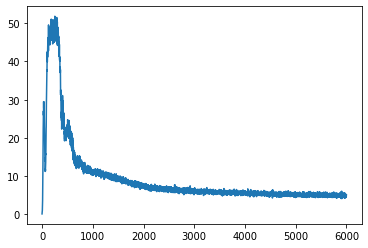

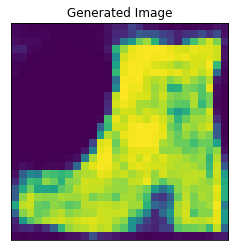

checkpointing at epoch: 6000
Iteration [6001/10000]......0.121(s) gen: -11.06178 - disc_fake: 11.38225 - disc_real: 16.35504 - disc_real: 4.97279
Iteration [6002/10000]......0.118(s) gen: -11.10199 - disc_fake: 11.81913 - disc_real: 16.54737 - disc_real: 4.72825
Iteration [6003/10000]......0.118(s) gen: -11.95376 - disc_fake: 12.62278 - disc_real: 17.46111 - disc_real: 4.83833
Iteration [6004/10000]......0.118(s) gen: -11.26827 - disc_fake: 12.03992 - disc_real: 16.62787 - disc_real: 4.58795
Iteration [6005/10000]......0.119(s) gen: -12.67535 - disc_fake: 12.11448 - disc_real: 16.76980 - disc_real: 4.65532
Iteration [6006/10000]......0.139(s) gen: -12.22680 - disc_fake: 12.53388 - disc_real: 17.16662 - disc_real: 4.63275
Iteration [6007/10000]......0.116(s) gen: -11.48124 - disc_fake: 12.08252 - disc_real: 16.74353 - disc_real: 4.66101
Iteration [6008/10000]......0.116(s) gen: -11.51962 - disc_fake: 11.55639 - disc_real: 16.38603 - disc_real: 4.82964
Iteration [6009/10000]......0.118(s

Iteration [6071/10000]......0.133(s) gen: -11.60664 - disc_fake: 11.56968 - disc_real: 16.06304 - disc_real: 4.49336
Iteration [6072/10000]......0.123(s) gen: -11.34853 - disc_fake: 11.90114 - disc_real: 16.54152 - disc_real: 4.64039
Iteration [6073/10000]......0.122(s) gen: -12.15046 - disc_fake: 11.74931 - disc_real: 16.86714 - disc_real: 5.11783
Iteration [6074/10000]......0.121(s) gen: -11.90176 - disc_fake: 11.82942 - disc_real: 16.48402 - disc_real: 4.65460
Iteration [6075/10000]......0.120(s) gen: -12.16164 - disc_fake: 12.05905 - disc_real: 16.62589 - disc_real: 4.56684
Iteration [6076/10000]......0.118(s) gen: -12.38060 - disc_fake: 11.70652 - disc_real: 16.99127 - disc_real: 5.28474
Iteration [6077/10000]......0.117(s) gen: -11.96021 - disc_fake: 12.62644 - disc_real: 17.76211 - disc_real: 5.13567
Iteration [6078/10000]......0.118(s) gen: -12.42001 - disc_fake: 12.52648 - disc_real: 17.65358 - disc_real: 5.12710
Iteration [6079/10000]......0.118(s) gen: -11.70220 - disc_fake:

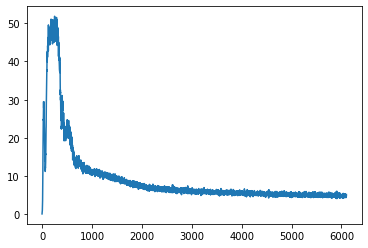

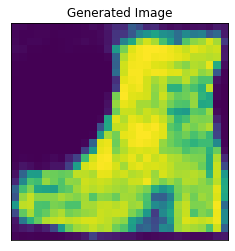

Iteration [6101/10000]......0.119(s) gen: -12.17402 - disc_fake: 12.46605 - disc_real: 16.65793 - disc_real: 4.19188
Iteration [6102/10000]......0.116(s) gen: -12.49327 - disc_fake: 12.20420 - disc_real: 17.44723 - disc_real: 5.24304
Iteration [6103/10000]......0.117(s) gen: -12.32358 - disc_fake: 12.20308 - disc_real: 17.16481 - disc_real: 4.96173
Iteration [6104/10000]......0.118(s) gen: -11.76012 - disc_fake: 12.25163 - disc_real: 16.84354 - disc_real: 4.59191
Iteration [6105/10000]......0.120(s) gen: -10.86727 - disc_fake: 11.46077 - disc_real: 16.19215 - disc_real: 4.73138
Iteration [6106/10000]......0.119(s) gen: -11.40223 - disc_fake: 10.93202 - disc_real: 15.85825 - disc_real: 4.92623
Iteration [6107/10000]......0.120(s) gen: -11.38066 - disc_fake: 11.59025 - disc_real: 16.57453 - disc_real: 4.98428
Iteration [6108/10000]......0.119(s) gen: -12.14492 - disc_fake: 12.10611 - disc_real: 17.12558 - disc_real: 5.01947
Iteration [6109/10000]......0.119(s) gen: -12.56819 - disc_fake:

Iteration [6172/10000]......0.121(s) gen: -12.87943 - disc_fake: 12.63212 - disc_real: 18.16871 - disc_real: 5.53659
Iteration [6173/10000]......0.120(s) gen: -12.05357 - disc_fake: 12.88358 - disc_real: 17.87088 - disc_real: 4.98730
Iteration [6174/10000]......0.121(s) gen: -12.57067 - disc_fake: 12.46718 - disc_real: 16.91519 - disc_real: 4.44801
Iteration [6175/10000]......0.121(s) gen: -12.18139 - disc_fake: 12.28301 - disc_real: 17.13255 - disc_real: 4.84954
Iteration [6176/10000]......0.121(s) gen: -12.55190 - disc_fake: 12.39372 - disc_real: 17.27233 - disc_real: 4.87861
Iteration [6177/10000]......0.121(s) gen: -11.47166 - disc_fake: 12.30827 - disc_real: 16.70410 - disc_real: 4.39583
Iteration [6178/10000]......0.121(s) gen: -11.41491 - disc_fake: 11.45505 - disc_real: 16.96223 - disc_real: 5.50718
Iteration [6179/10000]......0.121(s) gen: -12.34702 - disc_fake: 12.39999 - disc_real: 17.38653 - disc_real: 4.98654
Iteration [6180/10000]......0.119(s) gen: -12.25497 - disc_fake:

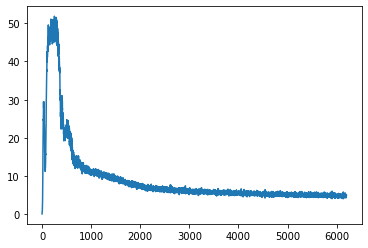

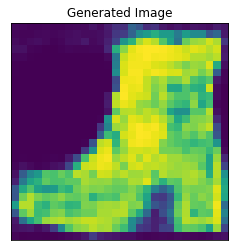

Iteration [6201/10000]......0.119(s) gen: -13.39279 - disc_fake: 13.01021 - disc_real: 17.69078 - disc_real: 4.68057
Iteration [6202/10000]......0.117(s) gen: -13.45946 - disc_fake: 13.52777 - disc_real: 17.98435 - disc_real: 4.45658
Iteration [6203/10000]......0.117(s) gen: -11.59960 - disc_fake: 12.74675 - disc_real: 17.40098 - disc_real: 4.65423
Iteration [6204/10000]......0.116(s) gen: -11.60734 - disc_fake: 12.24060 - disc_real: 16.74925 - disc_real: 4.50865
Iteration [6205/10000]......0.118(s) gen: -12.42435 - disc_fake: 11.68858 - disc_real: 16.83839 - disc_real: 5.14981
Iteration [6206/10000]......0.118(s) gen: -13.07414 - disc_fake: 12.75942 - disc_real: 17.53861 - disc_real: 4.77920
Iteration [6207/10000]......0.119(s) gen: -13.20821 - disc_fake: 12.95161 - disc_real: 17.71470 - disc_real: 4.76309
Iteration [6208/10000]......0.119(s) gen: -12.86665 - disc_fake: 12.99681 - disc_real: 17.90459 - disc_real: 4.90778
Iteration [6209/10000]......0.118(s) gen: -13.17601 - disc_fake:

Iteration [6272/10000]......0.121(s) gen: -12.38191 - disc_fake: 12.95264 - disc_real: 17.64568 - disc_real: 4.69304
Iteration [6273/10000]......0.120(s) gen: -13.06903 - disc_fake: 12.86197 - disc_real: 18.12830 - disc_real: 5.26633
Iteration [6274/10000]......0.120(s) gen: -13.59108 - disc_fake: 13.35472 - disc_real: 18.13974 - disc_real: 4.78502
Iteration [6275/10000]......0.121(s) gen: -13.24300 - disc_fake: 12.81758 - disc_real: 17.60768 - disc_real: 4.79010
Iteration [6276/10000]......0.119(s) gen: -11.77336 - disc_fake: 12.28400 - disc_real: 16.94087 - disc_real: 4.65687
Iteration [6277/10000]......0.120(s) gen: -13.63143 - disc_fake: 12.75908 - disc_real: 17.14441 - disc_real: 4.38534
Iteration [6278/10000]......0.119(s) gen: -12.95290 - disc_fake: 13.32996 - disc_real: 17.75732 - disc_real: 4.42735
Iteration [6279/10000]......0.121(s) gen: -12.16194 - disc_fake: 13.11699 - disc_real: 17.34453 - disc_real: 4.22755
Iteration [6280/10000]......0.121(s) gen: -12.62934 - disc_fake:

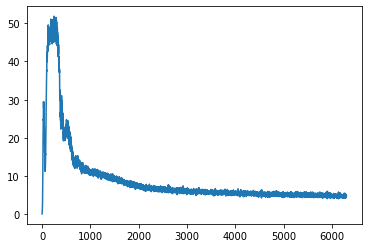

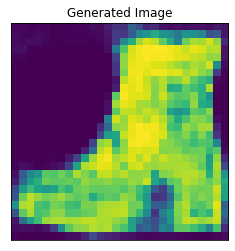

Iteration [6301/10000]......0.115(s) gen: -12.86054 - disc_fake: 12.85863 - disc_real: 17.53376 - disc_real: 4.67513
Iteration [6302/10000]......0.115(s) gen: -12.94234 - disc_fake: 12.92612 - disc_real: 17.98328 - disc_real: 5.05716
Iteration [6303/10000]......0.115(s) gen: -13.06967 - disc_fake: 13.01848 - disc_real: 17.97845 - disc_real: 4.95997
Iteration [6304/10000]......0.116(s) gen: -12.03271 - disc_fake: 12.51036 - disc_real: 17.35090 - disc_real: 4.84054
Iteration [6305/10000]......0.117(s) gen: -13.28302 - disc_fake: 11.89362 - disc_real: 17.13775 - disc_real: 5.24413
Iteration [6306/10000]......0.116(s) gen: -12.21034 - disc_fake: 12.98042 - disc_real: 18.11063 - disc_real: 5.13021
Iteration [6307/10000]......0.118(s) gen: -14.00311 - disc_fake: 12.90950 - disc_real: 17.54871 - disc_real: 4.63921
Iteration [6308/10000]......0.115(s) gen: -13.19480 - disc_fake: 13.68467 - disc_real: 18.66387 - disc_real: 4.97919
Iteration [6309/10000]......0.116(s) gen: -12.92925 - disc_fake:

Iteration [6371/10000]......0.118(s) gen: -12.79218 - disc_fake: 12.50050 - disc_real: 17.86458 - disc_real: 5.36408
Iteration [6372/10000]......0.120(s) gen: -12.62135 - disc_fake: 12.87574 - disc_real: 17.66886 - disc_real: 4.79313
Iteration [6373/10000]......0.120(s) gen: -12.12534 - disc_fake: 12.70682 - disc_real: 18.03782 - disc_real: 5.33100
Iteration [6374/10000]......0.119(s) gen: -12.74448 - disc_fake: 12.89931 - disc_real: 18.24449 - disc_real: 5.34518
Iteration [6375/10000]......0.118(s) gen: -12.93844 - disc_fake: 13.12396 - disc_real: 17.76456 - disc_real: 4.64061
Iteration [6376/10000]......0.120(s) gen: -13.21452 - disc_fake: 13.27626 - disc_real: 18.01009 - disc_real: 4.73383
Iteration [6377/10000]......0.120(s) gen: -13.63403 - disc_fake: 13.45382 - disc_real: 17.97505 - disc_real: 4.52124
Iteration [6378/10000]......0.121(s) gen: -13.60069 - disc_fake: 14.50969 - disc_real: 18.94601 - disc_real: 4.43631
Iteration [6379/10000]......0.121(s) gen: -12.04416 - disc_fake:

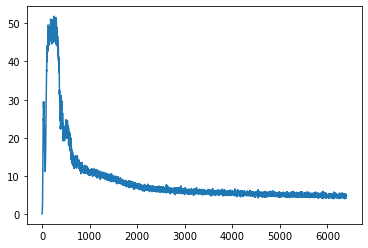

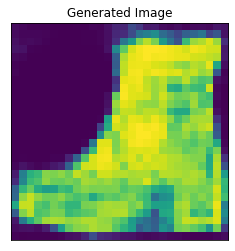

Iteration [6401/10000]......0.118(s) gen: -13.66816 - disc_fake: 12.61658 - disc_real: 17.61872 - disc_real: 5.00214
Iteration [6402/10000]......0.114(s) gen: -12.55800 - disc_fake: 12.91966 - disc_real: 17.92334 - disc_real: 5.00368
Iteration [6403/10000]......0.115(s) gen: -13.15740 - disc_fake: 13.21521 - disc_real: 17.87056 - disc_real: 4.65535
Iteration [6404/10000]......0.114(s) gen: -12.07052 - disc_fake: 12.90633 - disc_real: 17.57051 - disc_real: 4.66418
Iteration [6405/10000]......0.114(s) gen: -12.85081 - disc_fake: 12.66197 - disc_real: 17.34679 - disc_real: 4.68482
Iteration [6406/10000]......0.116(s) gen: -13.78838 - disc_fake: 12.67869 - disc_real: 18.06558 - disc_real: 5.38689
Iteration [6407/10000]......0.117(s) gen: -12.70056 - disc_fake: 13.03082 - disc_real: 17.59138 - disc_real: 4.56057
Iteration [6408/10000]......0.117(s) gen: -13.58848 - disc_fake: 12.61629 - disc_real: 17.84235 - disc_real: 5.22607
Iteration [6409/10000]......0.118(s) gen: -12.12343 - disc_fake:

Iteration [6471/10000]......0.119(s) gen: -13.94661 - disc_fake: 13.42531 - disc_real: 18.16844 - disc_real: 4.74312
Iteration [6472/10000]......0.120(s) gen: -13.37296 - disc_fake: 13.86070 - disc_real: 18.61405 - disc_real: 4.75335
Iteration [6473/10000]......0.119(s) gen: -12.88703 - disc_fake: 12.75225 - disc_real: 17.81402 - disc_real: 5.06177
Iteration [6474/10000]......0.118(s) gen: -12.88670 - disc_fake: 12.50004 - disc_real: 17.30549 - disc_real: 4.80544
Iteration [6475/10000]......0.118(s) gen: -12.40244 - disc_fake: 13.41312 - disc_real: 17.81232 - disc_real: 4.39920
Iteration [6476/10000]......0.119(s) gen: -14.02128 - disc_fake: 13.51776 - disc_real: 18.18581 - disc_real: 4.66805
Iteration [6477/10000]......0.119(s) gen: -13.24955 - disc_fake: 13.37787 - disc_real: 18.56956 - disc_real: 5.19169
Iteration [6478/10000]......0.120(s) gen: -13.74873 - disc_fake: 13.96430 - disc_real: 18.74782 - disc_real: 4.78352
Iteration [6479/10000]......0.121(s) gen: -13.43784 - disc_fake:

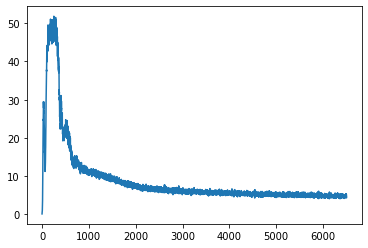

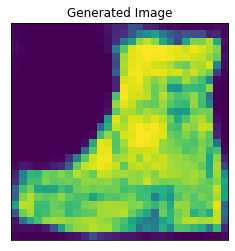

Iteration [6501/10000]......0.121(s) gen: -12.60023 - disc_fake: 12.65499 - disc_real: 17.60781 - disc_real: 4.95282
Iteration [6502/10000]......0.120(s) gen: -12.62701 - disc_fake: 12.77590 - disc_real: 17.54419 - disc_real: 4.76829
Iteration [6503/10000]......0.119(s) gen: -13.61490 - disc_fake: 12.79419 - disc_real: 17.24388 - disc_real: 4.44969
Iteration [6504/10000]......0.119(s) gen: -11.57122 - disc_fake: 12.58987 - disc_real: 18.05848 - disc_real: 5.46861
Iteration [6505/10000]......0.118(s) gen: -13.19209 - disc_fake: 12.15979 - disc_real: 16.57485 - disc_real: 4.41506
Iteration [6506/10000]......0.118(s) gen: -13.04179 - disc_fake: 13.41283 - disc_real: 18.41068 - disc_real: 4.99785
Iteration [6507/10000]......0.120(s) gen: -13.28143 - disc_fake: 13.25444 - disc_real: 17.94106 - disc_real: 4.68662
Iteration [6508/10000]......0.119(s) gen: -12.46310 - disc_fake: 12.86403 - disc_real: 17.70372 - disc_real: 4.83969
Iteration [6509/10000]......0.118(s) gen: -13.64275 - disc_fake:

Iteration [6571/10000]......0.119(s) gen: -13.49587 - disc_fake: 13.80237 - disc_real: 18.38274 - disc_real: 4.58037
Iteration [6572/10000]......0.120(s) gen: -13.71133 - disc_fake: 13.58257 - disc_real: 18.56418 - disc_real: 4.98160
Iteration [6573/10000]......0.118(s) gen: -13.33211 - disc_fake: 13.43649 - disc_real: 17.99486 - disc_real: 4.55838
Iteration [6574/10000]......0.119(s) gen: -13.01772 - disc_fake: 13.43771 - disc_real: 17.93774 - disc_real: 4.50003
Iteration [6575/10000]......0.118(s) gen: -13.65120 - disc_fake: 13.28070 - disc_real: 17.76356 - disc_real: 4.48286
Iteration [6576/10000]......0.119(s) gen: -13.98248 - disc_fake: 14.14933 - disc_real: 18.88488 - disc_real: 4.73555
Iteration [6577/10000]......0.119(s) gen: -13.94498 - disc_fake: 14.38587 - disc_real: 18.97465 - disc_real: 4.58878
Iteration [6578/10000]......0.120(s) gen: -13.96565 - disc_fake: 14.00039 - disc_real: 19.05747 - disc_real: 5.05708
Iteration [6579/10000]......0.120(s) gen: -13.56315 - disc_fake:

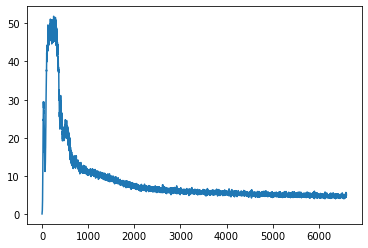

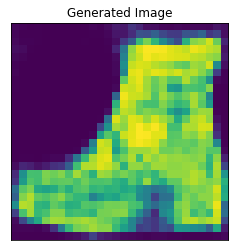

Iteration [6601/10000]......0.118(s) gen: -13.82127 - disc_fake: 13.06427 - disc_real: 17.46069 - disc_real: 4.39643
Iteration [6602/10000]......0.116(s) gen: -13.23683 - disc_fake: 13.44046 - disc_real: 18.02210 - disc_real: 4.58164
Iteration [6603/10000]......0.116(s) gen: -13.94524 - disc_fake: 13.42874 - disc_real: 17.89368 - disc_real: 4.46494
Iteration [6604/10000]......0.117(s) gen: -13.58858 - disc_fake: 13.90362 - disc_real: 18.94181 - disc_real: 5.03819
Iteration [6605/10000]......0.116(s) gen: -12.71369 - disc_fake: 13.74712 - disc_real: 18.44679 - disc_real: 4.69967
Iteration [6606/10000]......0.116(s) gen: -13.59874 - disc_fake: 13.32321 - disc_real: 18.55165 - disc_real: 5.22844
Iteration [6607/10000]......0.118(s) gen: -12.74800 - disc_fake: 13.04065 - disc_real: 17.85816 - disc_real: 4.81751
Iteration [6608/10000]......0.119(s) gen: -12.83027 - disc_fake: 13.03607 - disc_real: 17.96587 - disc_real: 4.92980
Iteration [6609/10000]......0.119(s) gen: -13.10583 - disc_fake:

Iteration [6672/10000]......0.119(s) gen: -14.95809 - disc_fake: 14.17798 - disc_real: 19.11817 - disc_real: 4.94019
Iteration [6673/10000]......0.119(s) gen: -13.70769 - disc_fake: 14.13046 - disc_real: 19.15488 - disc_real: 5.02442
Iteration [6674/10000]......0.121(s) gen: -12.49701 - disc_fake: 13.41441 - disc_real: 17.97403 - disc_real: 4.55962
Iteration [6675/10000]......0.120(s) gen: -13.71938 - disc_fake: 12.78158 - disc_real: 17.52967 - disc_real: 4.74809
Iteration [6676/10000]......0.119(s) gen: -13.50597 - disc_fake: 13.70107 - disc_real: 18.04977 - disc_real: 4.34869
Iteration [6677/10000]......0.120(s) gen: -14.22186 - disc_fake: 14.08801 - disc_real: 18.43376 - disc_real: 4.34575
Iteration [6678/10000]......0.119(s) gen: -14.08788 - disc_fake: 14.13732 - disc_real: 18.58283 - disc_real: 4.44550
Iteration [6679/10000]......0.120(s) gen: -14.22099 - disc_fake: 14.26216 - disc_real: 18.86099 - disc_real: 4.59882
Iteration [6680/10000]......0.119(s) gen: -14.25023 - disc_fake:

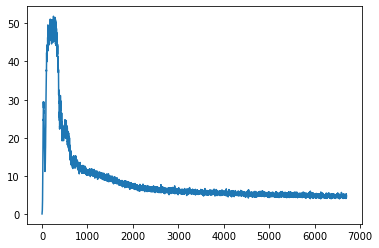

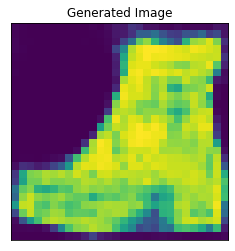

Iteration [6701/10000]......0.115(s) gen: -13.20696 - disc_fake: 13.32762 - disc_real: 18.13573 - disc_real: 4.80810
Iteration [6702/10000]......0.116(s) gen: -13.76487 - disc_fake: 13.14436 - disc_real: 18.02442 - disc_real: 4.88005
Iteration [6703/10000]......0.116(s) gen: -13.90428 - disc_fake: 13.72350 - disc_real: 18.55570 - disc_real: 4.83220
Iteration [6704/10000]......0.116(s) gen: -14.08729 - disc_fake: 13.97159 - disc_real: 19.00786 - disc_real: 5.03627
Iteration [6705/10000]......0.115(s) gen: -13.97065 - disc_fake: 14.18316 - disc_real: 18.45927 - disc_real: 4.27611
Iteration [6706/10000]......0.115(s) gen: -13.85414 - disc_fake: 13.88190 - disc_real: 18.97626 - disc_real: 5.09436
Iteration [6707/10000]......0.117(s) gen: -13.31080 - disc_fake: 13.48151 - disc_real: 18.33942 - disc_real: 4.85791
Iteration [6708/10000]......0.118(s) gen: -13.48071 - disc_fake: 13.78164 - disc_real: 18.16204 - disc_real: 4.38040
Iteration [6709/10000]......0.117(s) gen: -13.31837 - disc_fake:

Iteration [6771/10000]......0.118(s) gen: -14.69103 - disc_fake: 13.89585 - disc_real: 18.38895 - disc_real: 4.49309
Iteration [6772/10000]......0.119(s) gen: -14.87728 - disc_fake: 14.54609 - disc_real: 18.52230 - disc_real: 3.97621
Iteration [6773/10000]......0.119(s) gen: -13.86271 - disc_fake: 14.74876 - disc_real: 19.23818 - disc_real: 4.48942
Iteration [6774/10000]......0.119(s) gen: -14.11784 - disc_fake: 14.55666 - disc_real: 19.38585 - disc_real: 4.82919
Iteration [6775/10000]......0.118(s) gen: -13.62069 - disc_fake: 13.71262 - disc_real: 18.80189 - disc_real: 5.08927
Iteration [6776/10000]......0.118(s) gen: -14.19949 - disc_fake: 13.79272 - disc_real: 18.33689 - disc_real: 4.54416
Iteration [6777/10000]......0.120(s) gen: -14.13870 - disc_fake: 14.22236 - disc_real: 19.06855 - disc_real: 4.84618
Iteration [6778/10000]......0.120(s) gen: -14.46975 - disc_fake: 14.27556 - disc_real: 18.62748 - disc_real: 4.35193
Iteration [6779/10000]......0.121(s) gen: -13.43558 - disc_fake:

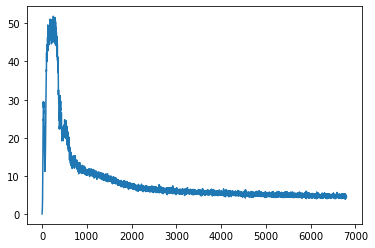

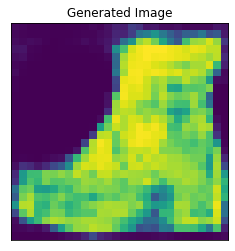

Iteration [6801/10000]......0.116(s) gen: -14.31388 - disc_fake: 14.65490 - disc_real: 19.54219 - disc_real: 4.88729
Iteration [6802/10000]......0.115(s) gen: -14.21619 - disc_fake: 14.57150 - disc_real: 18.78924 - disc_real: 4.21774
Iteration [6803/10000]......0.117(s) gen: -14.25998 - disc_fake: 14.12500 - disc_real: 19.08067 - disc_real: 4.95567
Iteration [6804/10000]......0.115(s) gen: -13.76721 - disc_fake: 14.18266 - disc_real: 19.41666 - disc_real: 5.23400
Iteration [6805/10000]......0.117(s) gen: -14.79002 - disc_fake: 14.27732 - disc_real: 18.52040 - disc_real: 4.24308
Iteration [6806/10000]......0.116(s) gen: -14.85282 - disc_fake: 14.60641 - disc_real: 19.17563 - disc_real: 4.56922
Iteration [6807/10000]......0.116(s) gen: -14.10431 - disc_fake: 14.90100 - disc_real: 19.30591 - disc_real: 4.40491
Iteration [6808/10000]......0.115(s) gen: -14.89511 - disc_fake: 14.66632 - disc_real: 19.58265 - disc_real: 4.91632
Iteration [6809/10000]......0.116(s) gen: -13.52620 - disc_fake:

Iteration [6872/10000]......0.120(s) gen: -14.50815 - disc_fake: 14.02091 - disc_real: 18.37533 - disc_real: 4.35441
Iteration [6873/10000]......0.121(s) gen: -14.71817 - disc_fake: 14.67866 - disc_real: 19.22758 - disc_real: 4.54892
Iteration [6874/10000]......0.122(s) gen: -14.97907 - disc_fake: 14.38870 - disc_real: 19.13358 - disc_real: 4.74488
Iteration [6875/10000]......0.124(s) gen: -14.46664 - disc_fake: 15.48291 - disc_real: 20.04256 - disc_real: 4.55965
Iteration [6876/10000]......0.123(s) gen: -14.40298 - disc_fake: 14.48201 - disc_real: 18.85429 - disc_real: 4.37228
Iteration [6877/10000]......0.122(s) gen: -14.23294 - disc_fake: 14.75207 - disc_real: 19.83696 - disc_real: 5.08489
Iteration [6878/10000]......0.123(s) gen: -15.13930 - disc_fake: 14.91075 - disc_real: 20.04028 - disc_real: 5.12953
Iteration [6879/10000]......0.122(s) gen: -12.93571 - disc_fake: 14.37593 - disc_real: 19.10823 - disc_real: 4.73229
Iteration [6880/10000]......0.134(s) gen: -15.43867 - disc_fake:

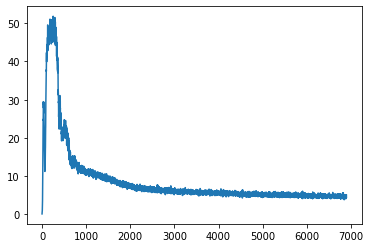

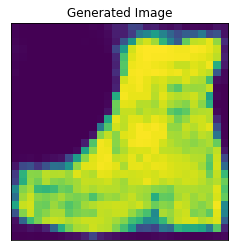

Iteration [6901/10000]......0.115(s) gen: -13.79150 - disc_fake: 14.31577 - disc_real: 19.21183 - disc_real: 4.89607
Iteration [6902/10000]......0.115(s) gen: -14.64283 - disc_fake: 14.48146 - disc_real: 18.99539 - disc_real: 4.51393
Iteration [6903/10000]......0.115(s) gen: -14.97921 - disc_fake: 15.13999 - disc_real: 19.79810 - disc_real: 4.65811
Iteration [6904/10000]......0.114(s) gen: -14.64407 - disc_fake: 14.85832 - disc_real: 19.41834 - disc_real: 4.56003
Iteration [6905/10000]......0.114(s) gen: -14.97638 - disc_fake: 15.12651 - disc_real: 20.17222 - disc_real: 5.04571
Iteration [6906/10000]......0.115(s) gen: -15.41087 - disc_fake: 14.91465 - disc_real: 19.87733 - disc_real: 4.96268
Iteration [6907/10000]......0.116(s) gen: -15.10661 - disc_fake: 14.85086 - disc_real: 20.00340 - disc_real: 5.15254
Iteration [6908/10000]......0.116(s) gen: -14.36444 - disc_fake: 15.19054 - disc_real: 19.62267 - disc_real: 4.43213
Iteration [6909/10000]......0.118(s) gen: -12.60504 - disc_fake:

Iteration [6971/10000]......0.120(s) gen: -16.11398 - disc_fake: 15.72263 - disc_real: 20.01429 - disc_real: 4.29166
Iteration [6972/10000]......0.119(s) gen: -12.59538 - disc_fake: 14.69494 - disc_real: 19.05592 - disc_real: 4.36098
Iteration [6973/10000]......0.122(s) gen: -14.72906 - disc_fake: 13.79285 - disc_real: 18.94193 - disc_real: 5.14908
Iteration [6974/10000]......0.120(s) gen: -14.05750 - disc_fake: 14.86163 - disc_real: 19.47936 - disc_real: 4.61773
Iteration [6975/10000]......0.122(s) gen: -15.29392 - disc_fake: 15.27282 - disc_real: 19.99198 - disc_real: 4.71916
Iteration [6976/10000]......0.121(s) gen: -14.51224 - disc_fake: 14.92418 - disc_real: 20.01521 - disc_real: 5.09103
Iteration [6977/10000]......0.122(s) gen: -14.22917 - disc_fake: 14.43148 - disc_real: 19.30894 - disc_real: 4.87746
Iteration [6978/10000]......0.122(s) gen: -14.56437 - disc_fake: 14.61712 - disc_real: 19.31250 - disc_real: 4.69537
Iteration [6979/10000]......0.119(s) gen: -14.24244 - disc_fake:

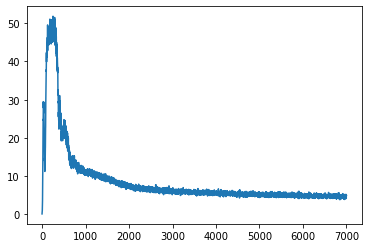

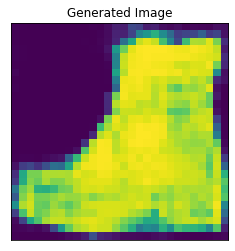

Iteration [7001/10000]......0.120(s) gen: -14.24429 - disc_fake: 14.40874 - disc_real: 19.24483 - disc_real: 4.83609
Iteration [7002/10000]......0.115(s) gen: -14.39935 - disc_fake: 14.59550 - disc_real: 19.59425 - disc_real: 4.99875
Iteration [7003/10000]......0.116(s) gen: -14.91525 - disc_fake: 15.36142 - disc_real: 19.83105 - disc_real: 4.46963
Iteration [7004/10000]......0.115(s) gen: -15.77727 - disc_fake: 14.94189 - disc_real: 19.87546 - disc_real: 4.93357
Iteration [7005/10000]......0.115(s) gen: -14.27509 - disc_fake: 14.96420 - disc_real: 19.64982 - disc_real: 4.68562
Iteration [7006/10000]......0.116(s) gen: -14.67594 - disc_fake: 15.05443 - disc_real: 19.73002 - disc_real: 4.67560
Iteration [7007/10000]......0.115(s) gen: -13.72112 - disc_fake: 14.65437 - disc_real: 19.18107 - disc_real: 4.52670
Iteration [7008/10000]......0.114(s) gen: -13.96089 - disc_fake: 14.09917 - disc_real: 19.01999 - disc_real: 4.92083
Iteration [7009/10000]......0.115(s) gen: -13.68331 - disc_fake:

Iteration [7071/10000]......0.123(s) gen: -13.76442 - disc_fake: 14.55654 - disc_real: 19.26001 - disc_real: 4.70347
Iteration [7072/10000]......0.121(s) gen: -14.01274 - disc_fake: 14.13064 - disc_real: 18.43167 - disc_real: 4.30103
Iteration [7073/10000]......0.120(s) gen: -14.34454 - disc_fake: 13.78653 - disc_real: 18.63500 - disc_real: 4.84846
Iteration [7074/10000]......0.118(s) gen: -13.80523 - disc_fake: 14.09627 - disc_real: 18.71855 - disc_real: 4.62228
Iteration [7075/10000]......0.119(s) gen: -15.17572 - disc_fake: 14.30007 - disc_real: 18.59686 - disc_real: 4.29679
Iteration [7076/10000]......0.119(s) gen: -13.80481 - disc_fake: 14.53951 - disc_real: 19.17041 - disc_real: 4.63089
Iteration [7077/10000]......0.119(s) gen: -15.17105 - disc_fake: 14.20377 - disc_real: 18.74804 - disc_real: 4.54428
Iteration [7078/10000]......0.119(s) gen: -14.77846 - disc_fake: 15.18210 - disc_real: 19.71136 - disc_real: 4.52926
Iteration [7079/10000]......0.119(s) gen: -15.15135 - disc_fake:

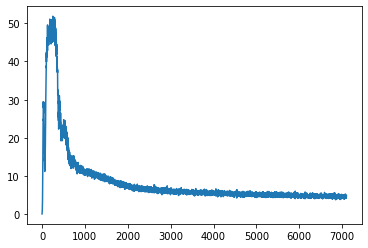

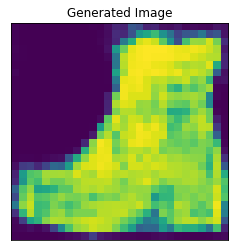

Iteration [7101/10000]......0.121(s) gen: -15.36928 - disc_fake: 14.09220 - disc_real: 18.53395 - disc_real: 4.44175
Iteration [7102/10000]......0.119(s) gen: -14.95951 - disc_fake: 15.43503 - disc_real: 20.05225 - disc_real: 4.61721
Iteration [7103/10000]......0.118(s) gen: -15.35297 - disc_fake: 14.98964 - disc_real: 19.63620 - disc_real: 4.64656
Iteration [7104/10000]......0.114(s) gen: -14.38960 - disc_fake: 14.76757 - disc_real: 19.33458 - disc_real: 4.56700
Iteration [7105/10000]......0.119(s) gen: -15.02302 - disc_fake: 14.74171 - disc_real: 19.34828 - disc_real: 4.60657
Iteration [7106/10000]......0.118(s) gen: -14.72055 - disc_fake: 14.69438 - disc_real: 19.54361 - disc_real: 4.84923
Iteration [7107/10000]......0.118(s) gen: -14.50427 - disc_fake: 14.37024 - disc_real: 19.54479 - disc_real: 5.17455
Iteration [7108/10000]......0.120(s) gen: -15.22224 - disc_fake: 15.06197 - disc_real: 19.59774 - disc_real: 4.53577
Iteration [7109/10000]......0.122(s) gen: -15.77681 - disc_fake:

Iteration [7172/10000]......0.122(s) gen: -14.16034 - disc_fake: 14.12865 - disc_real: 18.90893 - disc_real: 4.78028
Iteration [7173/10000]......0.122(s) gen: -14.34049 - disc_fake: 14.39466 - disc_real: 19.01424 - disc_real: 4.61958
Iteration [7174/10000]......0.122(s) gen: -14.65251 - disc_fake: 14.85661 - disc_real: 19.50391 - disc_real: 4.64730
Iteration [7175/10000]......0.123(s) gen: -14.48704 - disc_fake: 14.84258 - disc_real: 19.79424 - disc_real: 4.95166
Iteration [7176/10000]......0.122(s) gen: -14.33143 - disc_fake: 14.48558 - disc_real: 19.14688 - disc_real: 4.66130
Iteration [7177/10000]......0.120(s) gen: -14.87682 - disc_fake: 14.87510 - disc_real: 19.99104 - disc_real: 5.11594
Iteration [7178/10000]......0.120(s) gen: -15.45077 - disc_fake: 14.98819 - disc_real: 19.59844 - disc_real: 4.61025
Iteration [7179/10000]......0.120(s) gen: -15.18062 - disc_fake: 15.21158 - disc_real: 20.11177 - disc_real: 4.90018
Iteration [7180/10000]......0.121(s) gen: -14.43447 - disc_fake:

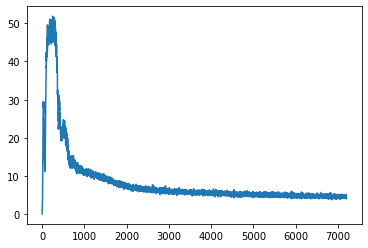

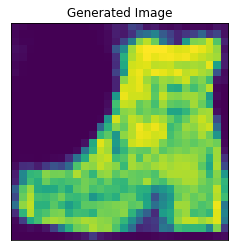

Iteration [7201/10000]......0.133(s) gen: -14.75576 - disc_fake: 14.75989 - disc_real: 19.26814 - disc_real: 4.50825
Iteration [7202/10000]......0.117(s) gen: -14.56931 - disc_fake: 14.46658 - disc_real: 19.08499 - disc_real: 4.61841
Iteration [7203/10000]......0.118(s) gen: -15.04153 - disc_fake: 14.26330 - disc_real: 18.54050 - disc_real: 4.27719
Iteration [7204/10000]......0.120(s) gen: -14.87175 - disc_fake: 15.00231 - disc_real: 19.87177 - disc_real: 4.86946
Iteration [7205/10000]......0.120(s) gen: -14.68405 - disc_fake: 14.98781 - disc_real: 19.70896 - disc_real: 4.72115
Iteration [7206/10000]......0.119(s) gen: -13.71966 - disc_fake: 14.53769 - disc_real: 19.41816 - disc_real: 4.88046
Iteration [7207/10000]......0.121(s) gen: -14.45794 - disc_fake: 13.87144 - disc_real: 18.69279 - disc_real: 4.82136
Iteration [7208/10000]......0.120(s) gen: -14.80575 - disc_fake: 14.49944 - disc_real: 19.42624 - disc_real: 4.92680
Iteration [7209/10000]......0.119(s) gen: -14.46548 - disc_fake:

Iteration [7272/10000]......0.118(s) gen: -15.42766 - disc_fake: 14.49953 - disc_real: 19.71130 - disc_real: 5.21177
Iteration [7273/10000]......0.120(s) gen: -15.64907 - disc_fake: 15.39940 - disc_real: 19.68969 - disc_real: 4.29030
Iteration [7274/10000]......0.125(s) gen: -16.76279 - disc_fake: 16.22316 - disc_real: 20.71713 - disc_real: 4.49397
Iteration [7275/10000]......0.122(s) gen: -16.61971 - disc_fake: 16.63064 - disc_real: 21.52714 - disc_real: 4.89649
Iteration [7276/10000]......0.118(s) gen: -16.52555 - disc_fake: 15.85128 - disc_real: 20.76254 - disc_real: 4.91126
Iteration [7277/10000]......0.121(s) gen: -15.26748 - disc_fake: 16.40401 - disc_real: 20.36514 - disc_real: 3.96112
Iteration [7278/10000]......0.117(s) gen: -14.57998 - disc_fake: 14.92613 - disc_real: 19.51926 - disc_real: 4.59312
Iteration [7279/10000]......0.118(s) gen: -13.49700 - disc_fake: 14.77585 - disc_real: 19.00340 - disc_real: 4.22755
Iteration [7280/10000]......0.121(s) gen: -14.67573 - disc_fake:

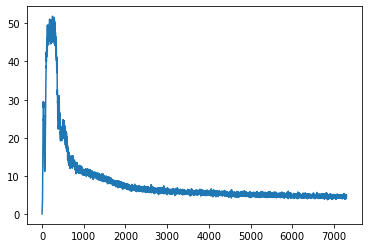

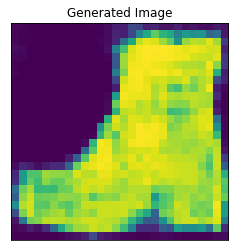

Iteration [7301/10000]......0.118(s) gen: -15.06744 - disc_fake: 14.49806 - disc_real: 19.32184 - disc_real: 4.82378
Iteration [7302/10000]......0.120(s) gen: -16.06044 - disc_fake: 15.72656 - disc_real: 20.52289 - disc_real: 4.79634
Iteration [7303/10000]......0.118(s) gen: -15.91749 - disc_fake: 15.55447 - disc_real: 20.26183 - disc_real: 4.70736
Iteration [7304/10000]......0.117(s) gen: -14.45622 - disc_fake: 15.02391 - disc_real: 19.77527 - disc_real: 4.75136
Iteration [7305/10000]......0.115(s) gen: -14.13897 - disc_fake: 14.40386 - disc_real: 19.35626 - disc_real: 4.95240
Iteration [7306/10000]......0.116(s) gen: -16.22199 - disc_fake: 15.69335 - disc_real: 19.73967 - disc_real: 4.04632
Iteration [7307/10000]......0.116(s) gen: -15.25454 - disc_fake: 15.53619 - disc_real: 19.95676 - disc_real: 4.42057
Iteration [7308/10000]......0.115(s) gen: -15.18312 - disc_fake: 14.99627 - disc_real: 19.60826 - disc_real: 4.61198
Iteration [7309/10000]......0.116(s) gen: -13.75180 - disc_fake:

Iteration [7372/10000]......0.120(s) gen: -14.94945 - disc_fake: 15.24782 - disc_real: 19.90264 - disc_real: 4.65481
Iteration [7373/10000]......0.121(s) gen: -15.46269 - disc_fake: 15.84552 - disc_real: 20.08835 - disc_real: 4.24283
Iteration [7374/10000]......0.120(s) gen: -15.17706 - disc_fake: 15.48854 - disc_real: 20.16763 - disc_real: 4.67910
Iteration [7375/10000]......0.121(s) gen: -15.45012 - disc_fake: 15.92639 - disc_real: 20.57497 - disc_real: 4.64858
Iteration [7376/10000]......0.120(s) gen: -15.06658 - disc_fake: 15.50202 - disc_real: 19.80923 - disc_real: 4.30721
Iteration [7377/10000]......0.119(s) gen: -15.10557 - disc_fake: 15.47327 - disc_real: 20.60601 - disc_real: 5.13274
Iteration [7378/10000]......0.119(s) gen: -15.18891 - disc_fake: 15.06531 - disc_real: 20.03951 - disc_real: 4.97420
Iteration [7379/10000]......0.120(s) gen: -16.05527 - disc_fake: 15.95307 - disc_real: 20.58137 - disc_real: 4.62830
Iteration [7380/10000]......0.119(s) gen: -14.91252 - disc_fake:

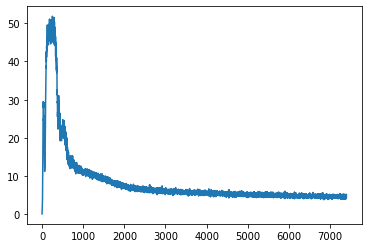

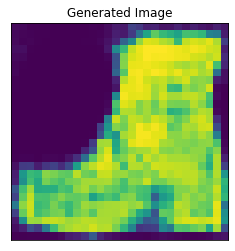

Iteration [7401/10000]......0.117(s) gen: -15.33645 - disc_fake: 14.94930 - disc_real: 20.04169 - disc_real: 5.09239
Iteration [7402/10000]......0.117(s) gen: -13.83984 - disc_fake: 14.56529 - disc_real: 18.89504 - disc_real: 4.32975
Iteration [7403/10000]......0.117(s) gen: -15.03110 - disc_fake: 14.58021 - disc_real: 19.74773 - disc_real: 5.16752
Iteration [7404/10000]......0.119(s) gen: -14.66690 - disc_fake: 15.52635 - disc_real: 19.84767 - disc_real: 4.32133
Iteration [7405/10000]......0.118(s) gen: -15.16584 - disc_fake: 15.07105 - disc_real: 19.35399 - disc_real: 4.28294
Iteration [7406/10000]......0.118(s) gen: -15.58220 - disc_fake: 15.59495 - disc_real: 20.21953 - disc_real: 4.62457
Iteration [7407/10000]......0.117(s) gen: -14.59105 - disc_fake: 15.36893 - disc_real: 19.82500 - disc_real: 4.45608
Iteration [7408/10000]......0.118(s) gen: -15.36945 - disc_fake: 14.89262 - disc_real: 19.91280 - disc_real: 5.02018
Iteration [7409/10000]......0.119(s) gen: -14.63103 - disc_fake:

Iteration [7471/10000]......0.120(s) gen: -15.53510 - disc_fake: 15.64610 - disc_real: 20.26333 - disc_real: 4.61723
Iteration [7472/10000]......0.118(s) gen: -15.72622 - disc_fake: 15.24260 - disc_real: 19.74247 - disc_real: 4.49987
Iteration [7473/10000]......0.121(s) gen: -15.21322 - disc_fake: 15.41237 - disc_real: 19.62274 - disc_real: 4.21037
Iteration [7474/10000]......0.120(s) gen: -14.55782 - disc_fake: 15.26978 - disc_real: 19.75500 - disc_real: 4.48522
Iteration [7475/10000]......0.121(s) gen: -15.52681 - disc_fake: 15.03471 - disc_real: 20.23011 - disc_real: 5.19540
Iteration [7476/10000]......0.122(s) gen: -15.87353 - disc_fake: 15.69981 - disc_real: 19.67394 - disc_real: 3.97412
Iteration [7477/10000]......0.121(s) gen: -15.63302 - disc_fake: 15.49821 - disc_real: 19.83743 - disc_real: 4.33922
Iteration [7478/10000]......0.122(s) gen: -14.99033 - disc_fake: 15.66837 - disc_real: 19.97357 - disc_real: 4.30521
Iteration [7479/10000]......0.120(s) gen: -16.81902 - disc_fake:

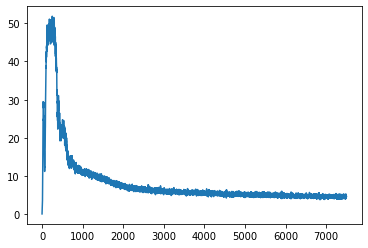

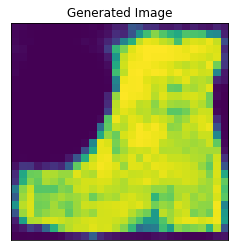

Iteration [7501/10000]......0.121(s) gen: -14.86290 - disc_fake: 14.66909 - disc_real: 19.49955 - disc_real: 4.83045
Iteration [7502/10000]......0.116(s) gen: -13.44653 - disc_fake: 14.47047 - disc_real: 19.06805 - disc_real: 4.59758
Iteration [7503/10000]......0.118(s) gen: -14.58595 - disc_fake: 14.04718 - disc_real: 19.06715 - disc_real: 5.01996
Iteration [7504/10000]......0.117(s) gen: -15.27264 - disc_fake: 15.04423 - disc_real: 20.13794 - disc_real: 5.09372
Iteration [7505/10000]......0.117(s) gen: -15.23237 - disc_fake: 15.42854 - disc_real: 20.06697 - disc_real: 4.63842
Iteration [7506/10000]......0.117(s) gen: -14.73044 - disc_fake: 15.73882 - disc_real: 20.37945 - disc_real: 4.64063
Iteration [7507/10000]......0.118(s) gen: -15.47642 - disc_fake: 15.43424 - disc_real: 20.14896 - disc_real: 4.71473
Iteration [7508/10000]......0.116(s) gen: -15.61372 - disc_fake: 15.52944 - disc_real: 19.94035 - disc_real: 4.41091
Iteration [7509/10000]......0.119(s) gen: -14.79244 - disc_fake:

Iteration [7572/10000]......0.125(s) gen: -16.10908 - disc_fake: 16.17186 - disc_real: 21.22108 - disc_real: 5.04922
Iteration [7573/10000]......0.123(s) gen: -15.64183 - disc_fake: 15.71070 - disc_real: 20.85257 - disc_real: 5.14187
Iteration [7574/10000]......0.123(s) gen: -15.11813 - disc_fake: 15.87096 - disc_real: 20.28906 - disc_real: 4.41810
Iteration [7575/10000]......0.121(s) gen: -14.94073 - disc_fake: 15.68920 - disc_real: 20.53688 - disc_real: 4.84768
Iteration [7576/10000]......0.119(s) gen: -15.18016 - disc_fake: 15.32136 - disc_real: 19.37930 - disc_real: 4.05795
Iteration [7577/10000]......0.120(s) gen: -13.97704 - disc_fake: 14.91912 - disc_real: 19.42495 - disc_real: 4.50583
Iteration [7578/10000]......0.119(s) gen: -16.07396 - disc_fake: 15.35107 - disc_real: 19.88513 - disc_real: 4.53407
Iteration [7579/10000]......0.117(s) gen: -15.69421 - disc_fake: 15.86519 - disc_real: 20.58319 - disc_real: 4.71799
Iteration [7580/10000]......0.118(s) gen: -15.29774 - disc_fake:

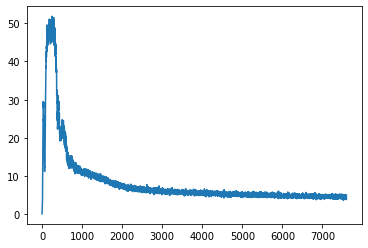

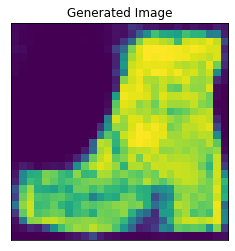

Iteration [7601/10000]......0.120(s) gen: -14.71229 - disc_fake: 15.46121 - disc_real: 20.17944 - disc_real: 4.71823
Iteration [7602/10000]......0.117(s) gen: -13.86163 - disc_fake: 14.14450 - disc_real: 18.76689 - disc_real: 4.62239
Iteration [7603/10000]......0.117(s) gen: -14.94969 - disc_fake: 14.48076 - disc_real: 18.85084 - disc_real: 4.37008
Iteration [7604/10000]......0.117(s) gen: -15.75232 - disc_fake: 15.52727 - disc_real: 19.65109 - disc_real: 4.12382
Iteration [7605/10000]......0.119(s) gen: -16.30201 - disc_fake: 15.86878 - disc_real: 20.34826 - disc_real: 4.47948
Iteration [7606/10000]......0.119(s) gen: -16.39882 - disc_fake: 16.24796 - disc_real: 20.79759 - disc_real: 4.54963
Iteration [7607/10000]......0.120(s) gen: -16.38453 - disc_fake: 16.77147 - disc_real: 21.04746 - disc_real: 4.27599
Iteration [7608/10000]......0.119(s) gen: -15.54056 - disc_fake: 15.81610 - disc_real: 20.58084 - disc_real: 4.76474
Iteration [7609/10000]......0.120(s) gen: -15.39766 - disc_fake:

Iteration [7671/10000]......0.123(s) gen: -15.85930 - disc_fake: 16.33203 - disc_real: 20.38399 - disc_real: 4.05195
Iteration [7672/10000]......0.123(s) gen: -16.54394 - disc_fake: 16.15395 - disc_real: 21.10970 - disc_real: 4.95576
Iteration [7673/10000]......0.122(s) gen: -15.55280 - disc_fake: 15.36224 - disc_real: 19.86594 - disc_real: 4.50370
Iteration [7674/10000]......0.123(s) gen: -16.15162 - disc_fake: 16.64372 - disc_real: 20.92871 - disc_real: 4.28499
Iteration [7675/10000]......0.120(s) gen: -16.02536 - disc_fake: 16.13167 - disc_real: 20.49620 - disc_real: 4.36453
Iteration [7676/10000]......0.121(s) gen: -16.64436 - disc_fake: 16.40627 - disc_real: 21.16154 - disc_real: 4.75528
Iteration [7677/10000]......0.119(s) gen: -15.38487 - disc_fake: 16.35870 - disc_real: 20.96542 - disc_real: 4.60672
Iteration [7678/10000]......0.121(s) gen: -15.93502 - disc_fake: 15.39465 - disc_real: 20.18807 - disc_real: 4.79342
Iteration [7679/10000]......0.119(s) gen: -16.74589 - disc_fake:

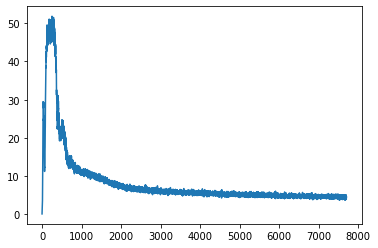

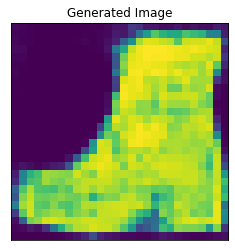

Iteration [7701/10000]......0.117(s) gen: -15.70233 - disc_fake: 16.36121 - disc_real: 21.09722 - disc_real: 4.73602
Iteration [7702/10000]......0.116(s) gen: -16.27980 - disc_fake: 15.83188 - disc_real: 20.35339 - disc_real: 4.52151
Iteration [7703/10000]......0.114(s) gen: -16.83398 - disc_fake: 16.38074 - disc_real: 21.08009 - disc_real: 4.69935
Iteration [7704/10000]......0.115(s) gen: -16.14724 - disc_fake: 16.35866 - disc_real: 20.52609 - disc_real: 4.16743
Iteration [7705/10000]......0.115(s) gen: -17.06042 - disc_fake: 16.82297 - disc_real: 21.61624 - disc_real: 4.79327
Iteration [7706/10000]......0.114(s) gen: -14.98826 - disc_fake: 16.56795 - disc_real: 20.96520 - disc_real: 4.39725
Iteration [7707/10000]......0.114(s) gen: -15.18810 - disc_fake: 15.47985 - disc_real: 20.08087 - disc_real: 4.60102
Iteration [7708/10000]......0.115(s) gen: -16.77836 - disc_fake: 15.52225 - disc_real: 20.05376 - disc_real: 4.53151
Iteration [7709/10000]......0.116(s) gen: -16.64797 - disc_fake:

Iteration [7772/10000]......0.122(s) gen: -16.05598 - disc_fake: 16.60665 - disc_real: 21.43355 - disc_real: 4.82690
Iteration [7773/10000]......0.122(s) gen: -16.38797 - disc_fake: 15.81651 - disc_real: 20.54884 - disc_real: 4.73232
Iteration [7774/10000]......0.121(s) gen: -16.39415 - disc_fake: 16.03336 - disc_real: 20.48055 - disc_real: 4.44718
Iteration [7775/10000]......0.120(s) gen: -16.27145 - disc_fake: 16.15623 - disc_real: 20.61432 - disc_real: 4.45809
Iteration [7776/10000]......0.118(s) gen: -16.88014 - disc_fake: 16.35610 - disc_real: 20.94176 - disc_real: 4.58567
Iteration [7777/10000]......0.118(s) gen: -17.01260 - disc_fake: 16.19627 - disc_real: 20.61379 - disc_real: 4.41752
Iteration [7778/10000]......0.118(s) gen: -15.82626 - disc_fake: 16.44893 - disc_real: 21.24120 - disc_real: 4.79227
Iteration [7779/10000]......0.118(s) gen: -16.71800 - disc_fake: 16.53692 - disc_real: 21.69545 - disc_real: 5.15853
Iteration [7780/10000]......0.118(s) gen: -15.90460 - disc_fake:

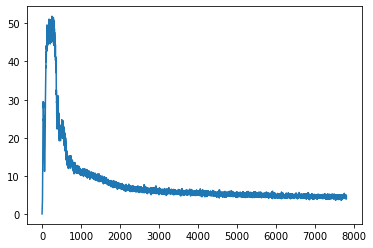

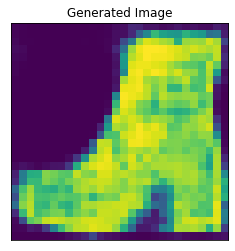

Iteration [7801/10000]......0.115(s) gen: -16.73143 - disc_fake: 15.74133 - disc_real: 20.14549 - disc_real: 4.40416
Iteration [7802/10000]......0.116(s) gen: -16.23232 - disc_fake: 16.71209 - disc_real: 21.19622 - disc_real: 4.48413
Iteration [7803/10000]......0.116(s) gen: -15.97797 - disc_fake: 15.73167 - disc_real: 20.21198 - disc_real: 4.48030
Iteration [7804/10000]......0.116(s) gen: -16.89912 - disc_fake: 16.72323 - disc_real: 20.71293 - disc_real: 3.98971
Iteration [7805/10000]......0.115(s) gen: -16.20199 - disc_fake: 16.39623 - disc_real: 20.85590 - disc_real: 4.45968
Iteration [7806/10000]......0.116(s) gen: -16.28814 - disc_fake: 16.48536 - disc_real: 21.15668 - disc_real: 4.67132
Iteration [7807/10000]......0.115(s) gen: -17.13167 - disc_fake: 16.87263 - disc_real: 21.31325 - disc_real: 4.44062
Iteration [7808/10000]......0.116(s) gen: -16.75565 - disc_fake: 16.67747 - disc_real: 21.40676 - disc_real: 4.72929
Iteration [7809/10000]......0.117(s) gen: -16.42127 - disc_fake:

Iteration [7872/10000]......0.119(s) gen: -17.08746 - disc_fake: 17.55492 - disc_real: 21.86881 - disc_real: 4.31388
Iteration [7873/10000]......0.118(s) gen: -17.42427 - disc_fake: 17.26297 - disc_real: 22.32190 - disc_real: 5.05894
Iteration [7874/10000]......0.120(s) gen: -15.53531 - disc_fake: 16.95287 - disc_real: 21.51653 - disc_real: 4.56366
Iteration [7875/10000]......0.120(s) gen: -15.44444 - disc_fake: 15.82477 - disc_real: 20.44808 - disc_real: 4.62330
Iteration [7876/10000]......0.122(s) gen: -16.25869 - disc_fake: 15.58568 - disc_real: 20.03022 - disc_real: 4.44454
Iteration [7877/10000]......0.120(s) gen: -16.47919 - disc_fake: 16.27856 - disc_real: 20.63024 - disc_real: 4.35168
Iteration [7878/10000]......0.119(s) gen: -16.52153 - disc_fake: 16.96322 - disc_real: 21.46314 - disc_real: 4.49992
Iteration [7879/10000]......0.120(s) gen: -16.80362 - disc_fake: 16.60656 - disc_real: 21.38287 - disc_real: 4.77631
Iteration [7880/10000]......0.121(s) gen: -16.82303 - disc_fake:

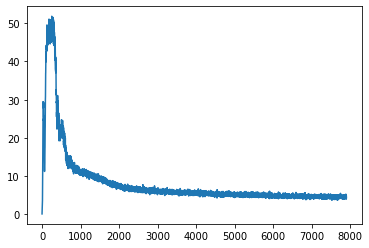

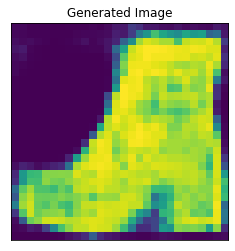

Iteration [7901/10000]......0.123(s) gen: -16.36779 - disc_fake: 16.13618 - disc_real: 20.72487 - disc_real: 4.58869
Iteration [7902/10000]......0.121(s) gen: -16.41058 - disc_fake: 16.84807 - disc_real: 20.80744 - disc_real: 3.95937
Iteration [7903/10000]......0.117(s) gen: -17.32611 - disc_fake: 16.49888 - disc_real: 21.16229 - disc_real: 4.66341
Iteration [7904/10000]......0.117(s) gen: -16.25792 - disc_fake: 16.84843 - disc_real: 20.97920 - disc_real: 4.13077
Iteration [7905/10000]......0.120(s) gen: -15.84211 - disc_fake: 16.23921 - disc_real: 21.07699 - disc_real: 4.83779
Iteration [7906/10000]......0.118(s) gen: -15.58828 - disc_fake: 16.06895 - disc_real: 20.43655 - disc_real: 4.36760
Iteration [7907/10000]......0.118(s) gen: -16.41031 - disc_fake: 16.64759 - disc_real: 20.87955 - disc_real: 4.23196
Iteration [7908/10000]......0.116(s) gen: -17.15819 - disc_fake: 16.69925 - disc_real: 21.45035 - disc_real: 4.75110
Iteration [7909/10000]......0.117(s) gen: -16.56942 - disc_fake:

Iteration [7972/10000]......0.120(s) gen: -16.48673 - disc_fake: 16.51497 - disc_real: 21.40229 - disc_real: 4.88731
Iteration [7973/10000]......0.120(s) gen: -16.73876 - disc_fake: 16.59758 - disc_real: 21.75155 - disc_real: 5.15397
Iteration [7974/10000]......0.120(s) gen: -15.92394 - disc_fake: 16.39350 - disc_real: 21.03681 - disc_real: 4.64331
Iteration [7975/10000]......0.118(s) gen: -16.28912 - disc_fake: 16.49626 - disc_real: 21.45351 - disc_real: 4.95725
Iteration [7976/10000]......0.119(s) gen: -15.64340 - disc_fake: 16.08987 - disc_real: 20.55742 - disc_real: 4.46755
Iteration [7977/10000]......0.118(s) gen: -16.98298 - disc_fake: 16.10682 - disc_real: 20.99689 - disc_real: 4.89007
Iteration [7978/10000]......0.118(s) gen: -17.40412 - disc_fake: 17.21360 - disc_real: 21.90398 - disc_real: 4.69038
Iteration [7979/10000]......0.119(s) gen: -16.78267 - disc_fake: 16.95920 - disc_real: 20.95442 - disc_real: 3.99522
Iteration [7980/10000]......0.120(s) gen: -17.42458 - disc_fake:

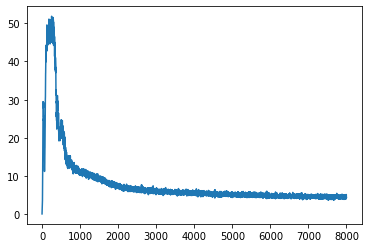

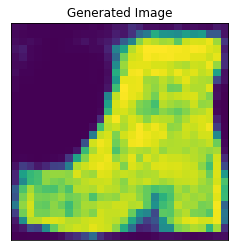

checkpointing at epoch: 8000
Iteration [8001/10000]......0.119(s) gen: -16.50956 - disc_fake: 16.62972 - disc_real: 21.05525 - disc_real: 4.42554
Iteration [8002/10000]......0.118(s) gen: -16.11102 - disc_fake: 16.69882 - disc_real: 20.98021 - disc_real: 4.28138
Iteration [8003/10000]......0.115(s) gen: -16.43354 - disc_fake: 16.42071 - disc_real: 20.81998 - disc_real: 4.39927
Iteration [8004/10000]......0.117(s) gen: -17.25336 - disc_fake: 16.63024 - disc_real: 21.44036 - disc_real: 4.81012
Iteration [8005/10000]......0.117(s) gen: -17.47771 - disc_fake: 17.51651 - disc_real: 22.11417 - disc_real: 4.59766
Iteration [8006/10000]......0.117(s) gen: -17.35642 - disc_fake: 17.16104 - disc_real: 21.71010 - disc_real: 4.54906
Iteration [8007/10000]......0.118(s) gen: -16.93107 - disc_fake: 17.16562 - disc_real: 22.01705 - disc_real: 4.85143
Iteration [8008/10000]......0.118(s) gen: -16.87279 - disc_fake: 16.96923 - disc_real: 21.29835 - disc_real: 4.32912
Iteration [8009/10000]......0.118(s

Iteration [8072/10000]......0.119(s) gen: -16.83982 - disc_fake: 17.10430 - disc_real: 21.71867 - disc_real: 4.61438
Iteration [8073/10000]......0.120(s) gen: -16.52923 - disc_fake: 16.88277 - disc_real: 21.77326 - disc_real: 4.89049
Iteration [8074/10000]......0.120(s) gen: -16.80140 - disc_fake: 16.78328 - disc_real: 20.96124 - disc_real: 4.17797
Iteration [8075/10000]......0.119(s) gen: -17.38382 - disc_fake: 16.83051 - disc_real: 21.33601 - disc_real: 4.50550
Iteration [8076/10000]......0.120(s) gen: -17.01909 - disc_fake: 17.38396 - disc_real: 21.37684 - disc_real: 3.99288
Iteration [8077/10000]......0.120(s) gen: -17.34538 - disc_fake: 17.51378 - disc_real: 22.36010 - disc_real: 4.84632
Iteration [8078/10000]......0.120(s) gen: -18.23130 - disc_fake: 17.04500 - disc_real: 21.80944 - disc_real: 4.76443
Iteration [8079/10000]......0.123(s) gen: -17.98471 - disc_fake: 18.16000 - disc_real: 22.40907 - disc_real: 4.24907
Iteration [8080/10000]......0.123(s) gen: -17.54438 - disc_fake:

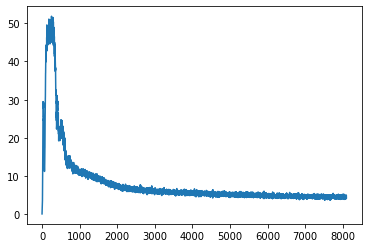

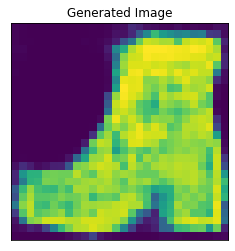

Iteration [8101/10000]......0.114(s) gen: -16.83537 - disc_fake: 17.20923 - disc_real: 21.60278 - disc_real: 4.39355
Iteration [8102/10000]......0.115(s) gen: -17.31777 - disc_fake: 16.86872 - disc_real: 20.98721 - disc_real: 4.11849
Iteration [8103/10000]......0.117(s) gen: -16.81008 - disc_fake: 18.16855 - disc_real: 22.48058 - disc_real: 4.31203
Iteration [8104/10000]......0.117(s) gen: -17.83173 - disc_fake: 17.50307 - disc_real: 22.07770 - disc_real: 4.57463
Iteration [8105/10000]......0.117(s) gen: -17.28021 - disc_fake: 17.47377 - disc_real: 22.30323 - disc_real: 4.82946
Iteration [8106/10000]......0.118(s) gen: -16.44399 - disc_fake: 17.27344 - disc_real: 21.70781 - disc_real: 4.43436
Iteration [8107/10000]......0.119(s) gen: -16.37143 - disc_fake: 16.62363 - disc_real: 21.14430 - disc_real: 4.52067
Iteration [8108/10000]......0.118(s) gen: -15.97749 - disc_fake: 16.62333 - disc_real: 21.42931 - disc_real: 4.80598
Iteration [8109/10000]......0.118(s) gen: -17.46224 - disc_fake:

Iteration [8171/10000]......0.118(s) gen: -16.97766 - disc_fake: 16.99614 - disc_real: 21.28382 - disc_real: 4.28769
Iteration [8172/10000]......0.119(s) gen: -15.83619 - disc_fake: 16.83850 - disc_real: 21.03820 - disc_real: 4.19970
Iteration [8173/10000]......0.120(s) gen: -16.76432 - disc_fake: 16.21737 - disc_real: 21.01909 - disc_real: 4.80172
Iteration [8174/10000]......0.120(s) gen: -15.82823 - disc_fake: 17.18871 - disc_real: 21.67378 - disc_real: 4.48507
Iteration [8175/10000]......0.121(s) gen: -17.12917 - disc_fake: 16.59956 - disc_real: 21.13769 - disc_real: 4.53813
Iteration [8176/10000]......0.122(s) gen: -17.16754 - disc_fake: 16.96064 - disc_real: 21.69741 - disc_real: 4.73676
Iteration [8177/10000]......0.121(s) gen: -17.35703 - disc_fake: 17.48660 - disc_real: 21.74725 - disc_real: 4.26065
Iteration [8178/10000]......0.120(s) gen: -17.61226 - disc_fake: 17.75997 - disc_real: 22.08666 - disc_real: 4.32670
Iteration [8179/10000]......0.120(s) gen: -17.44388 - disc_fake:

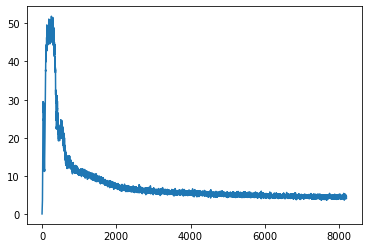

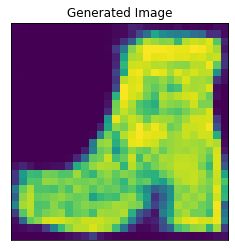

Iteration [8201/10000]......0.121(s) gen: -15.87924 - disc_fake: 16.87041 - disc_real: 21.53653 - disc_real: 4.66612
Iteration [8202/10000]......0.116(s) gen: -17.60825 - disc_fake: 16.93453 - disc_real: 21.24096 - disc_real: 4.30643
Iteration [8203/10000]......0.118(s) gen: -17.76588 - disc_fake: 18.07999 - disc_real: 22.31205 - disc_real: 4.23206
Iteration [8204/10000]......0.118(s) gen: -17.95434 - disc_fake: 17.73187 - disc_real: 22.19261 - disc_real: 4.46074
Iteration [8205/10000]......0.119(s) gen: -16.74620 - disc_fake: 17.36070 - disc_real: 21.84612 - disc_real: 4.48542
Iteration [8206/10000]......0.118(s) gen: -18.04849 - disc_fake: 17.70454 - disc_real: 22.63073 - disc_real: 4.92619
Iteration [8207/10000]......0.119(s) gen: -17.67578 - disc_fake: 18.17084 - disc_real: 22.08164 - disc_real: 3.91080
Iteration [8208/10000]......0.120(s) gen: -16.84848 - disc_fake: 17.10950 - disc_real: 21.34289 - disc_real: 4.23338
Iteration [8209/10000]......0.119(s) gen: -17.08769 - disc_fake:

Iteration [8271/10000]......0.121(s) gen: -16.83471 - disc_fake: 18.05771 - disc_real: 22.64425 - disc_real: 4.58654
Iteration [8272/10000]......0.120(s) gen: -17.59267 - disc_fake: 17.77598 - disc_real: 21.99436 - disc_real: 4.21838
Iteration [8273/10000]......0.123(s) gen: -18.41328 - disc_fake: 17.81750 - disc_real: 22.84723 - disc_real: 5.02973
Iteration [8274/10000]......0.123(s) gen: -17.38460 - disc_fake: 17.51250 - disc_real: 21.95542 - disc_real: 4.44292
Iteration [8275/10000]......0.121(s) gen: -17.20216 - disc_fake: 18.05187 - disc_real: 22.80224 - disc_real: 4.75037
Iteration [8276/10000]......0.121(s) gen: -18.17658 - disc_fake: 17.32608 - disc_real: 22.19353 - disc_real: 4.86745
Iteration [8277/10000]......0.123(s) gen: -18.37343 - disc_fake: 18.35119 - disc_real: 22.70808 - disc_real: 4.35690
Iteration [8278/10000]......0.121(s) gen: -17.95229 - disc_fake: 18.40654 - disc_real: 22.65265 - disc_real: 4.24611
Iteration [8279/10000]......0.121(s) gen: -17.58222 - disc_fake:

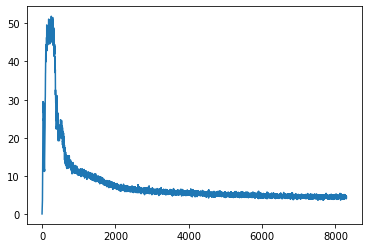

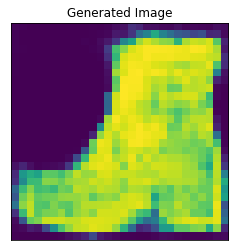

Iteration [8301/10000]......0.120(s) gen: -18.01061 - disc_fake: 18.24575 - disc_real: 22.74009 - disc_real: 4.49435
Iteration [8302/10000]......0.115(s) gen: -17.51340 - disc_fake: 18.18581 - disc_real: 22.40296 - disc_real: 4.21715
Iteration [8303/10000]......0.114(s) gen: -17.15670 - disc_fake: 17.87888 - disc_real: 22.28025 - disc_real: 4.40136
Iteration [8304/10000]......0.116(s) gen: -17.51320 - disc_fake: 17.89737 - disc_real: 21.77670 - disc_real: 3.87933
Iteration [8305/10000]......0.115(s) gen: -17.45865 - disc_fake: 18.19290 - disc_real: 22.40673 - disc_real: 4.21383
Iteration [8306/10000]......0.115(s) gen: -17.59626 - disc_fake: 17.70932 - disc_real: 22.59928 - disc_real: 4.88996
Iteration [8307/10000]......0.115(s) gen: -17.46367 - disc_fake: 17.96030 - disc_real: 22.40473 - disc_real: 4.44443
Iteration [8308/10000]......0.115(s) gen: -18.25805 - disc_fake: 17.85455 - disc_real: 21.98498 - disc_real: 4.13043
Iteration [8309/10000]......0.117(s) gen: -17.50648 - disc_fake:

Iteration [8372/10000]......0.120(s) gen: -18.52993 - disc_fake: 18.08359 - disc_real: 22.60765 - disc_real: 4.52406
Iteration [8373/10000]......0.120(s) gen: -17.68937 - disc_fake: 17.98419 - disc_real: 22.56846 - disc_real: 4.58427
Iteration [8374/10000]......0.130(s) gen: -17.32665 - disc_fake: 17.57282 - disc_real: 21.92736 - disc_real: 4.35454
Iteration [8375/10000]......0.119(s) gen: -17.75885 - disc_fake: 17.79572 - disc_real: 22.71349 - disc_real: 4.91777
Iteration [8376/10000]......0.120(s) gen: -18.04660 - disc_fake: 17.53484 - disc_real: 21.71062 - disc_real: 4.17577
Iteration [8377/10000]......0.118(s) gen: -16.86010 - disc_fake: 17.52862 - disc_real: 22.04312 - disc_real: 4.51450
Iteration [8378/10000]......0.119(s) gen: -17.21793 - disc_fake: 17.31318 - disc_real: 21.73821 - disc_real: 4.42504
Iteration [8379/10000]......0.120(s) gen: -17.75286 - disc_fake: 17.65225 - disc_real: 22.35631 - disc_real: 4.70406
Iteration [8380/10000]......0.119(s) gen: -18.11028 - disc_fake:

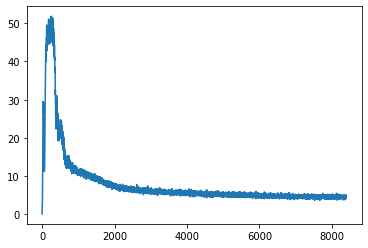

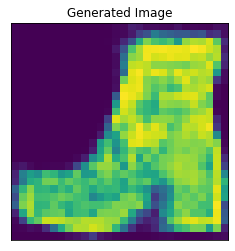

Iteration [8401/10000]......0.121(s) gen: -16.48686 - disc_fake: 17.86027 - disc_real: 22.44661 - disc_real: 4.58634
Iteration [8402/10000]......0.116(s) gen: -17.23958 - disc_fake: 17.55437 - disc_real: 21.91262 - disc_real: 4.35824
Iteration [8403/10000]......0.116(s) gen: -17.95259 - disc_fake: 17.83672 - disc_real: 22.13143 - disc_real: 4.29470
Iteration [8404/10000]......0.116(s) gen: -17.62990 - disc_fake: 17.72927 - disc_real: 22.50117 - disc_real: 4.77190
Iteration [8405/10000]......0.117(s) gen: -17.24158 - disc_fake: 17.69217 - disc_real: 22.21692 - disc_real: 4.52475
Iteration [8406/10000]......0.119(s) gen: -17.61728 - disc_fake: 17.72683 - disc_real: 22.36178 - disc_real: 4.63496
Iteration [8407/10000]......0.116(s) gen: -17.25453 - disc_fake: 17.58085 - disc_real: 21.89319 - disc_real: 4.31234
Iteration [8408/10000]......0.117(s) gen: -16.89231 - disc_fake: 16.95724 - disc_real: 21.57730 - disc_real: 4.62007
Iteration [8409/10000]......0.117(s) gen: -17.08005 - disc_fake:

Iteration [8471/10000]......0.125(s) gen: -17.71486 - disc_fake: 17.53578 - disc_real: 22.00534 - disc_real: 4.46956
Iteration [8472/10000]......0.122(s) gen: -17.02130 - disc_fake: 17.36115 - disc_real: 22.06129 - disc_real: 4.70015
Iteration [8473/10000]......0.121(s) gen: -18.64369 - disc_fake: 17.94652 - disc_real: 22.24978 - disc_real: 4.30326
Iteration [8474/10000]......0.119(s) gen: -18.35103 - disc_fake: 18.24514 - disc_real: 22.73095 - disc_real: 4.48581
Iteration [8475/10000]......0.120(s) gen: -19.04383 - disc_fake: 18.01418 - disc_real: 22.89994 - disc_real: 4.88576
Iteration [8476/10000]......0.123(s) gen: -19.31042 - disc_fake: 18.50808 - disc_real: 22.96849 - disc_real: 4.46041
Iteration [8477/10000]......0.122(s) gen: -18.02914 - disc_fake: 18.25038 - disc_real: 22.53739 - disc_real: 4.28701
Iteration [8478/10000]......0.124(s) gen: -17.38293 - disc_fake: 17.98868 - disc_real: 22.48008 - disc_real: 4.49140
Iteration [8479/10000]......0.123(s) gen: -17.61838 - disc_fake:

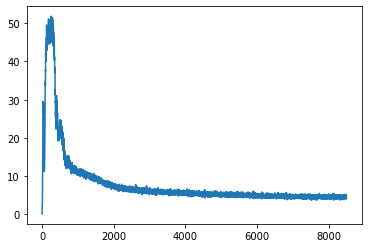

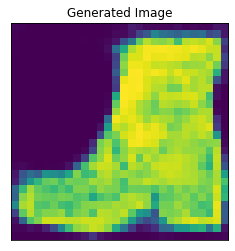

Iteration [8501/10000]......0.124(s) gen: -18.58202 - disc_fake: 18.25420 - disc_real: 22.69903 - disc_real: 4.44482
Iteration [8502/10000]......0.118(s) gen: -17.77864 - disc_fake: 18.74110 - disc_real: 23.15018 - disc_real: 4.40908
Iteration [8503/10000]......0.117(s) gen: -17.31871 - disc_fake: 17.81167 - disc_real: 22.25990 - disc_real: 4.44823
Iteration [8504/10000]......0.117(s) gen: -18.34764 - disc_fake: 18.05129 - disc_real: 22.38433 - disc_real: 4.33304
Iteration [8505/10000]......0.115(s) gen: -17.72324 - disc_fake: 18.16566 - disc_real: 22.70873 - disc_real: 4.54308
Iteration [8506/10000]......0.115(s) gen: -18.17563 - disc_fake: 17.54676 - disc_real: 22.21969 - disc_real: 4.67293
Iteration [8507/10000]......0.115(s) gen: -17.06237 - disc_fake: 17.86222 - disc_real: 22.30226 - disc_real: 4.44005
Iteration [8508/10000]......0.117(s) gen: -17.74097 - disc_fake: 17.52965 - disc_real: 21.97502 - disc_real: 4.44537
Iteration [8509/10000]......0.118(s) gen: -18.52705 - disc_fake:

Iteration [8571/10000]......0.120(s) gen: -18.78790 - disc_fake: 17.48862 - disc_real: 22.07344 - disc_real: 4.58482
Iteration [8572/10000]......0.119(s) gen: -16.80273 - disc_fake: 17.55673 - disc_real: 22.77555 - disc_real: 5.21882
Iteration [8573/10000]......0.119(s) gen: -16.70318 - disc_fake: 16.86508 - disc_real: 21.85972 - disc_real: 4.99464
Iteration [8574/10000]......0.119(s) gen: -17.71332 - disc_fake: 17.77659 - disc_real: 22.16382 - disc_real: 4.38723
Iteration [8575/10000]......0.120(s) gen: -17.28266 - disc_fake: 17.48524 - disc_real: 22.31063 - disc_real: 4.82539
Iteration [8576/10000]......0.119(s) gen: -18.60693 - disc_fake: 18.12341 - disc_real: 22.46115 - disc_real: 4.33775
Iteration [8577/10000]......0.118(s) gen: -19.31147 - disc_fake: 18.80872 - disc_real: 23.33561 - disc_real: 4.52689
Iteration [8578/10000]......0.120(s) gen: -18.20419 - disc_fake: 18.72673 - disc_real: 23.29572 - disc_real: 4.56899
Iteration [8579/10000]......0.120(s) gen: -18.27877 - disc_fake:

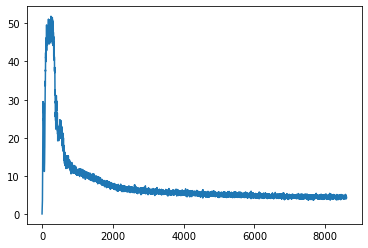

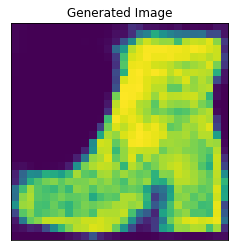

Iteration [8601/10000]......0.118(s) gen: -18.63524 - disc_fake: 18.09047 - disc_real: 22.47508 - disc_real: 4.38461
Iteration [8602/10000]......0.115(s) gen: -17.88485 - disc_fake: 18.62868 - disc_real: 23.14766 - disc_real: 4.51898
Iteration [8603/10000]......0.117(s) gen: -17.59435 - disc_fake: 18.17445 - disc_real: 22.23408 - disc_real: 4.05963
Iteration [8604/10000]......0.118(s) gen: -18.57391 - disc_fake: 18.55542 - disc_real: 22.63746 - disc_real: 4.08204
Iteration [8605/10000]......0.119(s) gen: -18.75986 - disc_fake: 17.99671 - disc_real: 22.26390 - disc_real: 4.26719
Iteration [8606/10000]......0.118(s) gen: -18.62194 - disc_fake: 18.17170 - disc_real: 22.86902 - disc_real: 4.69732
Iteration [8607/10000]......0.118(s) gen: -18.53282 - disc_fake: 18.43545 - disc_real: 23.00075 - disc_real: 4.56531
Iteration [8608/10000]......0.119(s) gen: -18.10834 - disc_fake: 18.53253 - disc_real: 22.71537 - disc_real: 4.18284
Iteration [8609/10000]......0.119(s) gen: -18.69593 - disc_fake:

Iteration [8671/10000]......0.122(s) gen: -18.09080 - disc_fake: 18.48009 - disc_real: 22.84068 - disc_real: 4.36059
Iteration [8672/10000]......0.121(s) gen: -17.70252 - disc_fake: 17.80378 - disc_real: 22.32410 - disc_real: 4.52032
Iteration [8673/10000]......0.119(s) gen: -17.53849 - disc_fake: 17.91995 - disc_real: 22.23185 - disc_real: 4.31190
Iteration [8674/10000]......0.120(s) gen: -18.57924 - disc_fake: 17.96385 - disc_real: 22.68792 - disc_real: 4.72407
Iteration [8675/10000]......0.122(s) gen: -18.10208 - disc_fake: 18.69818 - disc_real: 22.97157 - disc_real: 4.27339
Iteration [8676/10000]......0.121(s) gen: -17.73936 - disc_fake: 18.31006 - disc_real: 22.89083 - disc_real: 4.58077
Iteration [8677/10000]......0.121(s) gen: -18.52227 - disc_fake: 18.67294 - disc_real: 23.28332 - disc_real: 4.61038
Iteration [8678/10000]......0.122(s) gen: -18.10691 - disc_fake: 18.73991 - disc_real: 23.55806 - disc_real: 4.81815
Iteration [8679/10000]......0.120(s) gen: -19.07349 - disc_fake:

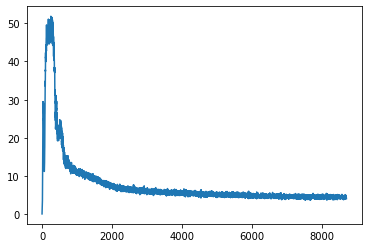

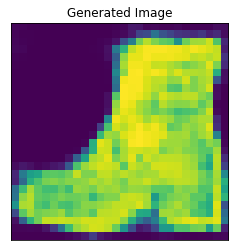

Iteration [8701/10000]......0.134(s) gen: -18.24587 - disc_fake: 18.65453 - disc_real: 23.14463 - disc_real: 4.49010
Iteration [8702/10000]......0.132(s) gen: -19.40766 - disc_fake: 18.65928 - disc_real: 23.14749 - disc_real: 4.48822
Iteration [8703/10000]......0.127(s) gen: -18.47535 - disc_fake: 18.53897 - disc_real: 23.39478 - disc_real: 4.85581
Iteration [8704/10000]......0.119(s) gen: -17.81477 - disc_fake: 18.63754 - disc_real: 22.67254 - disc_real: 4.03500
Iteration [8705/10000]......0.118(s) gen: -17.25275 - disc_fake: 17.38448 - disc_real: 22.13689 - disc_real: 4.75241
Iteration [8706/10000]......0.116(s) gen: -18.69411 - disc_fake: 17.76428 - disc_real: 22.15117 - disc_real: 4.38689
Iteration [8707/10000]......0.117(s) gen: -17.89187 - disc_fake: 18.23306 - disc_real: 22.86269 - disc_real: 4.62962
Iteration [8708/10000]......0.116(s) gen: -19.05989 - disc_fake: 18.40347 - disc_real: 23.07193 - disc_real: 4.66845
Iteration [8709/10000]......0.115(s) gen: -18.18237 - disc_fake:

Iteration [8772/10000]......0.120(s) gen: -17.54979 - disc_fake: 18.59233 - disc_real: 23.06957 - disc_real: 4.47724
Iteration [8773/10000]......0.120(s) gen: -17.58041 - disc_fake: 17.83186 - disc_real: 22.29632 - disc_real: 4.46446
Iteration [8774/10000]......0.121(s) gen: -18.71140 - disc_fake: 17.84361 - disc_real: 21.75806 - disc_real: 3.91445
Iteration [8775/10000]......0.122(s) gen: -18.50869 - disc_fake: 18.27493 - disc_real: 23.01300 - disc_real: 4.73808
Iteration [8776/10000]......0.121(s) gen: -18.22496 - disc_fake: 18.78506 - disc_real: 23.39778 - disc_real: 4.61272
Iteration [8777/10000]......0.122(s) gen: -18.39136 - disc_fake: 18.18408 - disc_real: 22.74271 - disc_real: 4.55863
Iteration [8778/10000]......0.122(s) gen: -19.18902 - disc_fake: 18.81829 - disc_real: 23.66625 - disc_real: 4.84796
Iteration [8779/10000]......0.122(s) gen: -17.26638 - disc_fake: 18.53248 - disc_real: 23.24332 - disc_real: 4.71084
Iteration [8780/10000]......0.122(s) gen: -17.88926 - disc_fake:

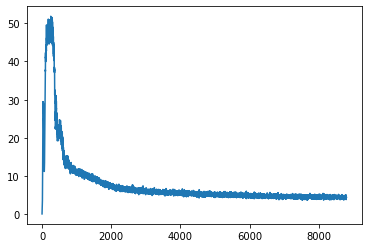

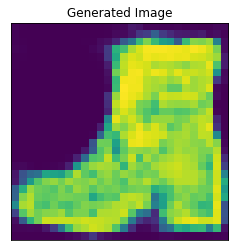

Iteration [8801/10000]......0.118(s) gen: -19.66686 - disc_fake: 18.56715 - disc_real: 23.63318 - disc_real: 5.06603
Iteration [8802/10000]......0.114(s) gen: -19.10886 - disc_fake: 19.23491 - disc_real: 23.52986 - disc_real: 4.29495
Iteration [8803/10000]......0.115(s) gen: -18.69772 - disc_fake: 18.83264 - disc_real: 22.74762 - disc_real: 3.91498
Iteration [8804/10000]......0.115(s) gen: -18.11649 - disc_fake: 18.98921 - disc_real: 23.49338 - disc_real: 4.50417
Iteration [8805/10000]......0.114(s) gen: -18.32626 - disc_fake: 18.50095 - disc_real: 22.83189 - disc_real: 4.33094
Iteration [8806/10000]......0.116(s) gen: -17.69845 - disc_fake: 18.74876 - disc_real: 23.03831 - disc_real: 4.28955
Iteration [8807/10000]......0.115(s) gen: -19.25388 - disc_fake: 18.52043 - disc_real: 22.52106 - disc_real: 4.00063
Iteration [8808/10000]......0.116(s) gen: -18.39778 - disc_fake: 19.14722 - disc_real: 23.97259 - disc_real: 4.82537
Iteration [8809/10000]......0.115(s) gen: -17.93779 - disc_fake:

Iteration [8871/10000]......0.124(s) gen: -17.21542 - disc_fake: 17.32398 - disc_real: 22.44620 - disc_real: 5.12222
Iteration [8872/10000]......0.125(s) gen: -18.10600 - disc_fake: 18.13605 - disc_real: 22.70936 - disc_real: 4.57331
Iteration [8873/10000]......0.123(s) gen: -19.07085 - disc_fake: 18.37325 - disc_real: 23.18012 - disc_real: 4.80687
Iteration [8874/10000]......0.123(s) gen: -18.10958 - disc_fake: 18.74240 - disc_real: 23.16755 - disc_real: 4.42515
Iteration [8875/10000]......0.121(s) gen: -18.08558 - disc_fake: 18.33097 - disc_real: 22.89916 - disc_real: 4.56819
Iteration [8876/10000]......0.120(s) gen: -18.70916 - disc_fake: 17.92591 - disc_real: 22.82425 - disc_real: 4.89834
Iteration [8877/10000]......0.121(s) gen: -17.98269 - disc_fake: 18.56109 - disc_real: 22.87444 - disc_real: 4.31335
Iteration [8878/10000]......0.122(s) gen: -19.19491 - disc_fake: 19.26280 - disc_real: 23.66751 - disc_real: 4.40471
Iteration [8879/10000]......0.122(s) gen: -18.82938 - disc_fake:

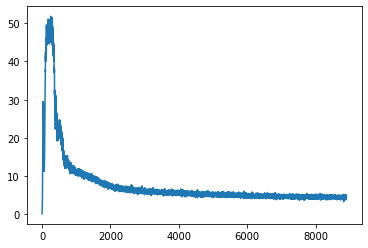

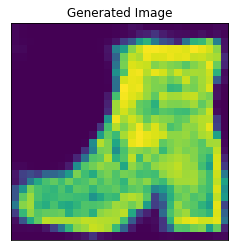

Iteration [8901/10000]......0.123(s) gen: -19.28161 - disc_fake: 18.72710 - disc_real: 23.14204 - disc_real: 4.41495
Iteration [8902/10000]......0.117(s) gen: -19.27636 - disc_fake: 18.72193 - disc_real: 22.97415 - disc_real: 4.25222
Iteration [8903/10000]......0.118(s) gen: -18.16990 - disc_fake: 18.77913 - disc_real: 23.36368 - disc_real: 4.58456
Iteration [8904/10000]......0.119(s) gen: -18.90458 - disc_fake: 18.60838 - disc_real: 23.10439 - disc_real: 4.49601
Iteration [8905/10000]......0.118(s) gen: -17.89982 - disc_fake: 18.56502 - disc_real: 22.89681 - disc_real: 4.33179
Iteration [8906/10000]......0.119(s) gen: -18.69615 - disc_fake: 18.17991 - disc_real: 22.69022 - disc_real: 4.51031
Iteration [8907/10000]......0.118(s) gen: -18.48184 - disc_fake: 18.47622 - disc_real: 22.98426 - disc_real: 4.50804
Iteration [8908/10000]......0.118(s) gen: -18.35204 - disc_fake: 19.12642 - disc_real: 23.33139 - disc_real: 4.20497
Iteration [8909/10000]......0.118(s) gen: -19.58863 - disc_fake:

Iteration [8971/10000]......0.122(s) gen: -19.42266 - disc_fake: 20.14066 - disc_real: 24.63491 - disc_real: 4.49425
Iteration [8972/10000]......0.122(s) gen: -20.43976 - disc_fake: 19.35683 - disc_real: 24.11740 - disc_real: 4.76058
Iteration [8973/10000]......0.122(s) gen: -18.73520 - disc_fake: 19.01362 - disc_real: 23.65527 - disc_real: 4.64164
Iteration [8974/10000]......0.119(s) gen: -18.43129 - disc_fake: 18.94208 - disc_real: 23.22890 - disc_real: 4.28682
Iteration [8975/10000]......0.118(s) gen: -19.32553 - disc_fake: 18.62845 - disc_real: 22.74944 - disc_real: 4.12099
Iteration [8976/10000]......0.121(s) gen: -17.23578 - disc_fake: 18.68370 - disc_real: 23.14111 - disc_real: 4.45741
Iteration [8977/10000]......0.121(s) gen: -17.87999 - disc_fake: 17.68233 - disc_real: 22.28113 - disc_real: 4.59880
Iteration [8978/10000]......0.116(s) gen: -18.97196 - disc_fake: 19.00937 - disc_real: 22.84944 - disc_real: 3.84007
Iteration [8979/10000]......0.117(s) gen: -18.75826 - disc_fake:

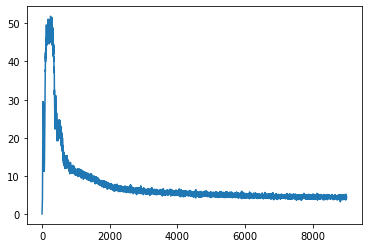

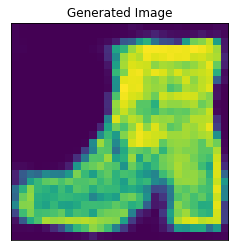

Iteration [9001/10000]......0.121(s) gen: -19.20590 - disc_fake: 18.71069 - disc_real: 23.22996 - disc_real: 4.51926
Iteration [9002/10000]......0.116(s) gen: -18.40238 - disc_fake: 19.43071 - disc_real: 23.92464 - disc_real: 4.49393
Iteration [9003/10000]......0.124(s) gen: -18.55223 - disc_fake: 18.51995 - disc_real: 22.98452 - disc_real: 4.46457
Iteration [9004/10000]......0.117(s) gen: -19.24542 - disc_fake: 18.82589 - disc_real: 22.89952 - disc_real: 4.07364
Iteration [9005/10000]......0.119(s) gen: -18.51221 - disc_fake: 18.34692 - disc_real: 22.51547 - disc_real: 4.16855
Iteration [9006/10000]......0.119(s) gen: -18.56460 - disc_fake: 19.06479 - disc_real: 23.06168 - disc_real: 3.99689
Iteration [9007/10000]......0.120(s) gen: -19.33808 - disc_fake: 19.32097 - disc_real: 23.88859 - disc_real: 4.56762
Iteration [9008/10000]......0.120(s) gen: -19.78465 - disc_fake: 20.18251 - disc_real: 24.41602 - disc_real: 4.23350
Iteration [9009/10000]......0.120(s) gen: -19.11608 - disc_fake:

Iteration [9071/10000]......0.120(s) gen: -18.54391 - disc_fake: 18.89601 - disc_real: 23.12260 - disc_real: 4.22659
Iteration [9072/10000]......0.121(s) gen: -18.27198 - disc_fake: 19.02407 - disc_real: 22.74243 - disc_real: 3.71835
Iteration [9073/10000]......0.120(s) gen: -16.41233 - disc_fake: 17.65133 - disc_real: 22.12861 - disc_real: 4.47728
Iteration [9074/10000]......0.120(s) gen: -19.06751 - disc_fake: 17.98776 - disc_real: 22.81288 - disc_real: 4.82512
Iteration [9075/10000]......0.120(s) gen: -19.34494 - disc_fake: 19.28168 - disc_real: 23.20816 - disc_real: 3.92648
Iteration [9076/10000]......0.121(s) gen: -20.27819 - disc_fake: 19.66054 - disc_real: 23.80985 - disc_real: 4.14930
Iteration [9077/10000]......0.120(s) gen: -19.13365 - disc_fake: 19.96350 - disc_real: 23.86086 - disc_real: 3.89736
Iteration [9078/10000]......0.121(s) gen: -19.89362 - disc_fake: 19.32312 - disc_real: 23.44120 - disc_real: 4.11808
Iteration [9079/10000]......0.120(s) gen: -18.94661 - disc_fake:

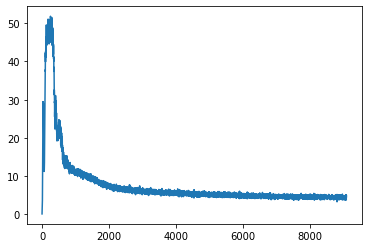

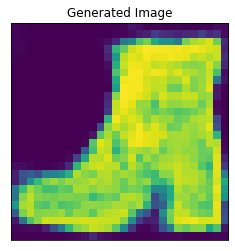

Iteration [9101/10000]......0.117(s) gen: -18.97934 - disc_fake: 19.37480 - disc_real: 23.97074 - disc_real: 4.59594
Iteration [9102/10000]......0.118(s) gen: -19.04578 - disc_fake: 19.04756 - disc_real: 23.08756 - disc_real: 4.03999
Iteration [9103/10000]......0.120(s) gen: -18.99682 - disc_fake: 18.86349 - disc_real: 22.72892 - disc_real: 3.86543
Iteration [9104/10000]......0.117(s) gen: -17.88079 - disc_fake: 18.59245 - disc_real: 23.40885 - disc_real: 4.81640
Iteration [9105/10000]......0.117(s) gen: -17.74648 - disc_fake: 18.44805 - disc_real: 22.93682 - disc_real: 4.48877
Iteration [9106/10000]......0.127(s) gen: -20.23710 - disc_fake: 18.72768 - disc_real: 23.43464 - disc_real: 4.70695
Iteration [9107/10000]......0.119(s) gen: -19.31521 - disc_fake: 19.63859 - disc_real: 23.45800 - disc_real: 3.81941
Iteration [9108/10000]......0.119(s) gen: -19.93333 - disc_fake: 19.52928 - disc_real: 24.06305 - disc_real: 4.53377
Iteration [9109/10000]......0.117(s) gen: -19.07809 - disc_fake:

Iteration [9172/10000]......0.121(s) gen: -19.67850 - disc_fake: 19.43205 - disc_real: 23.71652 - disc_real: 4.28447
Iteration [9173/10000]......0.121(s) gen: -19.47731 - disc_fake: 19.68779 - disc_real: 23.93372 - disc_real: 4.24593
Iteration [9174/10000]......0.121(s) gen: -19.90712 - disc_fake: 19.80730 - disc_real: 24.53388 - disc_real: 4.72658
Iteration [9175/10000]......0.121(s) gen: -19.65785 - disc_fake: 20.03166 - disc_real: 24.16481 - disc_real: 4.13316
Iteration [9176/10000]......0.122(s) gen: -19.40493 - disc_fake: 20.21960 - disc_real: 24.27208 - disc_real: 4.05248
Iteration [9177/10000]......0.124(s) gen: -18.29953 - disc_fake: 18.91081 - disc_real: 23.39185 - disc_real: 4.48105
Iteration [9178/10000]......0.122(s) gen: -19.55979 - disc_fake: 18.96080 - disc_real: 22.85826 - disc_real: 3.89747
Iteration [9179/10000]......0.123(s) gen: -20.23703 - disc_fake: 19.55308 - disc_real: 23.64065 - disc_real: 4.08757
Iteration [9180/10000]......0.123(s) gen: -20.20927 - disc_fake:

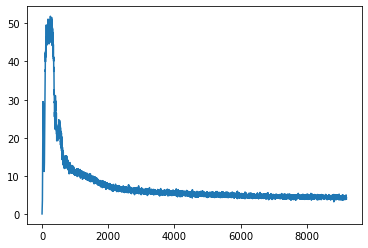

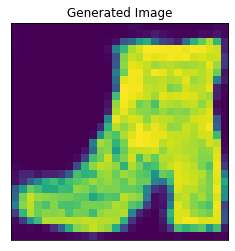

Iteration [9201/10000]......0.114(s) gen: -18.95807 - disc_fake: 19.28309 - disc_real: 23.70018 - disc_real: 4.41709
Iteration [9202/10000]......0.115(s) gen: -17.66483 - disc_fake: 18.58481 - disc_real: 23.24338 - disc_real: 4.65857
Iteration [9203/10000]......0.117(s) gen: -19.49932 - disc_fake: 18.63894 - disc_real: 22.64395 - disc_real: 4.00501
Iteration [9204/10000]......0.117(s) gen: -20.20633 - disc_fake: 19.36636 - disc_real: 23.26759 - disc_real: 3.90123
Iteration [9205/10000]......0.117(s) gen: -19.32391 - disc_fake: 19.49206 - disc_real: 24.61698 - disc_real: 5.12493
Iteration [9206/10000]......0.118(s) gen: -18.48238 - disc_fake: 18.89293 - disc_real: 23.46310 - disc_real: 4.57017
Iteration [9207/10000]......0.118(s) gen: -18.36507 - disc_fake: 18.90476 - disc_real: 23.72850 - disc_real: 4.82375
Iteration [9208/10000]......0.118(s) gen: -18.54715 - disc_fake: 18.30143 - disc_real: 22.75837 - disc_real: 4.45693
Iteration [9209/10000]......0.119(s) gen: -18.90554 - disc_fake:

Iteration [9271/10000]......0.130(s) gen: -17.83440 - disc_fake: 19.17610 - disc_real: 23.34435 - disc_real: 4.16825
Iteration [9272/10000]......0.128(s) gen: -17.24360 - disc_fake: 18.26104 - disc_real: 22.65859 - disc_real: 4.39755
Iteration [9273/10000]......0.126(s) gen: -19.74014 - disc_fake: 18.63736 - disc_real: 22.80373 - disc_real: 4.16637
Iteration [9274/10000]......0.122(s) gen: -19.54953 - disc_fake: 19.58293 - disc_real: 23.89885 - disc_real: 4.31592
Iteration [9275/10000]......0.121(s) gen: -19.04613 - disc_fake: 19.71892 - disc_real: 23.87834 - disc_real: 4.15942
Iteration [9276/10000]......0.119(s) gen: -19.86261 - disc_fake: 19.43876 - disc_real: 23.55672 - disc_real: 4.11796
Iteration [9277/10000]......0.119(s) gen: -20.08679 - disc_fake: 20.06601 - disc_real: 24.97062 - disc_real: 4.90461
Iteration [9278/10000]......0.119(s) gen: -19.03365 - disc_fake: 19.67018 - disc_real: 24.23278 - disc_real: 4.56260
Iteration [9279/10000]......0.119(s) gen: -19.09198 - disc_fake:

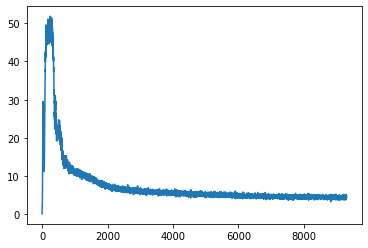

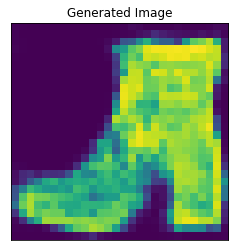

Iteration [9301/10000]......0.117(s) gen: -19.94901 - disc_fake: 20.06715 - disc_real: 24.25276 - disc_real: 4.18560
Iteration [9302/10000]......0.114(s) gen: -19.30090 - disc_fake: 19.15355 - disc_real: 22.97112 - disc_real: 3.81758
Iteration [9303/10000]......0.116(s) gen: -18.64659 - disc_fake: 18.58714 - disc_real: 23.31075 - disc_real: 4.72361
Iteration [9304/10000]......0.117(s) gen: -19.25655 - disc_fake: 19.64546 - disc_real: 23.81680 - disc_real: 4.17135
Iteration [9305/10000]......0.116(s) gen: -19.56890 - disc_fake: 19.40589 - disc_real: 23.58034 - disc_real: 4.17446
Iteration [9306/10000]......0.115(s) gen: -20.49686 - disc_fake: 19.55812 - disc_real: 24.02080 - disc_real: 4.46268
Iteration [9307/10000]......0.117(s) gen: -19.93435 - disc_fake: 20.04241 - disc_real: 24.34339 - disc_real: 4.30098
Iteration [9308/10000]......0.119(s) gen: -20.02741 - disc_fake: 19.46128 - disc_real: 23.90306 - disc_real: 4.44179
Iteration [9309/10000]......0.118(s) gen: -19.18114 - disc_fake:

Iteration [9371/10000]......0.121(s) gen: -20.55520 - disc_fake: 19.93612 - disc_real: 24.31584 - disc_real: 4.37973
Iteration [9372/10000]......0.121(s) gen: -19.82691 - disc_fake: 19.82662 - disc_real: 24.48929 - disc_real: 4.66267
Iteration [9373/10000]......0.123(s) gen: -20.03920 - disc_fake: 19.44185 - disc_real: 23.82657 - disc_real: 4.38472
Iteration [9374/10000]......0.120(s) gen: -19.32318 - disc_fake: 19.78970 - disc_real: 24.39773 - disc_real: 4.60802
Iteration [9375/10000]......0.120(s) gen: -20.27215 - disc_fake: 19.42111 - disc_real: 23.66666 - disc_real: 4.24555
Iteration [9376/10000]......0.121(s) gen: -19.43020 - disc_fake: 19.69347 - disc_real: 24.32512 - disc_real: 4.63165
Iteration [9377/10000]......0.120(s) gen: -19.36408 - disc_fake: 20.17308 - disc_real: 24.09107 - disc_real: 3.91799
Iteration [9378/10000]......0.119(s) gen: -19.77084 - disc_fake: 19.77628 - disc_real: 24.15778 - disc_real: 4.38150
Iteration [9379/10000]......0.119(s) gen: -19.21299 - disc_fake:

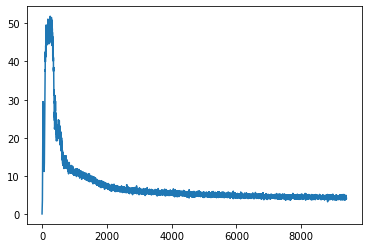

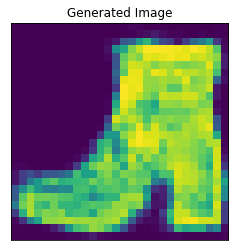

Iteration [9401/10000]......0.120(s) gen: -18.85879 - disc_fake: 19.05939 - disc_real: 23.32789 - disc_real: 4.26849
Iteration [9402/10000]......0.116(s) gen: -20.09388 - disc_fake: 19.88858 - disc_real: 24.36737 - disc_real: 4.47879
Iteration [9403/10000]......0.115(s) gen: -19.07511 - disc_fake: 19.72152 - disc_real: 24.55556 - disc_real: 4.83403
Iteration [9404/10000]......0.116(s) gen: -20.15404 - disc_fake: 20.36460 - disc_real: 24.55440 - disc_real: 4.18980
Iteration [9405/10000]......0.117(s) gen: -19.23917 - disc_fake: 19.33878 - disc_real: 23.47048 - disc_real: 4.13170
Iteration [9406/10000]......0.116(s) gen: -17.66613 - disc_fake: 18.96983 - disc_real: 23.36486 - disc_real: 4.39503
Iteration [9407/10000]......0.118(s) gen: -18.61356 - disc_fake: 18.15269 - disc_real: 22.75097 - disc_real: 4.59828
Iteration [9408/10000]......0.117(s) gen: -18.22396 - disc_fake: 18.37653 - disc_real: 23.06327 - disc_real: 4.68674
Iteration [9409/10000]......0.118(s) gen: -20.51838 - disc_fake:

Iteration [9471/10000]......0.122(s) gen: -20.51794 - disc_fake: 20.15376 - disc_real: 24.51431 - disc_real: 4.36055
Iteration [9472/10000]......0.122(s) gen: -19.96688 - disc_fake: 20.62598 - disc_real: 24.59734 - disc_real: 3.97136
Iteration [9473/10000]......0.123(s) gen: -19.23108 - disc_fake: 19.60931 - disc_real: 24.05529 - disc_real: 4.44598
Iteration [9474/10000]......0.122(s) gen: -19.65051 - disc_fake: 19.70712 - disc_real: 24.82097 - disc_real: 5.11385
Iteration [9475/10000]......0.123(s) gen: -19.22338 - disc_fake: 19.83305 - disc_real: 24.09849 - disc_real: 4.26544
Iteration [9476/10000]......0.122(s) gen: -19.57042 - disc_fake: 19.71877 - disc_real: 24.32264 - disc_real: 4.60387
Iteration [9477/10000]......0.123(s) gen: -19.60308 - disc_fake: 19.44611 - disc_real: 23.86524 - disc_real: 4.41914
Iteration [9478/10000]......0.122(s) gen: -19.55589 - disc_fake: 19.72344 - disc_real: 24.25829 - disc_real: 4.53485
Iteration [9479/10000]......0.123(s) gen: -19.83104 - disc_fake:

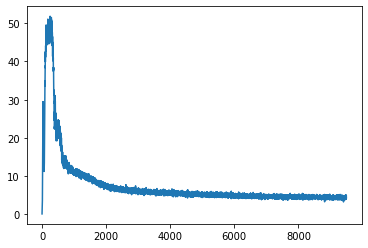

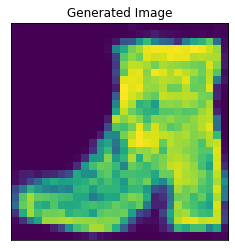

Iteration [9501/10000]......0.122(s) gen: -19.16374 - disc_fake: 20.15422 - disc_real: 24.60274 - disc_real: 4.44852
Iteration [9502/10000]......0.117(s) gen: -19.96475 - disc_fake: 19.93539 - disc_real: 24.26888 - disc_real: 4.33349
Iteration [9503/10000]......0.116(s) gen: -20.64338 - disc_fake: 20.07938 - disc_real: 24.43023 - disc_real: 4.35084
Iteration [9504/10000]......0.118(s) gen: -18.97235 - disc_fake: 19.75171 - disc_real: 23.75878 - disc_real: 4.00707
Iteration [9505/10000]......0.118(s) gen: -19.15760 - disc_fake: 18.93329 - disc_real: 23.27512 - disc_real: 4.34183
Iteration [9506/10000]......0.120(s) gen: -20.56684 - disc_fake: 19.65797 - disc_real: 24.39140 - disc_real: 4.73344
Iteration [9507/10000]......0.118(s) gen: -20.47275 - disc_fake: 20.45542 - disc_real: 25.34988 - disc_real: 4.89446
Iteration [9508/10000]......0.119(s) gen: -19.49471 - disc_fake: 20.54341 - disc_real: 24.65432 - disc_real: 4.11092
Iteration [9509/10000]......0.119(s) gen: -19.70383 - disc_fake:

Iteration [9571/10000]......0.120(s) gen: -18.86661 - disc_fake: 19.61381 - disc_real: 23.86075 - disc_real: 4.24694
Iteration [9572/10000]......0.120(s) gen: -19.64299 - disc_fake: 19.52640 - disc_real: 23.84276 - disc_real: 4.31637
Iteration [9573/10000]......0.120(s) gen: -19.71203 - disc_fake: 20.29779 - disc_real: 24.37432 - disc_real: 4.07653
Iteration [9574/10000]......0.120(s) gen: -21.34219 - disc_fake: 20.43180 - disc_real: 24.95827 - disc_real: 4.52647
Iteration [9575/10000]......0.120(s) gen: -20.17253 - disc_fake: 21.25833 - disc_real: 25.73267 - disc_real: 4.47434
Iteration [9576/10000]......0.120(s) gen: -19.40738 - disc_fake: 20.19184 - disc_real: 24.42668 - disc_real: 4.23484
Iteration [9577/10000]......0.120(s) gen: -19.18960 - disc_fake: 19.89462 - disc_real: 24.25363 - disc_real: 4.35901
Iteration [9578/10000]......0.119(s) gen: -19.65203 - disc_fake: 19.63639 - disc_real: 23.89929 - disc_real: 4.26290
Iteration [9579/10000]......0.121(s) gen: -19.48174 - disc_fake:

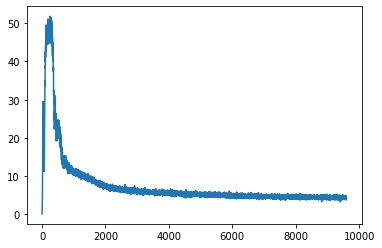

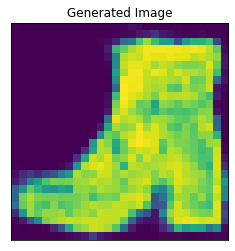

Iteration [9601/10000]......0.119(s) gen: -19.87983 - disc_fake: 20.03917 - disc_real: 24.07824 - disc_real: 4.03907
Iteration [9602/10000]......0.117(s) gen: -19.61887 - disc_fake: 19.83403 - disc_real: 24.14967 - disc_real: 4.31564
Iteration [9603/10000]......0.118(s) gen: -19.09676 - disc_fake: 19.61807 - disc_real: 24.26553 - disc_real: 4.64746
Iteration [9604/10000]......0.118(s) gen: -19.01104 - disc_fake: 19.72561 - disc_real: 24.50311 - disc_real: 4.77750
Iteration [9605/10000]......0.118(s) gen: -19.62810 - disc_fake: 19.65059 - disc_real: 24.27913 - disc_real: 4.62854
Iteration [9606/10000]......0.120(s) gen: -19.23621 - disc_fake: 19.92142 - disc_real: 24.14483 - disc_real: 4.22341
Iteration [9607/10000]......0.119(s) gen: -20.85594 - disc_fake: 20.65668 - disc_real: 24.65909 - disc_real: 4.00241
Iteration [9608/10000]......0.118(s) gen: -20.13387 - disc_fake: 20.78563 - disc_real: 24.90401 - disc_real: 4.11838
Iteration [9609/10000]......0.118(s) gen: -20.36662 - disc_fake:

Iteration [9671/10000]......0.120(s) gen: -21.06741 - disc_fake: 20.38345 - disc_real: 25.01998 - disc_real: 4.63654
Iteration [9672/10000]......0.119(s) gen: -21.61648 - disc_fake: 20.71827 - disc_real: 24.64601 - disc_real: 3.92774
Iteration [9673/10000]......0.120(s) gen: -21.25844 - disc_fake: 21.44337 - disc_real: 25.62302 - disc_real: 4.17965
Iteration [9674/10000]......0.120(s) gen: -20.84311 - disc_fake: 20.86701 - disc_real: 24.76838 - disc_real: 3.90137
Iteration [9675/10000]......0.120(s) gen: -19.15376 - disc_fake: 20.60499 - disc_real: 24.57204 - disc_real: 3.96705
Iteration [9676/10000]......0.122(s) gen: -19.54380 - disc_fake: 20.08708 - disc_real: 24.61364 - disc_real: 4.52656
Iteration [9677/10000]......0.122(s) gen: -19.77778 - disc_fake: 19.62998 - disc_real: 24.24333 - disc_real: 4.61335
Iteration [9678/10000]......0.123(s) gen: -20.18415 - disc_fake: 19.97411 - disc_real: 24.41548 - disc_real: 4.44137
Iteration [9679/10000]......0.122(s) gen: -20.01417 - disc_fake:

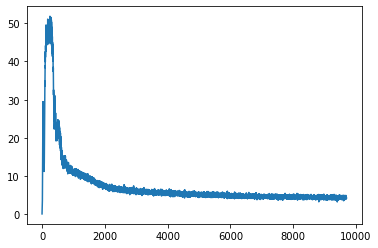

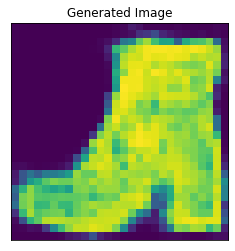

Iteration [9701/10000]......0.121(s) gen: -20.57801 - disc_fake: 19.87792 - disc_real: 24.71841 - disc_real: 4.84049
Iteration [9702/10000]......0.115(s) gen: -20.33331 - disc_fake: 20.53137 - disc_real: 24.81069 - disc_real: 4.27932
Iteration [9703/10000]......0.116(s) gen: -19.43283 - disc_fake: 19.70929 - disc_real: 23.64036 - disc_real: 3.93107
Iteration [9704/10000]......0.118(s) gen: -20.25026 - disc_fake: 19.34621 - disc_real: 24.37826 - disc_real: 5.03205
Iteration [9705/10000]......0.119(s) gen: -19.83335 - disc_fake: 20.19866 - disc_real: 24.41341 - disc_real: 4.21475
Iteration [9706/10000]......0.118(s) gen: -20.71151 - disc_fake: 20.71732 - disc_real: 25.05308 - disc_real: 4.33576
Iteration [9707/10000]......0.118(s) gen: -21.03899 - disc_fake: 20.90327 - disc_real: 25.16567 - disc_real: 4.26240
Iteration [9708/10000]......0.119(s) gen: -20.95090 - disc_fake: 20.88873 - disc_real: 25.85094 - disc_real: 4.96220
Iteration [9709/10000]......0.120(s) gen: -22.94751 - disc_fake:

Iteration [9772/10000]......0.119(s) gen: -20.93372 - disc_fake: 21.72108 - disc_real: 26.02693 - disc_real: 4.30585
Iteration [9773/10000]......0.119(s) gen: -20.26678 - disc_fake: 20.68876 - disc_real: 24.88482 - disc_real: 4.19607
Iteration [9774/10000]......0.120(s) gen: -19.39965 - disc_fake: 20.26985 - disc_real: 24.47735 - disc_real: 4.20751
Iteration [9775/10000]......0.120(s) gen: -18.57345 - disc_fake: 18.97411 - disc_real: 23.44566 - disc_real: 4.47155
Iteration [9776/10000]......0.120(s) gen: -19.66285 - disc_fake: 18.93850 - disc_real: 23.56795 - disc_real: 4.62945
Iteration [9777/10000]......0.119(s) gen: -20.10410 - disc_fake: 20.11651 - disc_real: 24.26120 - disc_real: 4.14469
Iteration [9778/10000]......0.120(s) gen: -19.86393 - disc_fake: 19.64334 - disc_real: 23.87131 - disc_real: 4.22797
Iteration [9779/10000]......0.119(s) gen: -20.93712 - disc_fake: 20.19727 - disc_real: 24.50551 - disc_real: 4.30824
Iteration [9780/10000]......0.120(s) gen: -20.62650 - disc_fake:

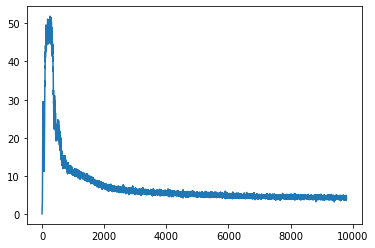

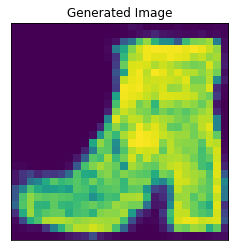

Iteration [9801/10000]......0.119(s) gen: -19.97403 - disc_fake: 19.41574 - disc_real: 23.38675 - disc_real: 3.97102
Iteration [9802/10000]......0.115(s) gen: -20.69716 - disc_fake: 20.72824 - disc_real: 25.03084 - disc_real: 4.30260
Iteration [9803/10000]......0.115(s) gen: -20.31961 - disc_fake: 20.28245 - disc_real: 24.86151 - disc_real: 4.57906
Iteration [9804/10000]......0.115(s) gen: -20.78324 - disc_fake: 20.39046 - disc_real: 24.87433 - disc_real: 4.48387
Iteration [9805/10000]......0.115(s) gen: -20.14630 - disc_fake: 20.26793 - disc_real: 24.58471 - disc_real: 4.31678
Iteration [9806/10000]......0.114(s) gen: -20.40575 - disc_fake: 19.70189 - disc_real: 24.31740 - disc_real: 4.61551
Iteration [9807/10000]......0.114(s) gen: -20.54178 - disc_fake: 20.46734 - disc_real: 24.70928 - disc_real: 4.24194
Iteration [9808/10000]......0.115(s) gen: -20.01461 - disc_fake: 20.39358 - disc_real: 24.77486 - disc_real: 4.38128
Iteration [9809/10000]......0.114(s) gen: -21.28374 - disc_fake:

Iteration [9872/10000]......0.124(s) gen: -20.24392 - disc_fake: 20.52576 - disc_real: 24.94113 - disc_real: 4.41537
Iteration [9873/10000]......0.126(s) gen: -20.21211 - disc_fake: 20.56173 - disc_real: 24.89390 - disc_real: 4.33216
Iteration [9874/10000]......0.123(s) gen: -20.68251 - disc_fake: 20.44280 - disc_real: 25.04202 - disc_real: 4.59923
Iteration [9875/10000]......0.122(s) gen: -19.11546 - disc_fake: 19.96534 - disc_real: 23.67035 - disc_real: 3.70500
Iteration [9876/10000]......0.122(s) gen: -19.69566 - disc_fake: 19.43937 - disc_real: 24.02216 - disc_real: 4.58279
Iteration [9877/10000]......0.121(s) gen: -20.84521 - disc_fake: 20.15598 - disc_real: 24.58319 - disc_real: 4.42720
Iteration [9878/10000]......0.118(s) gen: -19.71197 - disc_fake: 19.98286 - disc_real: 24.49364 - disc_real: 4.51078
Iteration [9879/10000]......0.118(s) gen: -20.78721 - disc_fake: 20.51818 - disc_real: 24.76660 - disc_real: 4.24842
Iteration [9880/10000]......0.119(s) gen: -20.90216 - disc_fake:

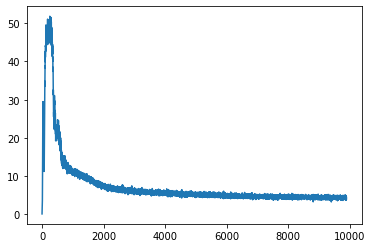

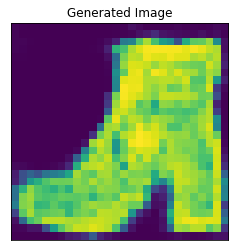

Iteration [9901/10000]......0.121(s) gen: -20.35498 - disc_fake: 20.55614 - disc_real: 25.08417 - disc_real: 4.52803
Iteration [9902/10000]......0.121(s) gen: -21.75182 - disc_fake: 21.35656 - disc_real: 25.48775 - disc_real: 4.13120
Iteration [9903/10000]......0.119(s) gen: -20.83257 - disc_fake: 21.05933 - disc_real: 25.34090 - disc_real: 4.28157
Iteration [9904/10000]......0.119(s) gen: -20.31156 - disc_fake: 20.41219 - disc_real: 24.16771 - disc_real: 3.75553
Iteration [9905/10000]......0.117(s) gen: -18.95342 - disc_fake: 19.89763 - disc_real: 24.24913 - disc_real: 4.35149
Iteration [9906/10000]......0.118(s) gen: -19.83860 - disc_fake: 19.81308 - disc_real: 23.70259 - disc_real: 3.88952
Iteration [9907/10000]......0.117(s) gen: -21.18808 - disc_fake: 20.24352 - disc_real: 24.84441 - disc_real: 4.60089
Iteration [9908/10000]......0.119(s) gen: -21.58474 - disc_fake: 21.38426 - disc_real: 26.19290 - disc_real: 4.80865
Iteration [9909/10000]......0.126(s) gen: -20.89710 - disc_fake:

Iteration [9972/10000]......0.118(s) gen: -20.63233 - disc_fake: 20.80166 - disc_real: 25.49253 - disc_real: 4.69086
Iteration [9973/10000]......0.120(s) gen: -21.31356 - disc_fake: 20.88525 - disc_real: 24.83639 - disc_real: 3.95114
Iteration [9974/10000]......0.123(s) gen: -20.33430 - disc_fake: 20.85190 - disc_real: 25.15247 - disc_real: 4.30056
Iteration [9975/10000]......0.122(s) gen: -21.11973 - disc_fake: 20.82535 - disc_real: 25.43729 - disc_real: 4.61195
Iteration [9976/10000]......0.121(s) gen: -21.34212 - disc_fake: 21.40457 - disc_real: 25.43989 - disc_real: 4.03532
Iteration [9977/10000]......0.122(s) gen: -21.26044 - disc_fake: 20.88652 - disc_real: 25.76346 - disc_real: 4.87694
Iteration [9978/10000]......0.121(s) gen: -18.85984 - disc_fake: 20.35886 - disc_real: 24.29578 - disc_real: 3.93692
Iteration [9979/10000]......0.121(s) gen: -19.95494 - disc_fake: 19.63529 - disc_real: 23.93143 - disc_real: 4.29614
Iteration [9980/10000]......0.122(s) gen: -21.43886 - disc_fake:

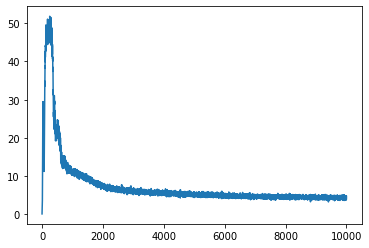

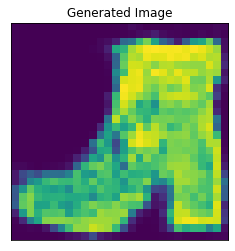

checkpointing at epoch: 10000


In [12]:
import time
from pathlib import Path

start_epoch = 1
epochs = 10000
batch_size = 64
checkpoint_every_n_epochs = 2000
figure_every_n_epochs = 100
n_critic = 5



plt.ioff()

model_type = f'wgan-gp'
data_name = f'fashion-MNIST'


#create base dir
base_model_path = Path(f'./model-data/{model_type}/{data_name}')
base_model_path.mkdir(parents=True, exist_ok=True)

#create figure dir
figure_model_path = base_model_path / 'figures'
figure_model_path.mkdir(parents=True, exist_ok=True)

#create checkpoint dir
checkpoints_model_path = base_model_path / 'checkpoints'
checkpoints_model_path.mkdir(parents=True, exist_ok=True)


with tf.device('gpu:0'):
    
    if start_epoch == 1:
        training_imgs = np.cast['float32'](x_train)
        num_batches = len(training_imgs) // batch_size
        rl_lo_loss_list = [] 
        rl_med_loss_list = [] 
        rl_hi_loss_list = [] 
        kl_loss_list = []
        gen_loss_list = []
        disc_real_list = []
        disc_fake_list = []
        mu, sigma = 0, 1 #mean and standard deviation
        test_noise = np.random.normal(mu, sigma, (1, latent_dim))
    

    rl_lo_loss = 0
    rl_med_loss = 0
    rl_hi_loss = 0
    kl_loss = 0
    gen_loss = 0

    
    for epoch in range(start_epoch,epochs+1):
        start = time.time()
        print(f'Iteration [{epoch}/{epochs}]...'.ljust(20), end = '')
 
        
        
        disc_real_sum = 0
        disc_fake_sum = 0
        for _ in range(n_critic):
            idxs_batch = np.random.randint(0,len(training_imgs)-1,size=batch_size)
            img_batch = training_imgs[idxs_batch]
            disc_real, disc_fake = train_step_discriminator(img_batch)
            disc_real_sum += K.get_value(disc_real)
            disc_fake_sum += K.get_value(disc_fake)            
        
        
        
        gen_loss = train_step_generator()
        
        
        
        disc_real = disc_real_sum/n_critic
        disc_fake = disc_fake_sum/n_critic
        gen_loss = K.get_value(gen_loss)

        
        
        disc_real_list.append(disc_real)
        disc_fake_list.append(disc_fake)
        gen_loss_list.append(gen_loss)

        
        print(f'...{time.time()-start:.3f}(s) '  , end='')        
        
        print(f'gen: {gen_loss:.5f} - ', end='')
        print(f'disc_fake: {disc_fake:.5f} - ', end='')
        print(f'disc_real: {disc_real:.5f} - ', end='')
        print(f'disc_real: {disc_real - disc_fake:.5f}')

        

        if epoch % figure_every_n_epochs == 0:
            
            # plot fig for r - f to observe convergence
            negative_critic_loss = np.array(disc_real_list)-np.array(disc_fake_list)
            plt.plot(negative_critic_loss, label="negative_critic")
            plt.show()
            
            gen_img = unnormalize_tanh( generator.predict(test_noise)[0])        
            plt.imshow(gen_img.reshape(28,28))
            plt.title("Generated Image")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(figure_model_path / f'generated-{epoch}.png')
            plt.show()


        if epoch % checkpoint_every_n_epochs == 0 and epoch != 0:        
            print(f'checkpointing at epoch: {epoch}')
            generator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator-weights.h5').as_posix())
            generator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator.h5').as_posix())
            discriminator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator-weights.h5').as_posix())
            discriminator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator.h5').as_posix())
            

In [94]:
generator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator-weights.h5').as_posix())
generator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator.h5').as_posix())
discriminator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator-weights.h5').as_posix())
discriminator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator.h5').as_posix())

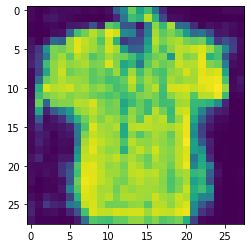

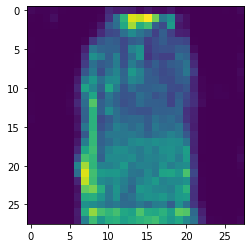

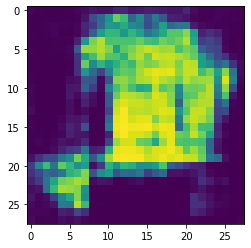

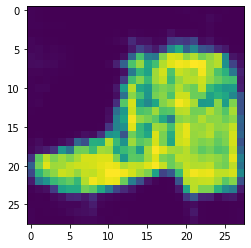

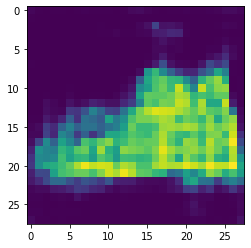

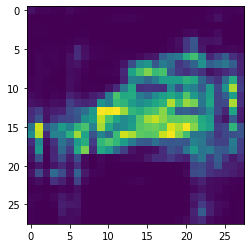

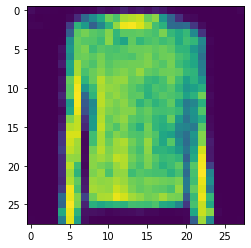

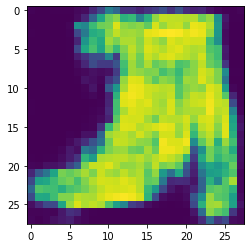

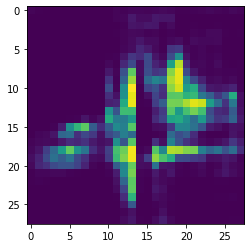

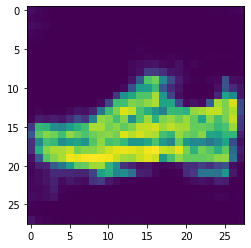

In [97]:
for i in range(10):
    noise = np.random.normal(0,1, (1,100))
    gen_img = unnormalize_tanh( generator.predict(noise)[0])        
    plt.imshow(gen_img.reshape(28,28))
    plt.show()

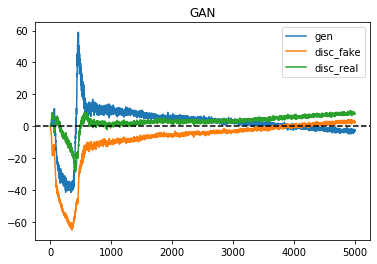

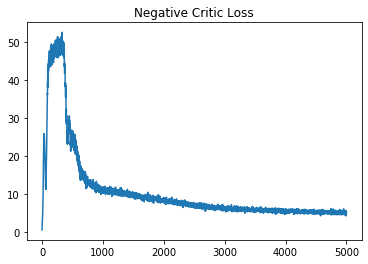

In [91]:
plt.plot(gen_loss_list, label="gen")
plt.plot(disc_fake_list, label="disc_fake")
plt.plot(disc_real_list, label="disc_real")
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title("GAN")
plt.savefig(figure_model_path / 'gan.png')
plt.show()

negative_critic_loss  = np.array(disc_real_list)-np.array(disc_fake_list)
plt.plot(negative_critic_loss)
plt.title("Negative Critic Loss")
plt.savefig(figure_model_path / 'negative_critic.png')
plt.show()